Simulate multiple models of students with varying noise and compare diligence estimates with each

# Setup

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *
from simulate.script_helpers import SimHelper

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *
from analytics.step import *
from analytics.transaction import *
from analytics.session import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.session:Base directory for the project:
/rdata/Sandbox/MotivSim


In [12]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
db_params['port'] = 27019
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.session:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-e19ead0a-30ce-49c0-b7c4-04a060d48ea6
INFO:analytics.session:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': 27019, 'name': 'motivsim', 'user': '', 'pswd': ''}


In [13]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, problems, has 16967 documents
INFO:log_db.mongo:collection name, simbatches, has 3 documents
INFO:log_db.mongo:collection name, kcs, has 610 documents
INFO:log_db.mongo:collection name, actions, has 10294391 documents
INFO:log_db.mongo:collection name, sessions, has 60000 documents
INFO:log_db.mongo:collection name, units, has 20 documents
INFO:log_db.mongo:collection name, students, has 4000 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 3000 documents
INFO:log_db.mongo:collection name, sections, has 86 documents
INFO:log_db.mongo:collection name, tutor_events, has 8569448 documents
INFO:log_db.mongo:collection name, decisions, has 10294391 documents
INFO:log_db.mongo:collection name, steps, has 70796 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, domains, has 1 documents


In [14]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.session:Clearing database before starting new simulation


# Simulating learners

In [15]:
num_students = 200
num_sessions = 20

In [16]:
sim_helper = SimHelper(db)

In [17]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.95
    m_ses_len = 45
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

    mod = round(len(students) / 10)
#     mod = 1
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [18]:
new_curric = None
new_domain = None

In [19]:
def get_domain_params(params=None):
    if params is None:
        #params = [0.7 , 0.05, 0.05, 0.01, 0.15, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
        params = [0.4 , 0.1, 0.1, 0.03, 0.1, 0.05, 0.1 , 0.05 , 0.1 , 0.07]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [20]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

## Simple Diligent students

In [21]:
sim_batch_desc = "Simple diligent students"
cog_mod = BiasSkillCognition
dec_mod = EVDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    ability = random.triangular(-1,1)
    #logger.info(f"Generating student with ability: {ability}")
    return {'ability': ability}

def get_dec_params():
    return {}

In [22]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 20 units with with a total of 555 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, 9f3c57cc-31a0-4004-a67b-ed9a8fd017d0, to db
INFO:log_db.curriculum_mapper:Writing 15628 problem to db
INFO:log_db.curriculum_mapper:Writing 65628 steps to db
INFO:analytics.session:Persisting 200 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #100
INFO:analytics.session:Simulating student #120
INFO:analytics.session:Simulating student #140
INFO:analytics.session:Simulating student #160
INFO:analytics.session:Simulating student #180
INFO:analytics.session:Inserting 200 simulated students to d

## Self Efficacy Diligent students

In [23]:
sim_batch_desc = "Self-Efficacy students"
cog_mod = BiasSkillCognition
dec_mod = DomainSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se}}

In [24]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 200 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #100
INFO:analytics.session:Simulating student #120
INFO:analytics.session:Simulating student #140
INFO:analytics.session:Simulating student #160
INFO:analytics.session:Simulating student #180
INFO:analytics.session:Inserting 200 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 200 in batch with id: 3e121e37-188a-4773-9a79-69aeacb4936f


## Intrinsic Interest Diligent students

In [25]:
sim_batch_desc = "Intrinsic Interest students"
cog_mod = BiasSkillCognition
dec_mod = MathInterestDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    return {'attr': {'interest': np.random.normal(0,1)}}

In [26]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 200 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #100
INFO:analytics.session:Simulating student #120
INFO:analytics.session:Simulating student #140
INFO:analytics.session:Simulating student #160
INFO:analytics.session:Simulating student #180
INFO:analytics.session:Inserting 200 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 200 in batch with id: 84f30927-b810-4f2f-8051-517fcc8b6ebd


## Self-eff/Interest Diligent students

In [27]:
sim_batch_desc = "Combo students"
cog_mod = BiasSkillCognition
dec_mod = MathIntSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se, 'interest': np.random.normal(0,1)}}

In [28]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 200 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #100
INFO:analytics.session:Simulating student #120
INFO:analytics.session:Simulating student #140
INFO:analytics.session:Simulating student #160
INFO:analytics.session:Simulating student #180
INFO:analytics.session:Inserting 200 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 200 in batch with id: 46dbe5d7-655b-4d1f-9481-63d6dba7614f


# EDA

## Student Parameters EDA

### Correlation Matrix of Measures

In [85]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish', 'Pct Hint']
cor_mat = {desc: pd.DataFrame(index=measures, columns = measures) for desc in batch_descs}
for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    for m_i in measures:
        for m_j in measures:
            corr, pval = pearsonr(ss[m_i],ss[m_j])
            cor_mat[desc].loc[m_i, m_j] = corr
    logger.info(f"\n{cor_mat[desc]}")

        

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:
              pct class Pct OffTask start speed early finish   Pct Hint
pct class             1   -0.507655   -0.645885    -0.869439  0.0935384
Pct OffTask   -0.507655           1    0.502953      0.37699 -0.0101737
start speed   -0.645885    0.502953           1     0.266423  -0.112836
early finish  -0.869439     0.37699    0.266423            1 -0.0605204
Pct Hint      0.0935384  -0.0101737   -0.112836   -0.0605204          1
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:
             pct class Pct OffTask start speed early finish  Pct Hint
pct class            1    -0.29519   -0.514095    -0.865985 -0.169123
Pct OffTask   -0.29519           1     0.30408      0.17258  0.259015
start speed  -0.514095     0.30408           1    0.0994618  0.124821
early finish -0.865985     0.17258   0.0994618            1  0.110495
Pct Hint     -0.169123    0.25

INFO:analytics.session:Simple diligent students


['diligence', 'cog_ability', 'dec_self_eff']


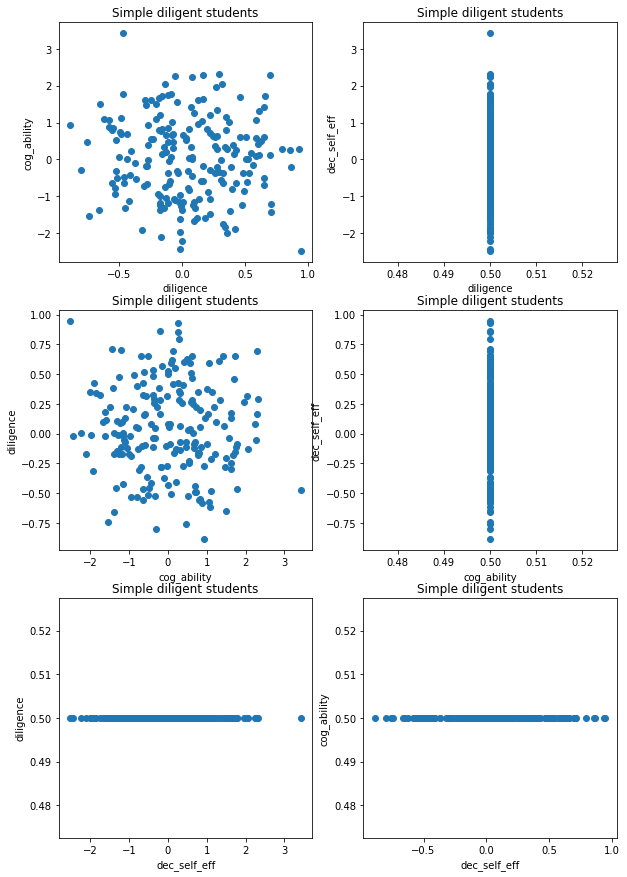

INFO:analytics.session:Self-Efficacy students


['diligence', 'cog_ability', 'dec_self_eff']


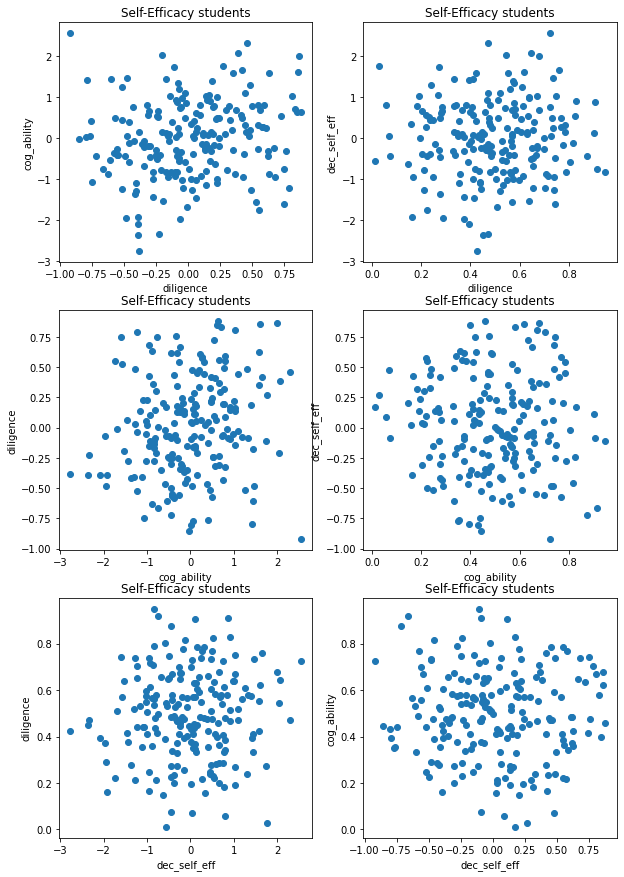

INFO:analytics.session:Intrinsic Interest students


['diligence', 'cog_ability', 'dec_self_eff']


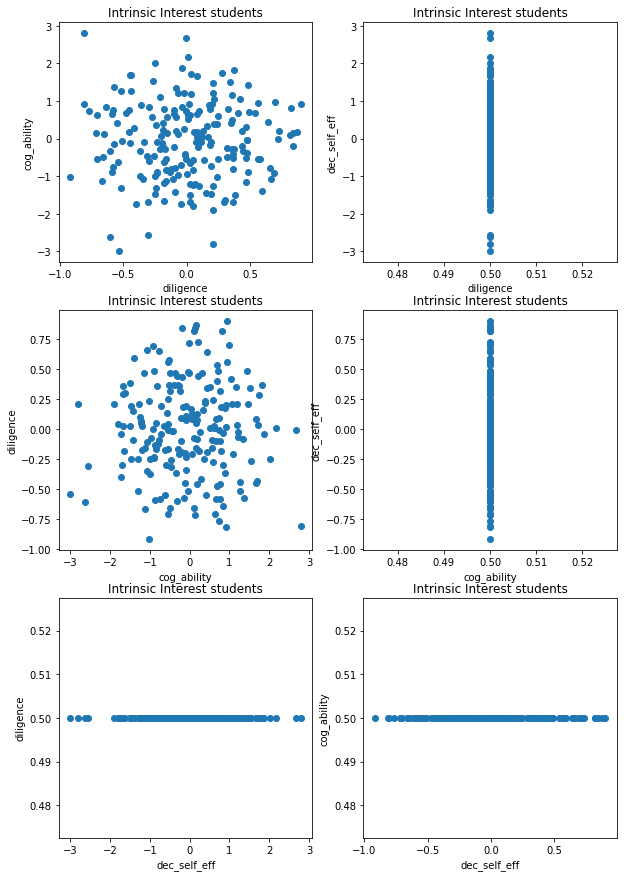

INFO:analytics.session:Combo students


['diligence', 'cog_ability', 'dec_self_eff']


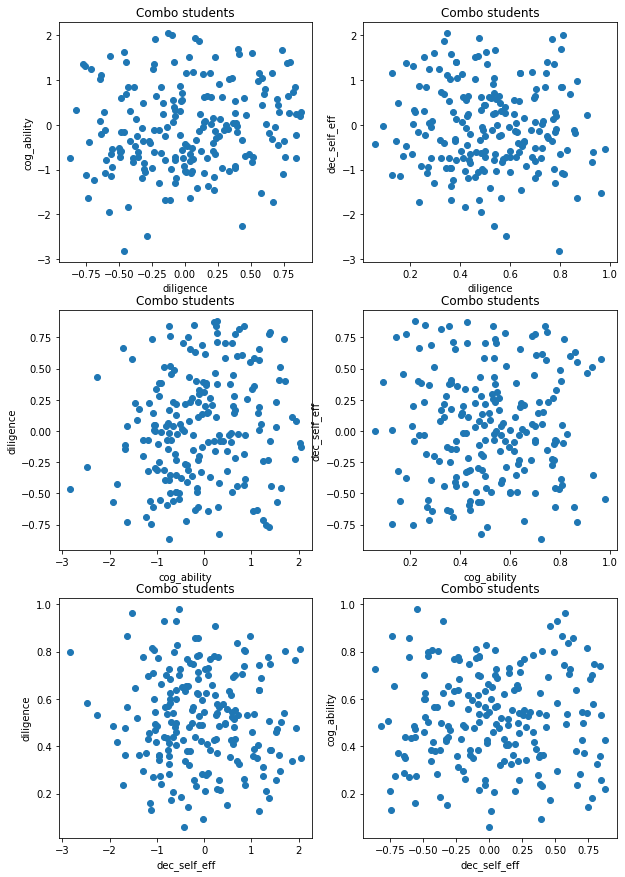

In [86]:


cols = ['diligence', 'cog_ability', 'dec_self_eff']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    i = 1
    avail_cols = [c for c in cols if c in sstats.columns.tolist()]
    print(avail_cols)
    l = len(avail_cols)
    plt.figure(figsize=(5*(l-1),5*(l)))
    logger.info(desc)
    for xcol in avail_cols:
        other_cols = [c for c in avail_cols if xcol != c]
        for ycol in other_cols:
            x = sstats[xcol]
            y = sstats[ycol]
            plt.subplot(len(avail_cols), len(other_cols), i)
            plt.scatter(y,x)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            plt.title(desc)    
            i += 1
    plt.show()
    

## Simulation Noise

### Session Opportunity

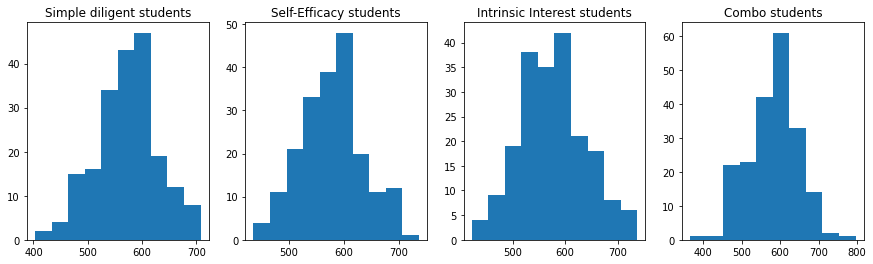

In [87]:
plt.figure(figsize=(15,4))
l = len(batch_descs)
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    col = 'total opportunity'
    plt.subplot(1,l, i+1)
    plt.hist(sstats['total opportunity'])
    plt.title(desc)    
plt.show()
    

### Detector error rates

In [88]:

l = len(batch_descs)
for i,desc in enumerate(batch_descs):
    logger.info(f"************** {desc} ******************")
    d = stu_stats[desc]
    cols = [col for col in d.columns.tolist() if "offtask_" in str(col)]
    dsum = d.loc[:,cols].apply(np.sum, axis=0)
    total = np.sum(dsum)
    dpct = dsum.apply(lambda x: x/total)
    logger.info(f"Offtask Error Rates: \nTP: {dpct['offtask_tp']}\tFP: {dpct['offtask_fp']}\tTN: {dpct['offtask_tn']}\tFN: {dpct['offtask_fn']}")
    cols = [col for col in d.columns.tolist() if "guess_" in str(col)]
    dsum = d.loc[:,cols].apply(np.sum, axis=0)
    total = np.sum(dsum)
    dpct = dsum.apply(lambda x: x/total)
    logger.info(f"Guess Error Rates: \nTP: {dpct['guess_tp']}\tFP: {dpct['guess_fp']}\tTN: {dpct['guess_tn']}\tFN: {dpct['guess_fn']}")


INFO:analytics.session:************** Simple diligent students ******************


KeyError: 'offtask_tp'

### Work Rate - Tutor Policy Overpractice

INFO:analytics.session:************** Simple diligent students ******************


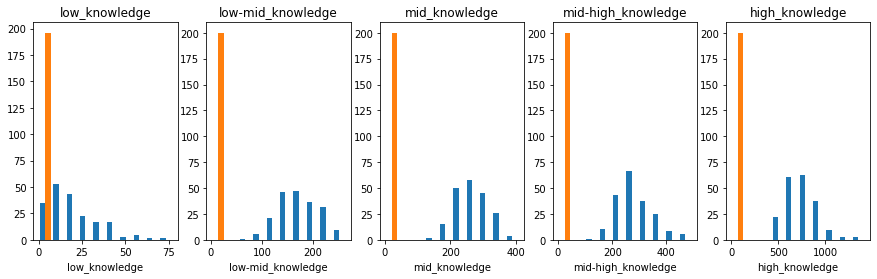

INFO:analytics.session:************** Self-Efficacy students ******************


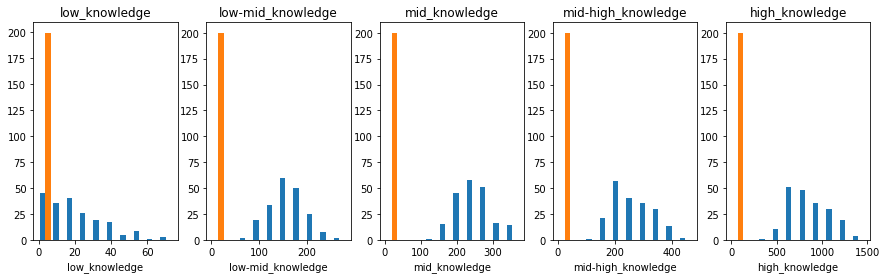

INFO:analytics.session:************** Intrinsic Interest students ******************


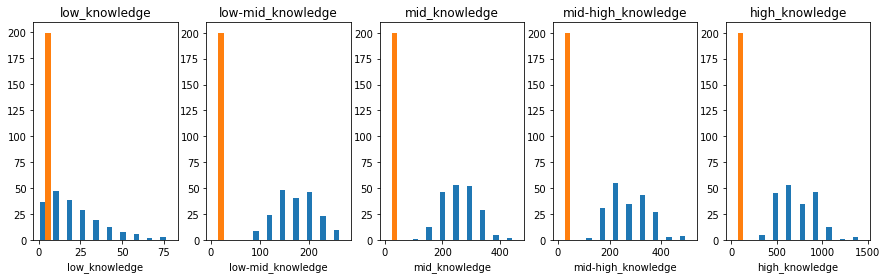

INFO:analytics.session:************** Combo students ******************


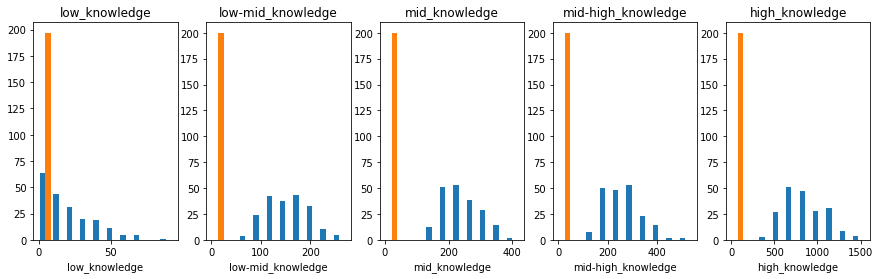

In [89]:

know_lvls = ['low_knowledge', 'low-mid_knowledge','mid_knowledge', 'mid-high_knowledge', 'high_knowledge']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(15,4))    
    for j, col in enumerate(know_lvls):
        plt.subplot(1,len(know_lvls), j+1)
        plt.hist(sstats[col])
        plt.xlabel(col)
        plt.title(col)

    plt.show()

## Diligence

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.17630841393562932	 pval = 0.012512774712597291
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = 0.0402224178047681	 pval = 0.5717375694408747
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = 0.12088853765914014	 pval = 0.0881635963624062
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8159986865978327	 pval = 5.1285604186953965e-49
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.511596179535244	 pval = 9.805637050280062e-15
INFO:analytics.session:Pct Hint Correlation with diligence: 
R = 0.13918207128676718	 pval = 0.049348119833473994


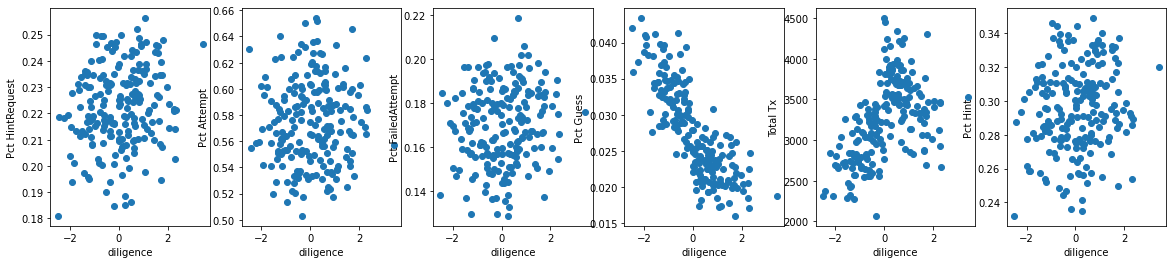

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = -0.08965372164007919	 pval = 0.20677187430288585
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = 0.2688192519200292	 pval = 0.00011863057316756597
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = -0.016257887371943485	 pval = 0.8192612919793774
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.7894174499413481	 pval = 7.793272219990248e-44
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.5744859642463025	 pval = 5.870738768513876e-19
INFO:analytics.session:Pct Hint Correlation with diligence: 
R = -0.11871976108241462	 pval = 0.09406107208701565


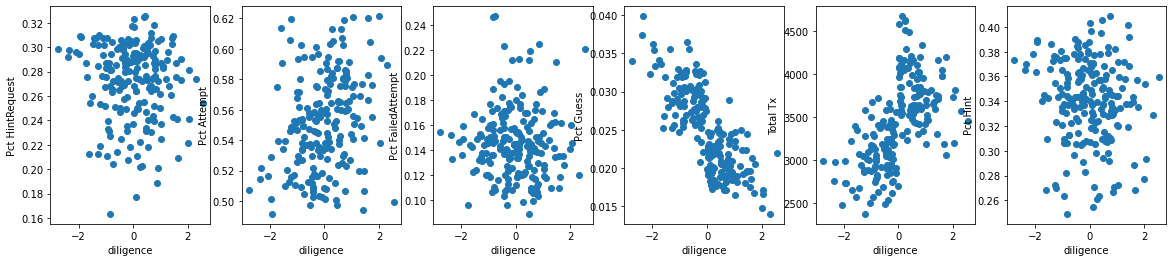

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.07531707699643046	 pval = 0.28915630242188334
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = 0.14079364861411187	 pval = 0.046749913093236915
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = 0.01305990319338198	 pval = 0.8543703562285067
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.6976532724536653	 pval = 1.706990385864974e-30
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.4150807891368776	 pval = 9.882950137085111e-10
INFO:analytics.session:Pct Hint Correlation with diligence: 
R = 0.04991362483194399	 pval = 0.48274253049199817


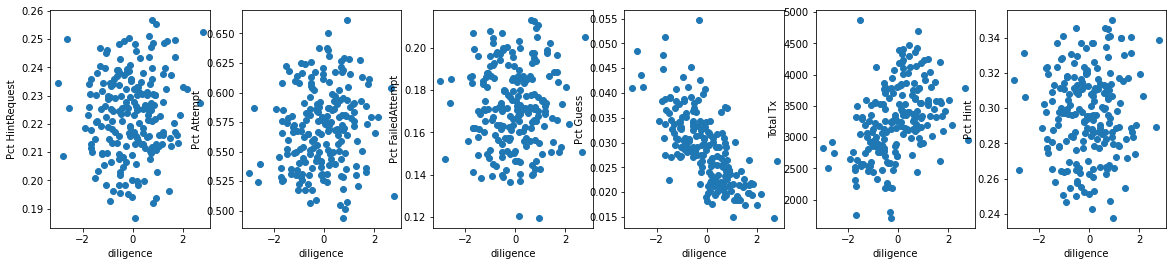

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.05510289137634951	 pval = 0.43835320566725355
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = 0.1838339209346903	 pval = 0.009167222084299504
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = -0.09142699441703032	 pval = 0.19789676546867782
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.6749266924801681	 pval = 6.0670637326705765e-28
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.4379375266569053	 pval = 8.86882923642617e-11
INFO:analytics.session:Pct Hint Correlation with diligence: 
R = 0.0358111589479896	 pval = 0.614659619059383


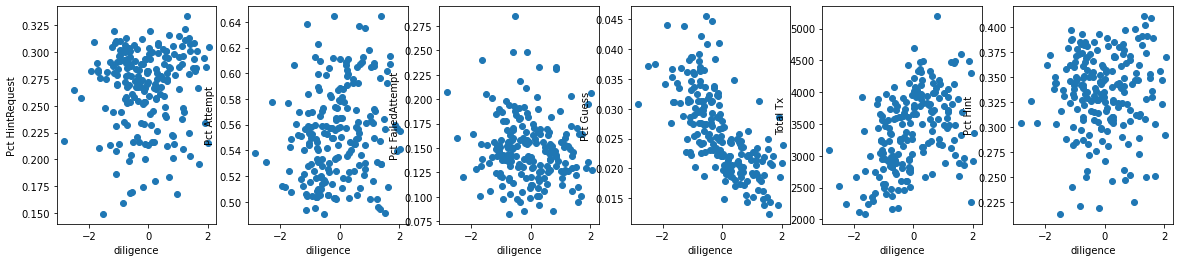

In [102]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx', 'Pct Hint']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Total Time

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.4171848353496071	 pval = 7.975289014733454e-10
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.7222485062884918	 pval = 1.541249777692077e-33
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.6123218292867311	 pval = 5.740055216940869e-22
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.602799486262644	 pval = 3.582377949179541e-21
INFO:analytics.session:session length Correlation with diligence: 
R = 0.5990879433878319	 pval = 7.194439706589473e-21


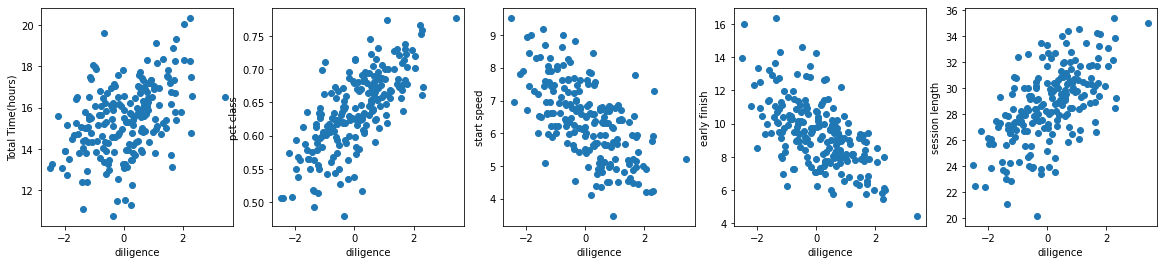

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.3029629543582368	 pval = 1.2969978458808702e-05
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.6060018388374114	 pval = 1.9485127241739574e-21
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.5629711567666104	 pval = 4.070585749208235e-18
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.4085913295087172	 pval = 1.89727576217797e-09
INFO:analytics.session:session length Correlation with diligence: 
R = 0.5576207086265657	 pval = 9.759485325752366e-18


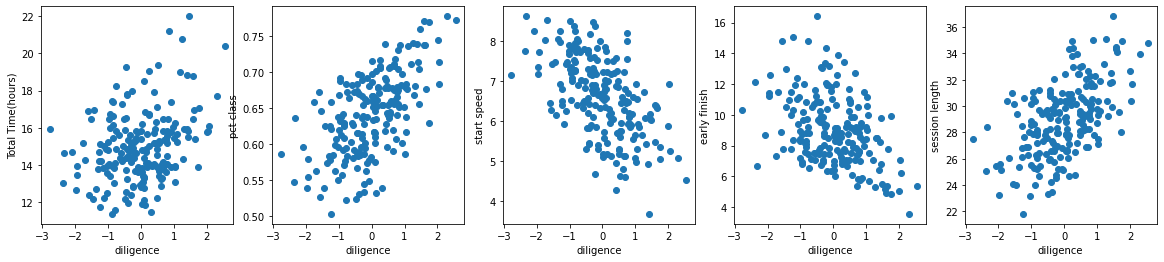

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.3455080748465643	 pval = 5.421282993934497e-07
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.558122047640453	 pval = 8.997703884568577e-18
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.3183655207767785	 pval = 4.3430024679166975e-06
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.49094639784791677	 pval = 1.576754012155863e-13
INFO:analytics.session:session length Correlation with diligence: 
R = 0.466394998456509	 pval = 3.391794931212004e-12


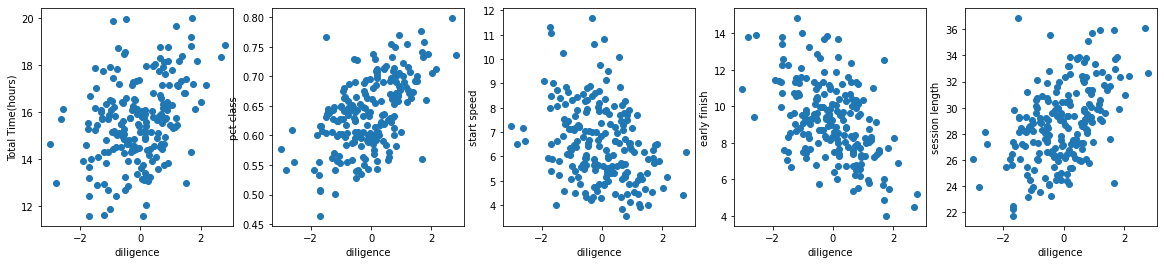

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.19737950739544677	 pval = 0.005086798342187311
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.5142081004803736	 pval = 6.808031537827282e-15
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.3954273251286762	 pval = 6.829502461670335e-09
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.4045821939381178	 pval = 2.8191153829664986e-09
INFO:analytics.session:session length Correlation with diligence: 
R = 0.4406620143037492	 pval = 6.573083625226136e-11


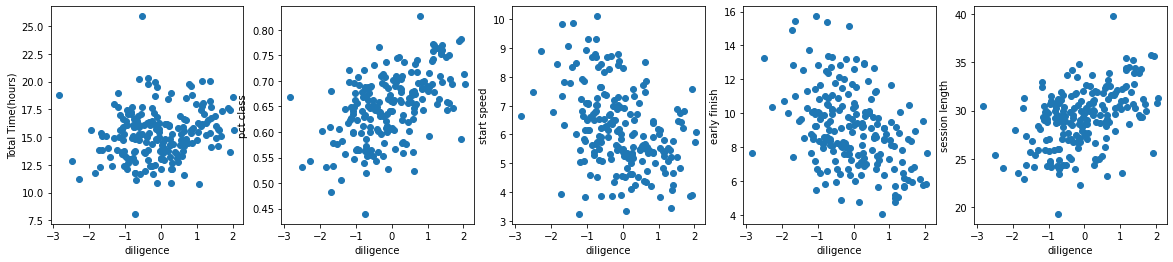

In [91]:

cols = ['Total Time(hours)', 'pct class', 'start speed', 'early finish', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Off-task & Guessing

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.4451567885445295	 pval = 3.986577398729217e-11
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.6301249729608931	 pval = 1.5765575571557085e-23
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8159986865978327	 pval = 5.1285604186953965e-49
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.1912587698460384	 pval = 0.006668838389627983
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.28053263361222885	 pval = 5.732568588351922e-05


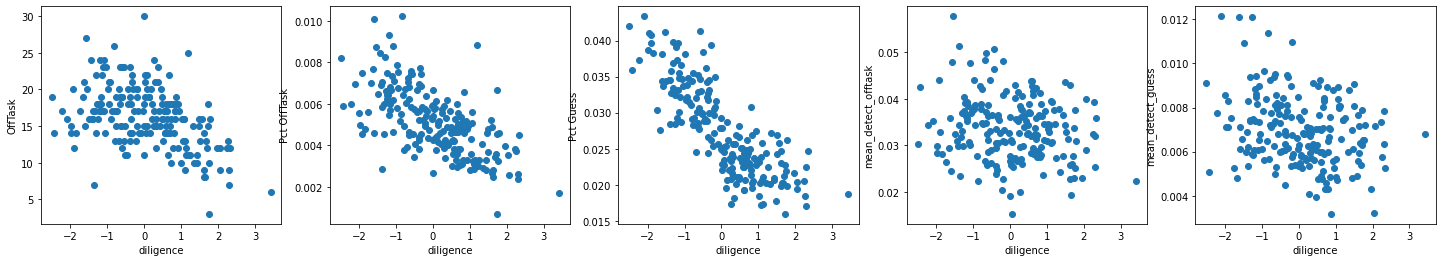

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.3654674621801045	 pval = 1.030142658227582e-07
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.5996052888339268	 pval = 6.531639212235474e-21
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.7894174499413481	 pval = 7.793272219990248e-44
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.04482302852501659	 pval = 0.528539575448734
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.2087148057481699	 pval = 0.003017927617531979


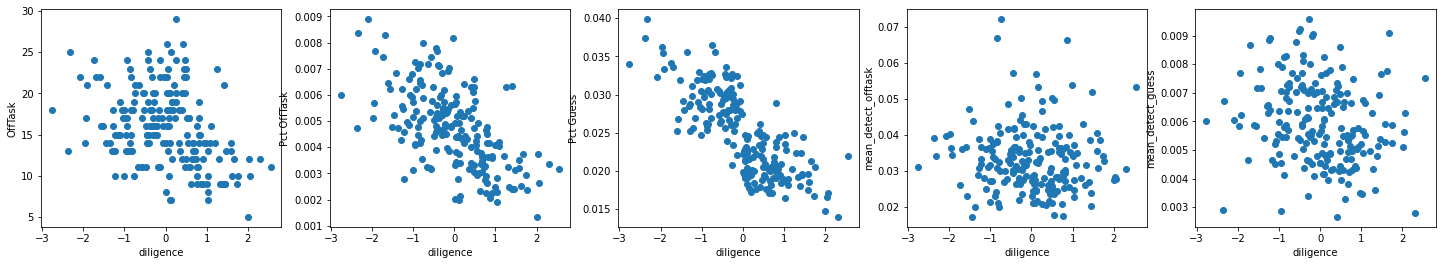

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.37313227981905167	 pval = 5.279702827455753e-08
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.5391242140590569	 pval = 1.782873285595632e-16
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.6976532724536653	 pval = 1.706990385864974e-30
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.09645967036227138	 pval = 0.1742208152098179
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.382822314655771	 pval = 2.2115748345684254e-08


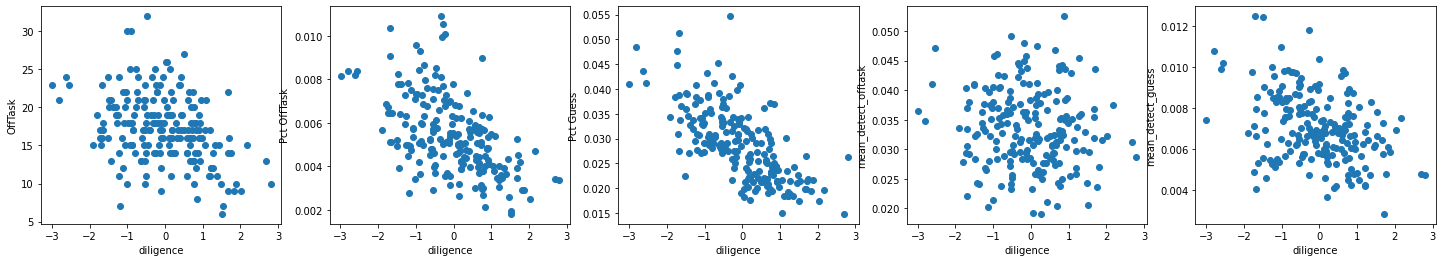

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.3209854166898262	 pval = 3.583479836869132e-06
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.5173815655589886	 pval = 4.351795334514237e-15
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.6749266924801681	 pval = 6.0670637326705765e-28
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.08086141605486921	 pval = 0.2550160098565916
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.26251158333972785	 pval = 0.00017314842862268756


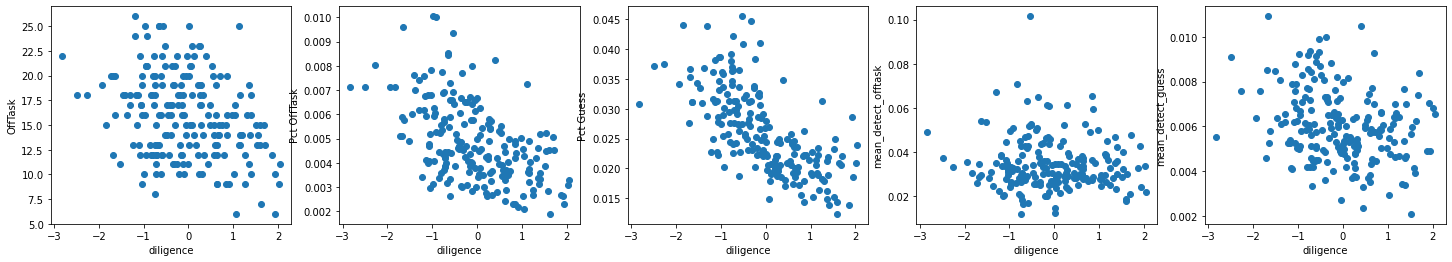

In [92]:

cols = ["OffTask", 'Pct OffTask', 'Pct Guess', 'mean_detect_offtask', 'mean_detect_guess']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(25,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Time-on-task

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.4171848353496071	 pval = 7.975289014733454e-10
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.5383875722428042	 pval = 1.9942455123730497e-16
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.15694266783790162	 pval = 0.02646196465137605


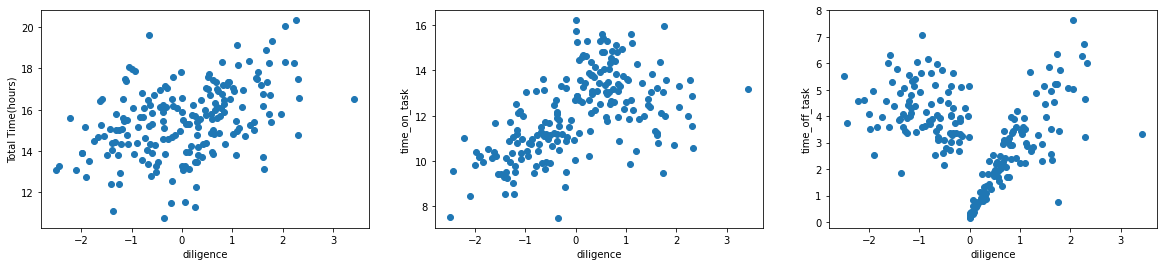

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.3029629543582368	 pval = 1.2969978458808702e-05
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.5256909285496039	 pval = 1.3185213755875427e-15
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.2761854627442856	 pval = 7.537644233392511e-05


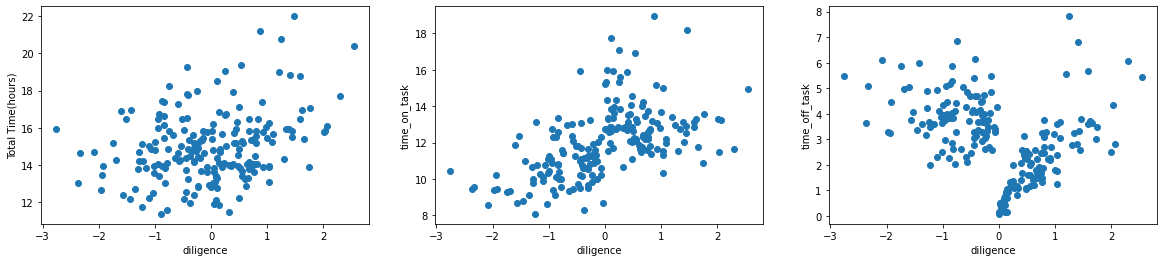

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.3455080748465643	 pval = 5.421282993934497e-07
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.40924851901168036	 pval = 1.7771371591922477e-09
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.14288437825614375	 pval = 0.043550380542937174


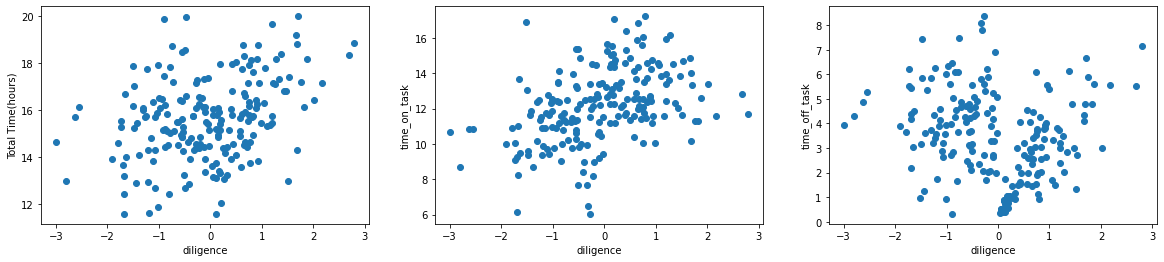

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.19737950739544677	 pval = 0.005086798342187311
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.37498716819573513	 pval = 4.479409387528098e-08
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.1936236694963232	 pval = 0.006011846212542359


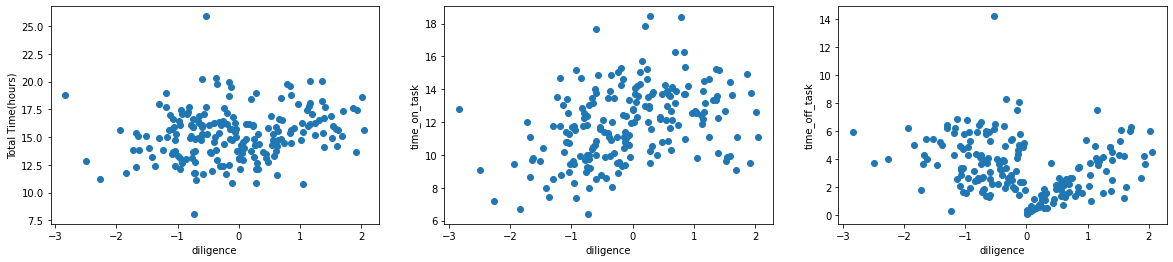

In [93]:

cols = ['Total Time(hours)', 'time_on_task', 'time_off_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = -0.045212213035488724	 pval = 0.5249624121943962
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = 0.06557685180697172	 pval = 0.356227549224556
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.23864956568471282	 pval = 0.0006660966017112058
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.5399152898486117	 pval = 1.5802808453149963e-16
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.3167079075572706	 pval = 4.900124403669717e-06


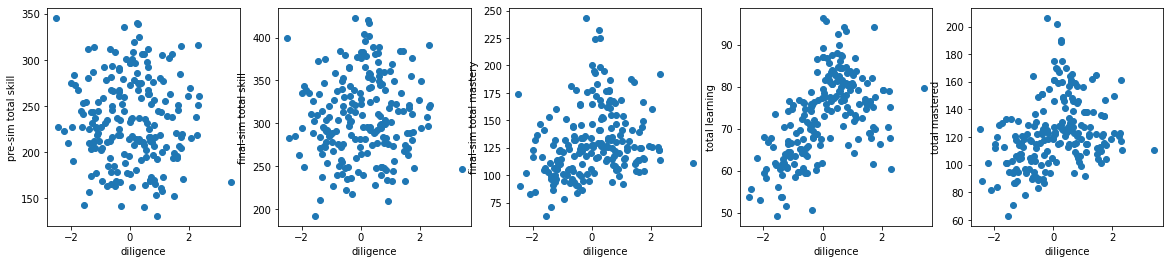

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = 0.17471460684455462	 pval = 0.013345560713649316
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = 0.27628501152129753	 pval = 7.490922263667494e-05
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.43052335154621596	 pval = 1.9774472355647754e-10
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.5603171469115756	 pval = 6.293475976430837e-18
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.48404581580957795	 pval = 3.829381413542749e-13


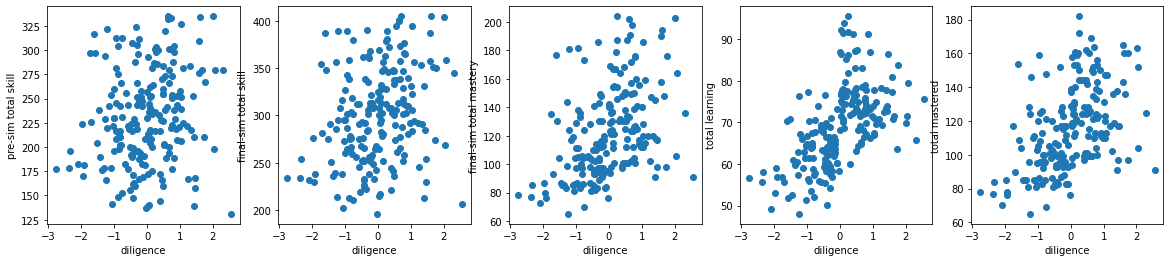

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = 0.0172417936807707	 pval = 0.8085280140276367
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = 0.11466899809395349	 pval = 0.10591335201937317
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.254064288176725	 pval = 0.00028315775489283257
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.42397216360415	 pval = 3.9524839656040213e-10
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.293759822208145	 pval = 2.4227637503014954e-05


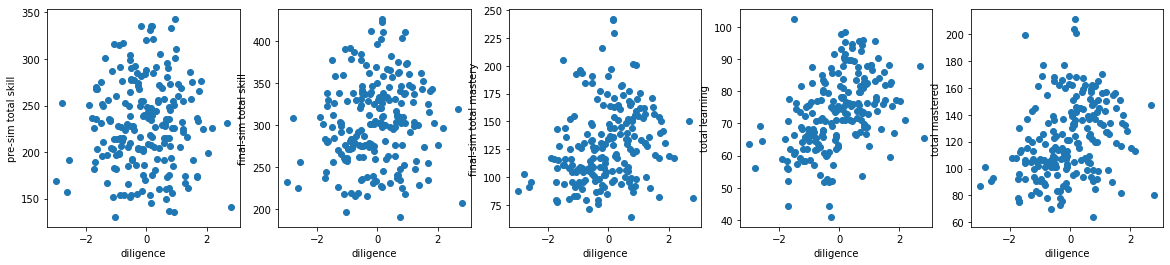

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = 0.1422185444718977	 pval = 0.04454879481974897
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = 0.2257682624088548	 pval = 0.0013070053939555197
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.34690928578087393	 pval = 4.842548295606122e-07
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.40589641955375233	 pval = 2.477343780516669e-09
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.37734460244816315	 pval = 3.629474186476863e-08


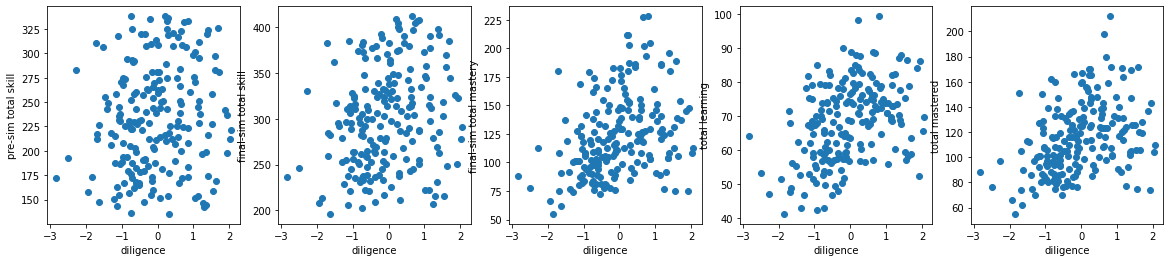

In [94]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Cog Ability

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9970320837276737	 pval = 1.8414887088057885e-222
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9763732480404943	 pval = 1.0504196167182135e-133
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.8049944004614987	 pval = 8.950880538306934e-47
INFO:analytics.session:total learning Correlation with cog_ability: 
R = -0.036551347380115076	 pval = 0.6073597856502023
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.723491164706243	 pval = 1.060132136048724e-33


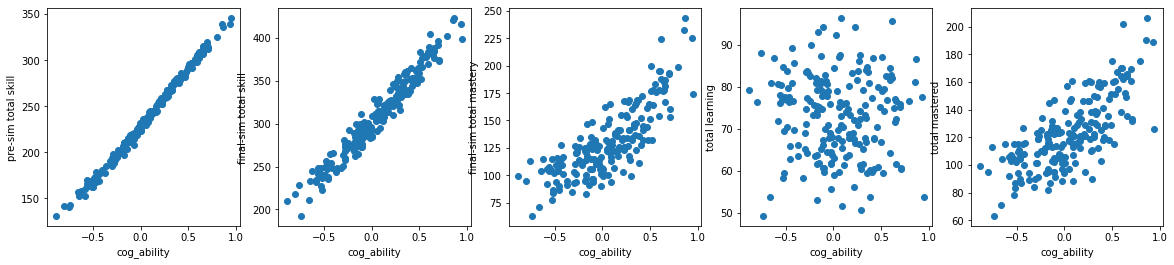

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9972189942157599	 pval = 2.967473520357142e-225
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9784563778363667	 pval = 1.2511117673666136e-137
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.8401029311025301	 pval = 1.6881278542599342e-54
INFO:analytics.session:total learning Correlation with cog_ability: 
R = 0.040659176347331766	 pval = 0.567565977967279
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.757958538154795	 pval = 1.3575660417421758e-38


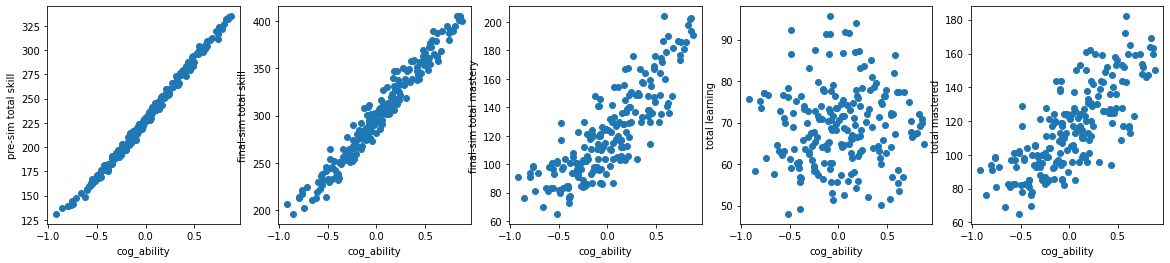

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9970991316839435	 pval = 1.923730512493905e-223
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9708003560922911	 pval = 1.018111260411855e-124
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.7952827681315905	 pval = 6.527151272976744e-45
INFO:analytics.session:total learning Correlation with cog_ability: 
R = 0.09700811635349238	 pval = 0.1717733131609469
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.7159190041907662	 pval = 1.0048733965775116e-32


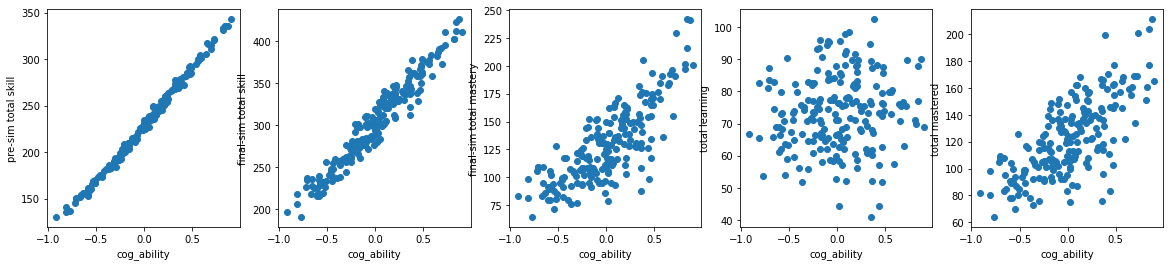

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9975367327802597	 pval = 1.8312319580151777e-230
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9749167540690478	 pval = 3.650051473655093e-131
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.7924164552898378	 pval = 2.2150369098683943e-44
INFO:analytics.session:total learning Correlation with cog_ability: 
R = -0.02472809894519156	 pval = 0.7281636643496795
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.6855434631854859	 pval = 4.172209045837348e-29


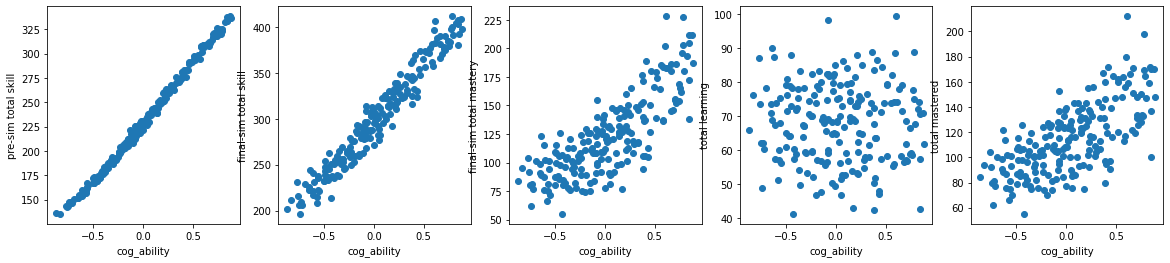

In [95]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.8845492605754542	 pval = 1.6925924224948123e-67
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.9393762390701786	 pval = 5.496931476591236e-94
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.8800720002182734	 pval = 5.811967139176604e-66
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.16146764803019684	 pval = 0.022360150744575348
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.017463945314115683	 pval = 0.8061094604718378


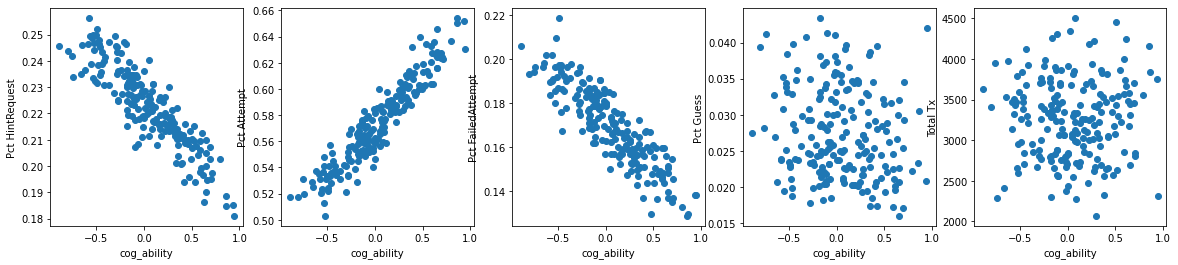

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.33191817012476166	 pval = 1.5753694003617277e-06
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.9213447837949686	 pval = 3.484992491963861e-83
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.5700825638275123	 pval = 1.2421355048617385e-18
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.3429642720683648	 pval = 6.645103757156024e-07
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.23874068649351987	 pval = 0.00066284123419772


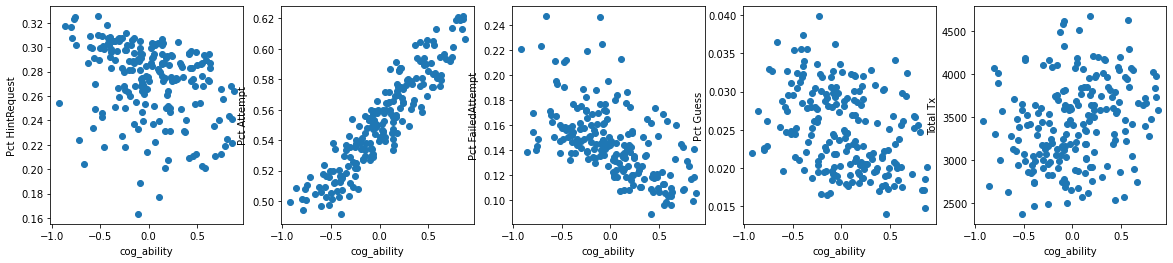

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.9122380205490203	 pval = 1.1285002589814251e-78
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.9439975470465842	 pval = 2.6989624879596564e-97
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.8810321784974564	 pval = 2.755441510218119e-66
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.15798460565914163	 pval = 0.025464286200359343
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.141450027877019	 pval = 0.045724935670388635


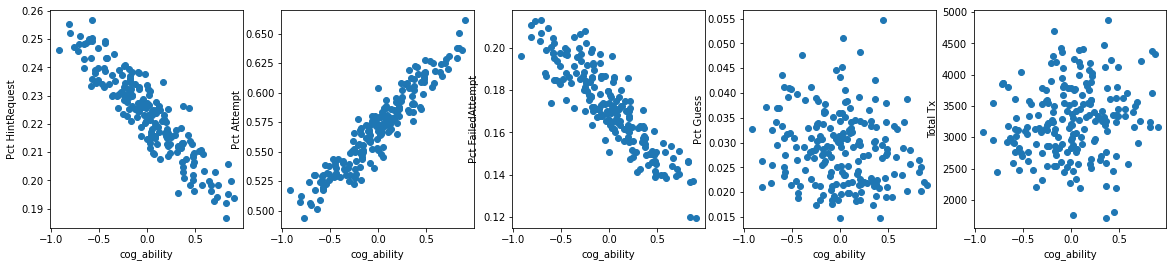

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.3364453699783775	 pval = 1.1104338527157653e-06
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.9263415729118908	 pval = 6.753792199272687e-86
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.5576753729942625	 pval = 9.67344853139012e-18
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.256036236729996	 pval = 0.00025281625277765964
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.12285943001233472	 pval = 0.08306436881906931


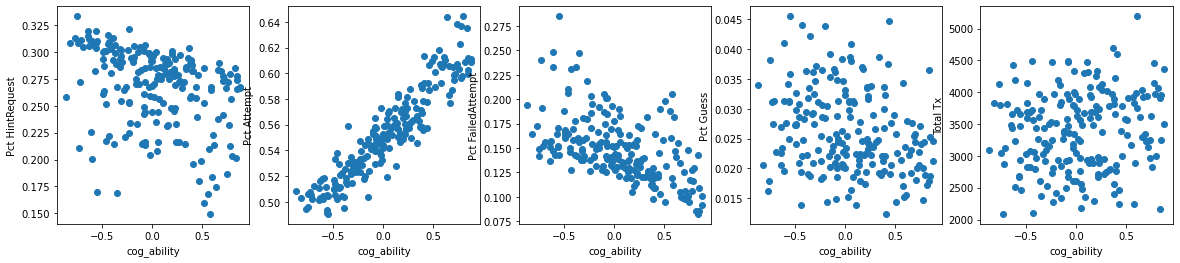

In [96]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx', 'Pct Hint']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Early Finish

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = 0.05486442146925511	 pval = 0.44034064015069857
INFO:analytics.session:early finish Correlation with cog_ability: 
R = 0.05247587663367238	 pval = 0.4605278345344031
INFO:analytics.session:pct class Correlation with cog_ability: 
R = -0.059515477984385556	 pval = 0.4025123759640186
INFO:analytics.session:session length Correlation with cog_ability: 
R = -0.07101622728785667	 pval = 0.3176550563415327


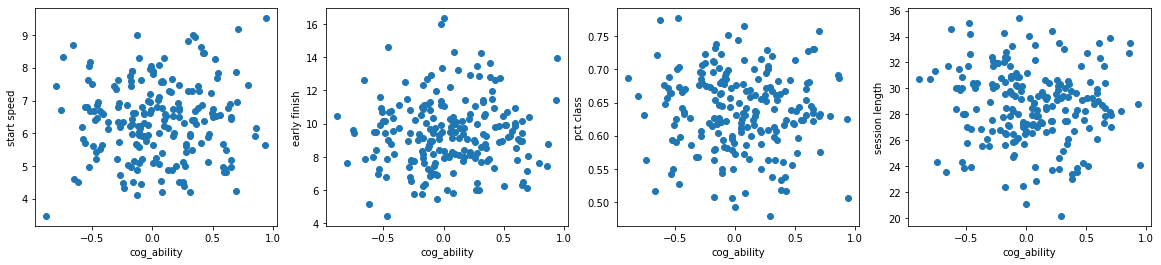

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = -0.06084808249758618	 pval = 0.392041211293329
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.10742232442132249	 pval = 0.13001487121047559
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.14243275230505187	 pval = 0.04422552099316119
INFO:analytics.session:session length Correlation with cog_ability: 
R = 0.1329583085920656	 pval = 0.060535915682347265


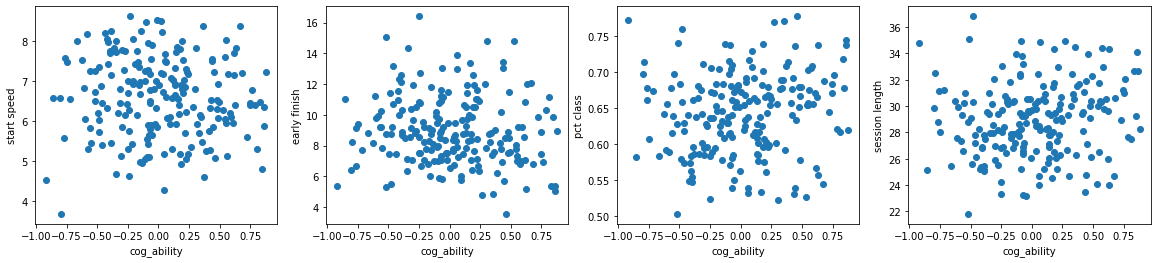

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = 0.00576825621303903	 pval = 0.9353904061513629
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.11479120670605213	 pval = 0.1055393465556886
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.0859143242114534	 pval = 0.22641929577857478
INFO:analytics.session:session length Correlation with cog_ability: 
R = 0.09254152563057057	 pval = 0.19246206672899932


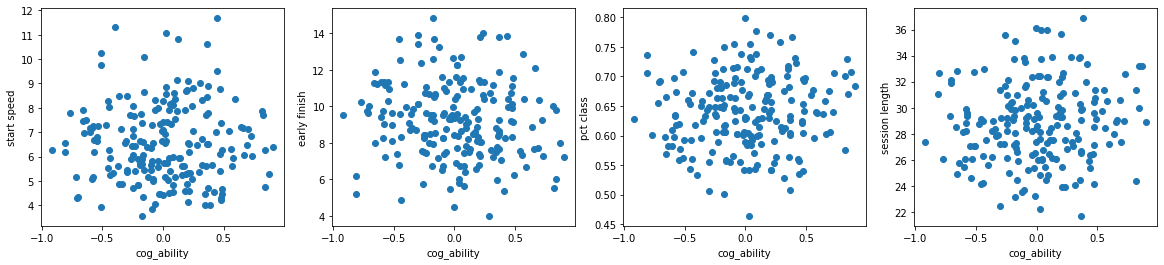

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = -0.007566815088781323	 pval = 0.9153112497348946
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.03319906035489856	 pval = 0.6407206737888861
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.01901499425455636	 pval = 0.7892757289594805
INFO:analytics.session:session length Correlation with cog_ability: 
R = -0.026840206381254124	 pval = 0.7059754835535803


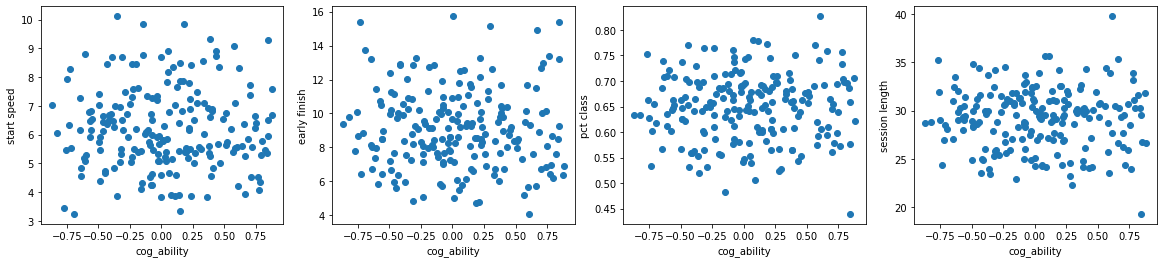

In [97]:

cols = ['start speed', 'early finish', 'pct class', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Work Rate

### Offtask

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.013801252098109095	 pval = 0.8462032681699676
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.153325724294838	 pval = 0.030189509354344925
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.19292119752443943	 pval = 0.0062006812972999386
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.24294383761185137	 pval = 0.0005276994081779385


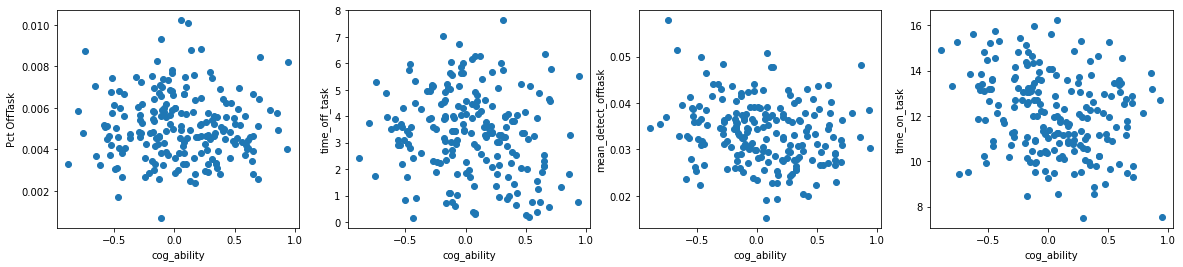

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.2815792750017663	 pval = 5.363267265635925e-05
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.21009722570361491	 pval = 0.002826531988715819
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.26299378196756307	 pval = 0.00016827034534125894
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.0614890713236973	 pval = 0.38706349410489854


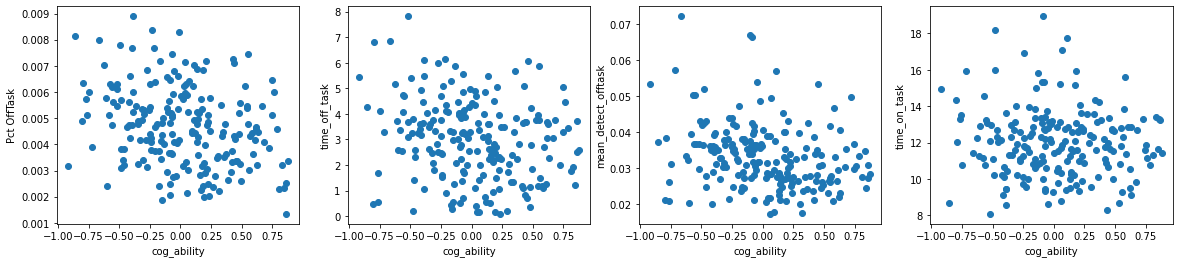

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.10361936460255967	 pval = 0.14424959849303753
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.1847293053099551	 pval = 0.008827374409753326
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.16469464995160654	 pval = 0.019781238071559584
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.10838560210078324	 pval = 0.12658699425424366


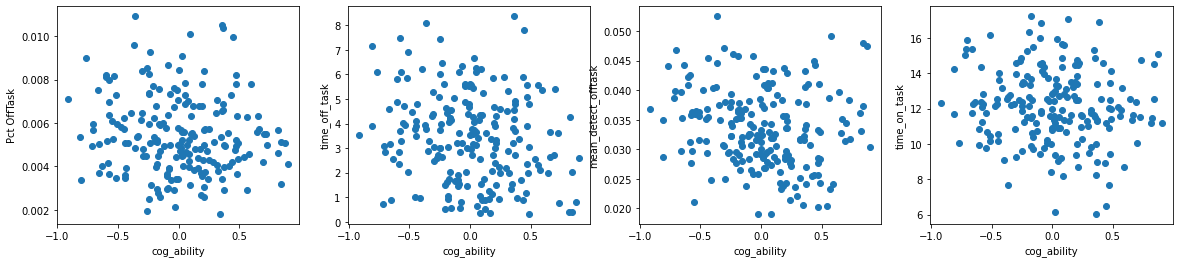

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.2261919130585776	 pval = 0.0012790913728413032
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.26165591711413433	 pval = 0.0001821309906634479
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.22386229389032392	 pval = 0.0014396210971196748
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.12289243370323936	 pval = 0.08298104266291337


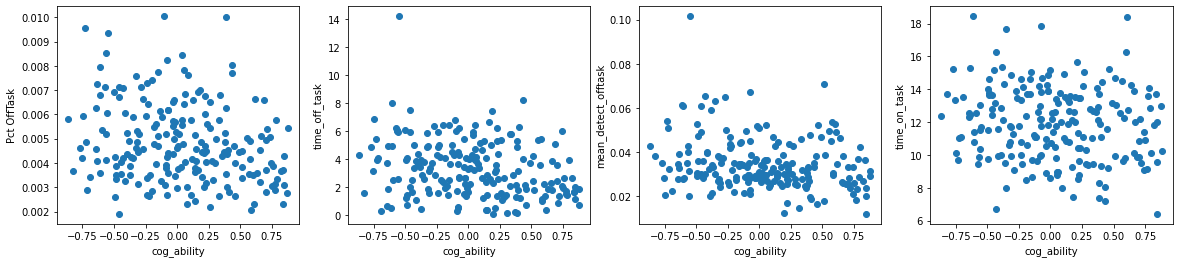

In [98]:

cols = ['Pct OffTask', 'time_off_task', 'mean_detect_offtask', 'time_on_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Self-Efficacy

### Work Rate

### Offtask

INFO:analytics.session:************** Simple diligent students ******************
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = nan	 pval = nan


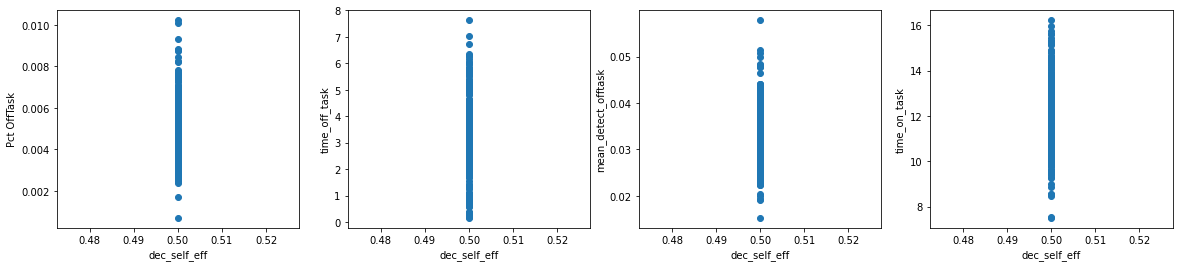

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = -0.083842893696816	 pval = 0.23785509561527687
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = 0.001003948152829864	 pval = 0.9887430355826372
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = 0.574257190777673	 pval = 6.105521763653392e-19
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = 0.3935327774540357	 pval = 8.174582870953389e-09


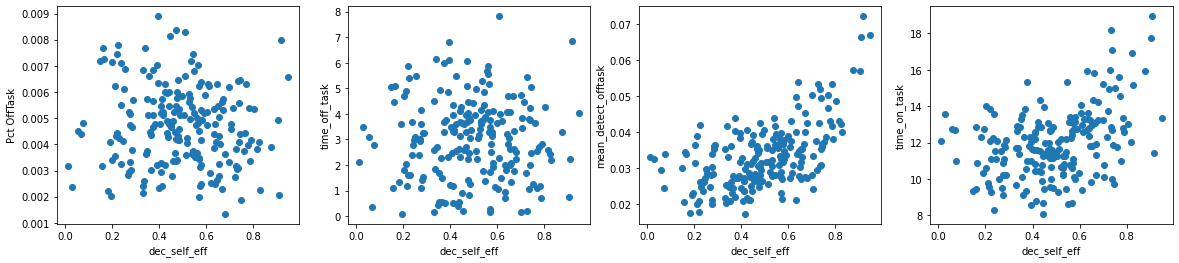

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = nan	 pval = nan


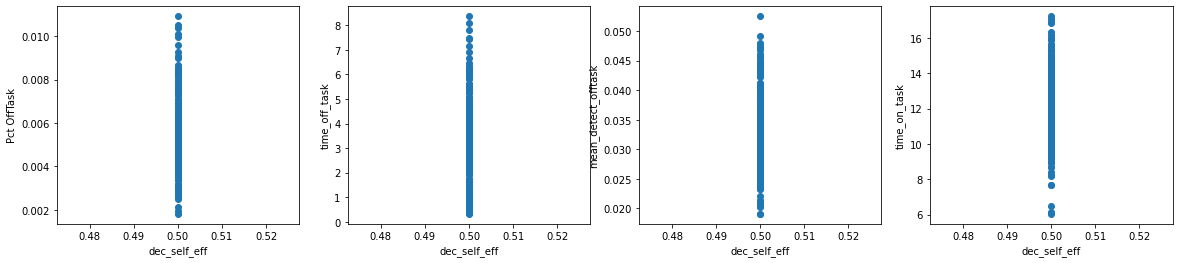

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = 0.08062121821387051	 pval = 0.25643481921040434
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = 0.1512960930486148	 pval = 0.03247095239992365
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = 0.7015463823483596	 pval = 5.903822830421802e-31
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = 0.3111875573947765	 pval = 7.2866688008201316e-06


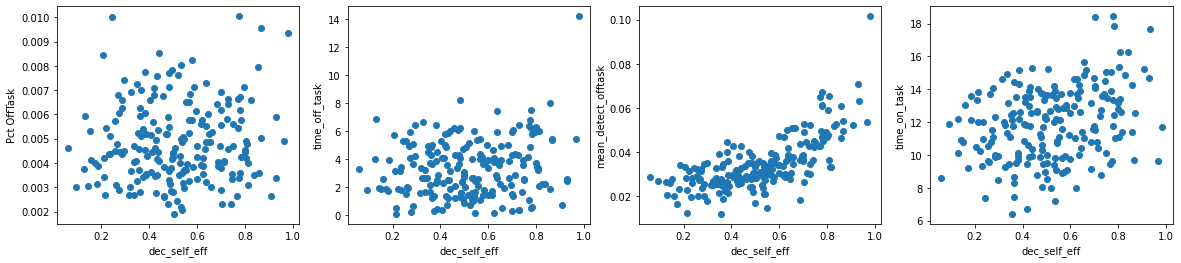

In [99]:

cols = ['Pct OffTask', 'time_off_task', 'mean_detect_offtask', 'time_on_task']

for i,desc in enumerate(batch_descs):
        sstats = stu_stats[desc]  
        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'dec_self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = nan	 pval = nan


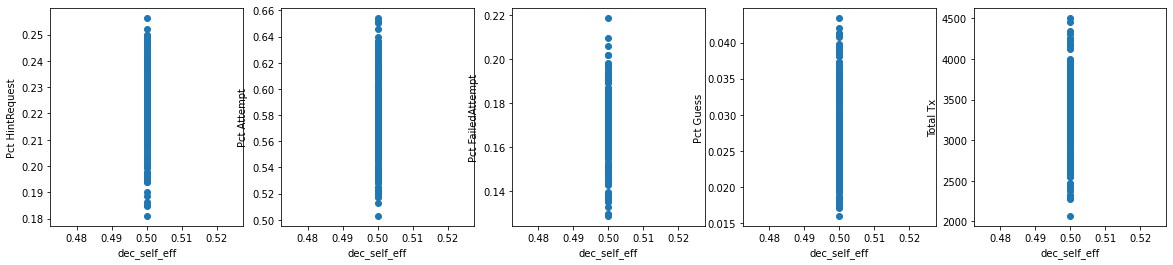

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = -0.7979362861783078	 pval = 2.0694774249456244e-45
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = 0.17098671655437025	 pval = 0.01548574520284706
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = 0.69846419342035	 pval = 1.3702428782517143e-30
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = -0.04101463786753665	 pval = 0.5641815863878029
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = 0.0025138447971822502	 pval = 0.9718179148678092


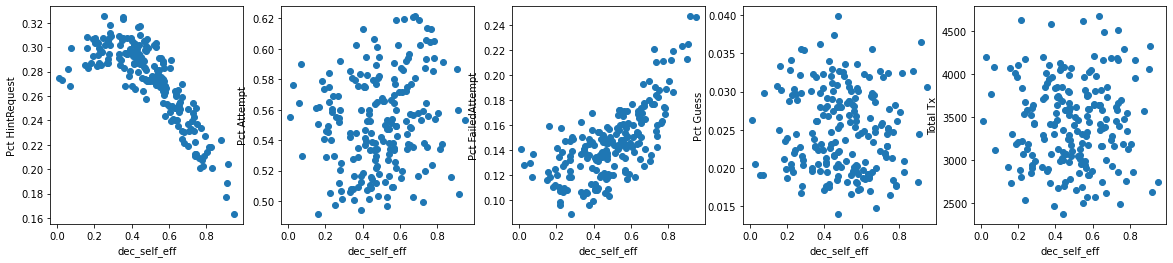

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = nan	 pval = nan


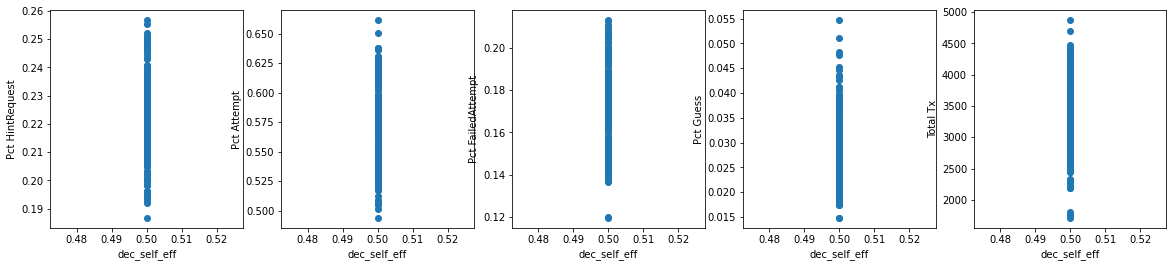

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = -0.8594120790133887	 pval = 1.3587339720915234e-59
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = 0.22540980097872668	 pval = 0.0013310586923603166
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = 0.713281848643726	 pval = 2.161931561808957e-32
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = -0.01589335210584105	 pval = 0.823246611754203
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = -0.07400934055175692	 pval = 0.29763485553579305


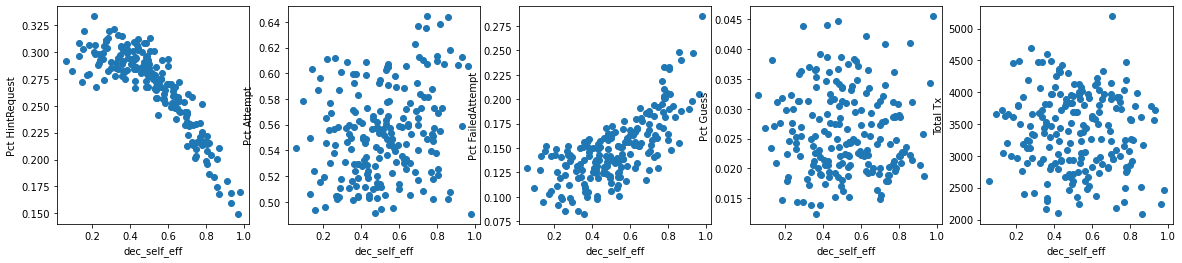

In [100]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'dec_self_eff'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = nan	 pval = nan


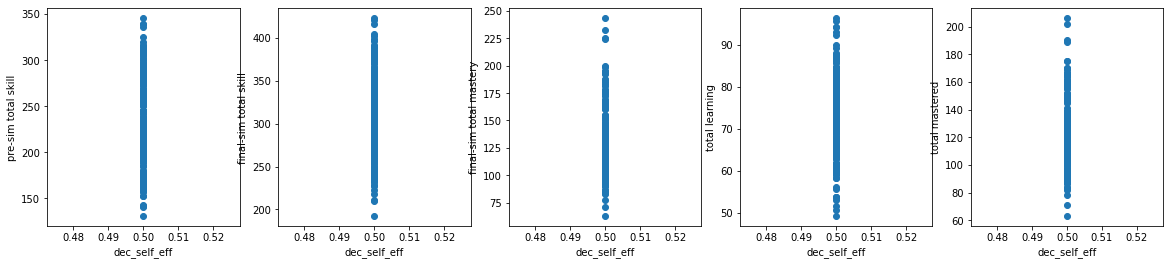

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = -0.03778636256601022	 pval = 0.5952662538967547
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = 0.01582173415489491	 pval = 0.8240301179056545
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = 0.09285092917978847	 pval = 0.19097283752032884
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = 0.27752686308981456	 pval = 6.930460106392976e-05
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = 0.11120246928582903	 pval = 0.11696306410129803


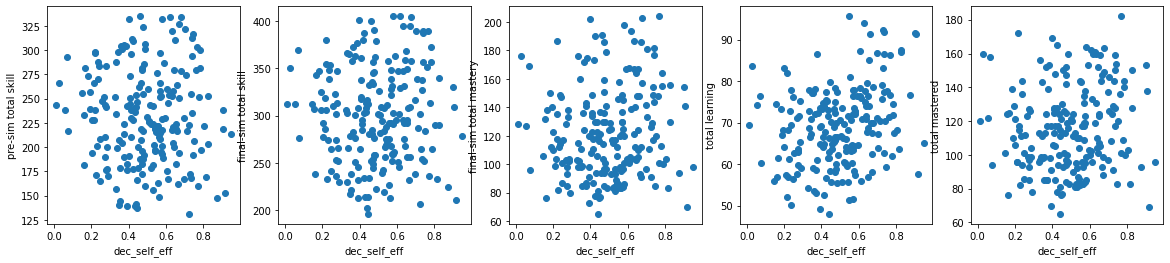

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = nan	 pval = nan


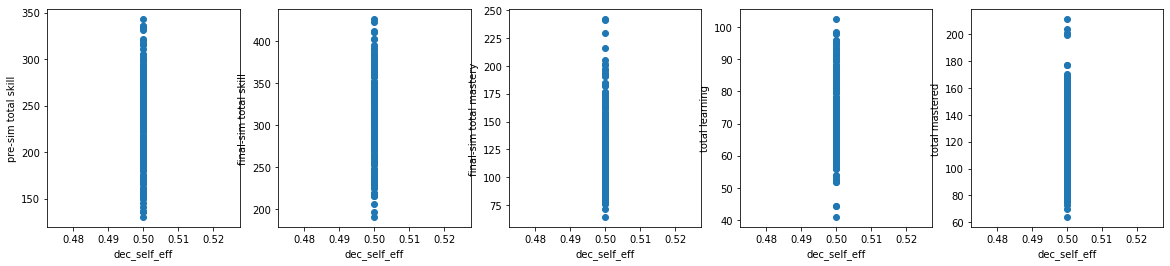

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = 0.022052993100907047	 pval = 0.7565919329715015
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = 0.06343005548432254	 pval = 0.37222533380370953
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = 0.12715362576202813	 pval = 0.07277449346495686
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = 0.19703887050127156	 pval = 0.005165090360417654
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = 0.15996487014307365	 pval = 0.023656945352816223


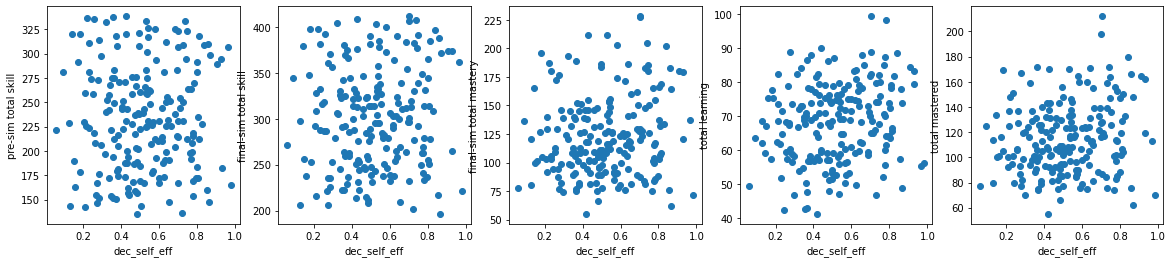

In [101]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'dec_self_eff'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

# Estimating Diligence

Estimators to compare
1. Frequency of Off-task
2. Total Time 
3. Start Speed (procrastination)
4. Early Finish (persistence)
5. 2 Measure
6. 3 Measure
7. 4 Measure
8. Diligence & Cog Measures
4. M4: Multiple Diligence Measures
5. M5: Multiple Diligence & Multiple Cognitive Measure instrument
6: M6: Multiple diligence & Cog measures + CAE measures.

Seed Model

* Measures of Cognition
    * AFM intercept
    * Total Skills mastered

* Measures of Diligence
    * Total Time  
    * Frequency of Off-task
    * Start Speed
    * Early Finish



## Helpers

In [29]:
def get_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


In [30]:
def get_tx_fields(sids, fields=None):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    if fields is None:
        return tx
    else:
        return tx.loc[:, fields]

In [31]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [32]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_step_accuracy(steps):
    steps['is_correct'] = steps['outcome'] == 'Correct'
    step_acc = steps.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x)).rename("step_accuracy")
    return step_acc
    

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("step_accuracy", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0, aggfunc=np.sum).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    d['time_on_task'] = d['time_on_task'] / 3600
    d['time_off_task'] = d['time_off_task'] / 3600
    return d

    
    


In [33]:
def get_student_sessions(sids):
    # Get login-logout transactions for students
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, "type": {"$in": ["SessionStart", "SessionEnd"]}}))
    ses_ids = tx['session_id'].unique().tolist()
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    tx = pd.merge(tx, sessions, on="session_id", how='inner')
    return tx

def calc_session_stats(sids):
    tx = get_student_sessions(sids)
    
    # Calc student-session stats
    session_stats = tx.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(tx.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']
    
    return session_stats

def calc_stu_session_stats(sids):
    session_stats = calc_session_stats(sids)
    stu_session_stats = session_stats.groupby('stu_id')['start speed', 'early finish', 'session length', 'pct class'].agg('mean', 'std')
    return stu_session_stats


def calc_student_dil_stats(sids):
    tx = get_tx(sid)
    tx = lbl_nondil_tx(tx)

    detect_offtask = calc_detected_offtask(tx)
    detect_guess = calc_detected_guess(tx)
    time_on_task = calc_time_on_task(tx)

    return pd.concat([detect_guess, detect_offtask, time_on_task], axis=1)



In [34]:
def calc_stats(ids):

    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)


    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    # Collect minimum steps information for running afm
    


    # Calculate student non-diligent stats
    detect_offtask = calc.calc_detected_offtask(tx)
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)


    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1)
    
    # Calculate accuracy
    step_accuracy = calc_step_accuracy(steps)
    
    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    steps = pd.merge(steps, d, on="kc", how="outer")
    steps['expected_duration'] = steps['Attempts'] * steps['m_time']
    exp_work_rate = steps.groupby('stu_id')['duration'].sum() / steps.groupby('stu_id')['expected_duration'].sum()

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean()

    # Fit line for each student tendency to request hint
    
    steps[['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'outcome', 'kc', 'opportunity']]
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    

    
    # Calculate detector error
    # Plot Detector vs ground truth
    tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
    tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
    tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
    tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)
    tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
    tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
    tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
    tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)
    

    ot_err = tx.groupby('stu_id')[['offtask_tp', 'offtask_fp', 'offtask_tn', 'offtask_fn']].sum()

    g_err = tx.groupby('stu_id')[['guess_tp', 'guess_fp', 'guess_tn', 'guess_fn']].sum()
#     logger.info("Calculated detector error counts")

#     total_stats = {}
#     total_stats['ot_tp'] = np.sum(tx['offtask_tp']) / tx.shape[0]
#     total_stats['ot_fp'] = np.sum(tx['offtask_fp']) / tx.shape[0]
#     total_stats['ot_tn'] = np.sum(tx['offtask_tn']) / tx.shape[0]
#     total_stats['ot_fn'] = np.sum(tx['offtask_fn']) / tx.shape[0]



#     total_stats['g_tp'] = np.sum(tx['guess_tp']) / tx.shape[0]
#     total_stats['g_fp'] = np.sum(tx['guess_fp']) / tx.shape[0]
#     total_stats['g_tn'] = np.sum(tx['guess_tn']) / tx.shape[0]
#     total_stats['g_fn'] = np.sum(tx['guess_fn']) / tx.shape[0]
#     det_err[desc] = total_stats

    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       ot_err, g_err], axis=1)
#     logger.info(f"Merged stats: {stats.shape}")
    return stats


In [35]:
def afm_stu_intercept(kcs, opps, actuals, stu, student_label, item_label, nfolds=3,
        seed=None):
    """
    Executes AFM on the provided data and returns model fits and parameter
    estimates
    """
    sv = DictVectorizer()
    qv = DictVectorizer()
    ov = DictVectorizer()

    S = sv.fit_transform(stu)
    Q = qv.fit_transform(kcs)
    O = ov.fit_transform(opps)

    X = hstack((S, Q, O))
    y = np.array(actuals)

    l2 = [1.0 for i in range(S.shape[1])]
    l2 += [0.0 for i in range(Q.shape[1])]
    l2 += [0.0 for i in range(O.shape[1])]

    bounds = [(None, None) for i in range(S.shape[1])]
    bounds += [(None, None) for i in range(Q.shape[1])]
    bounds += [(0, None) for i in range(O.shape[1])]

    X = X.toarray()
    X2 = Q.toarray()

    model = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)
    model.fit(X, y)

    coef_s = model.coef_[0:S.shape[1]]
    coef_s = [[k, v, invlogit(v)]
              for k, v in sv.inverse_transform([coef_s])[0].items()]

    return coef_s

In [36]:
def get_afm_steps(sids):
    tx = get_tx(sids)
    
    # Minimalist Rollup steps
    #Step outcome
    step_outcomes = tx.sort_values('time').groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['outcome'].first()
    # Get time stamp for last tx
    time = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['time'].agg(lambda x: x.sort_values().iloc[-1])
    steps = pd.concat([step_outcomes, time], axis=1)
    # Get kc
    steps = pd.merge(steps, tx.loc[:, ['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'kc' ]].drop_duplicates(), on=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], how='inner')
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    return steps

def run_afm(steps):
    # Format data for passing to afm
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    
    nfolds = 3
    seed = None
#     scores, kc_vals, coef_s = afm(kcs, opps, y, stu,
#                                   student_label, item_label, nfolds, seed)
    coef_s = afm_stu_intercept(kcs, opps, y, stu,
                                  student_label, item_label, nfolds, seed)
    stu_intercepts = pd.DataFrame(coef_s, columns=['stu_id', 'Intercept (logit)', 'Intercept (prob)'])
    stu_intercepts.index = stu_intercepts['stu_id']
    stu_intercepts.drop(columns=['stu_id'], inplace=True)
    return stu_intercepts

In [37]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [38]:
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer

from pyafm.util import invlogit
from pyafm.custom_logistic import CustomLogistic

## Setup 2

In [39]:
def get_split_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


def get_action_counts(tx):
    action_dist = tx.groupby('student_id')['action_type'].value_counts().reset_index(name="count")
    action_dist = action_dist.pivot_table(index='student_id', columns='action_type', values='count', fill_value=0)
    action_dist['total actions'] = action_dist.sum(axis=1)
    for col in action_dist.columns:
        if col != 'total actions':
            action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total actions'], axis=1)
            action_dist.head()

    return action_dist

def total_tx_stats(tx):

    # Total Transaction counts
    stu_stats = tx.groupby('stu_id').agg({'_id': 'count',
                                          'duration': np.sum,
                                         })
    stu_stats.rename(columns={'_id': "Total Tx",
                              'duration': 'Total Time'},
                              inplace = True)
    stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
    logger.debug("Number of students: %i" % stu_stats.shape[0])
    logger.debug(stu_stats["Total Tx"].describe())

    # Total of each outcome
    d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot_table(
            index='stu_id', columns='outcome', values='_id', fill_value=0)

    # Prorporation of each outcome
    stu_stats = pd.concat([stu_stats, d], axis=1)
    stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
    stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
    stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']

    return stu_stats

def calc_stu_session_stats(tx):
    session_stats = calc_session_stats(tx)
    stu_session_stats = session_stats.groupby('stu_id')[['start speed', 'early finish', 'session length', 'pct class']].agg('mean', 'std')
    stu_session_stats['total opportunity'] = session_stats.groupby('stu_id')['session length'].sum()
    return stu_session_stats


def get_student_sessions(tx):
    ses_ids = tx['session_id'].unique().tolist()
    sids = tx['stu_id'].unique().tolist()
    # Get login-logout transactions for students
    d = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 
                                         "type": {"$in": ["SessionStart", "SessionEnd"]}, 
                                         'session_id': {"$in": ses_ids}}))
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    d = pd.merge(d, sessions, on="session_id", how='inner')
    return d


def calc_session_stats(tx):
    d = get_student_sessions(tx)

    # Calc student-session stats
    session_stats = d.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(d.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']

    return session_stats




In [40]:
def calc_expected_work_rate(steps):
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    d = pd.merge(steps, d, on="kc", how="outer")
    d['expected_duration'] = d['Attempts'] * d['m_time']
    exp_work_rate = d.groupby('stu_id')['duration'].sum() / d.groupby('stu_id')['expected_duration'].sum()
    return exp_work_rate


In [41]:
def rand_split(x):
    k = int(len(x)/2)
    s1 = random.sample(x.tolist(), k)
    return x.apply(lambda d: 0 if d in s1 else 1)
    

In [42]:
def calc_stu_stats(ids):
    
    # Get all tx
    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)
    
    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)

    # Calculate student non-diligent stats
    detect_offtask = calc.calc_detected_offtask(tx)
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)


    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1).rename("over_practice")
#     kc_prac.columns = [f"{col}_practice" for col in kc_prac.columns.tolist()]

    # Calculate accuracy
    step_accuracy = calc_step_accuracy(steps)

    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    exp_work_rate = calc_expected_work_rate(steps)

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean().unstack()
#     stu_level_hints.columns = [f"{col}_mean_num_hints" for col in stu_level_hints.columns.tolist()]
    
    # Action stats
    action_dist = get_action_counts(tx)
#     action_dist.index = action_dist.index.swaplevel()
    
    # Total Tx Stats
    tx_stats = total_tx_stats(tx)
#     tx_stats.index = tx_stats.index.swaplevel()
    
    # Session stats
    ses_stats = calc_stu_session_stats(tx)
#     ses_stats.index = ses_stats.index.swaplevel()
    
    
    
    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       stu_level_hints, action_dist, tx_stats, ses_stats], axis=1)

    return stats
    

## Calculate Stats

In [43]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
tx_lblr = TransactionAnnotator(db)
step_calc = StepCalculator(db)
tx_calc = TransactionCalculator(db)
session_calc = SessionCalculator(db)

In [44]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
               "Self-Efficacy students",
               "Intrinsic Interest students",
               "Combo students"
              ]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.session:batch #0: 
ID: e78af8cb-a4e4-4a0a-aa86-87807a44ca92
desc: Simple diligent students
INFO:analytics.session:recovered 200 student ids for batch Simple diligent students
INFO:analytics.session:batch #1: 
ID: 3e121e37-188a-4773-9a79-69aeacb4936f
desc: Self-Efficacy students
INFO:analytics.session:recovered 200 student ids for batch Self-Efficacy students
INFO:analytics.session:batch #2: 
ID: 84f30927-b810-4f2f-8051-517fcc8b6ebd
desc: Intrinsic Interest students
INFO:analytics.session:recovered 200 student ids for batch Intrinsic Interest students
INFO:analytics.session:batch #3: 
ID: 46dbe5d7-655b-4d1f-9481-63d6dba7614f
desc: Combo students
INFO:analytics.session:recovered 200 student ids for batch Combo students


In [47]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
det_err = {desc: {} for desc in batch_descs}
logger.info("Starting calculation")

batch_size = 10
for desc in batch_descs:
    ids = sids[desc][0]
    logger.info(f"EDA of {len(ids)} students for batch, {desc}")
    
    
    def calc_all_stats(sids):
        d = calc_stu_stats(sids)
#         d.index.rename("stu_id", level=0, inplace=True)
#         d.index.rename("split_half", level=1, inplace=True)

        args = [get_stu_parameters, sids, batch_size, [mastery_thres]]
        sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#         logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
        sim_students.index.rename("stu_id", inplace=True)

        result = pd.merge(sim_students, d, left_index=True, right_index=True)

#         logger.info(f"Completed calculating and merging stats: {result.shape}")
        return result
    
    args = [calc_all_stats, ids, batch_size]
    stu_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student stats: {stu_stats[desc].shape}\tRuntime: {runtime} seconds")
    
    


INFO:analytics.session:Starting calculation
INFO:analytics.session:EDA of 200 students for batch, Simple diligent students
INFO:analytics.session:Calculated student stats: (200, 63)	Runtime: 406.34281 seconds
INFO:analytics.session:EDA of 200 students for batch, Self-Efficacy students
INFO:analytics.session:Calculated student stats: (200, 63)	Runtime: 424.249106 seconds
INFO:analytics.session:EDA of 200 students for batch, Intrinsic Interest students
INFO:analytics.session:Calculated student stats: (200, 64)	Runtime: 406.459568 seconds
INFO:analytics.session:EDA of 200 students for batch, Combo students
INFO:analytics.session:Calculated student stats: (200, 64)	Runtime: 419.221054 seconds


In [48]:

# stu_stats = {desc: {} for desc in batch_descs}
# mastery_thres = 0.9
# stu_prob_stats = {desc: {} for desc in batch_descs}
# kc_stats = {desc: {} for desc in batch_descs}
# det_err = {desc: {} for desc in batch_descs}
# logger.info("Starting calculation")
# for desc in batch_descs:

#     # Temporarily use only the first 100 out of 1000 students for speed of analysis
#     sid = sids[desc][0][:100]
#     logger.info(f"EDA of {len(sid)} students for batch, {desc}")

#     logger.info(f"Calculating for student set:\t{desc}")
#     args = [get_stu_parameters, sid, 50, [mastery_thres]]
#     sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

#     args = [calc.get_action_counts, sid, 50]
#     action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

#     args = [calc.total_tx_stats, sid, 50]
#     tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")


#     args = [session_calc.calc_stu_session_stats, sid, 50]
#     ses_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student session stats: {ses_stats.shape}\tRuntime: {runtime} seconds")

#     args = [calc_stats, sid, 50]
#     dil_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated diligence stats: {dil_stats.shape}\tRuntime: {runtime} seconds")

#     args = [get_afm_steps, sid, 50]
#     afm_steps, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated Step rollup for afm: {afm_steps.shape}\tRuntime: {runtime} seconds")

# #    stu_afm = run_afm(afm_steps)
#     stu_afm, runtime = batch_calc.time_calc(run_afm, [afm_steps])
#     logger.info(f"Calculated afm intercepts: {stu_afm.shape}\tRuntime: {runtime} seconds")


#     stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, ses_stats, 
#                                  dil_stats, stu_afm], axis=1)
#     logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


In [116]:
# Align direction of measures and scale
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish', "Pct Hint"]
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1, 'Pct Hint': -1}
for i, desc in enumerate(batch_descs):
    logger.info(f"Aligning columns for student sim: {desc}")
    ss = stu_stats[desc]
    for m in measures:
        d = ss[m]
        stu_stats[desc][scaled_measures[m]] = align_measures[m] * (d - d.mean())/d.std() 

logger.info(f"Added new columns: {scaled_measures.values()}")

INFO:analytics.session:Aligning columns for student sim: Simple diligent students
INFO:analytics.session:Aligning columns for student sim: Self-Efficacy students
INFO:analytics.session:Aligning columns for student sim: Intrinsic Interest students
INFO:analytics.session:Aligning columns for student sim: Combo students
INFO:analytics.session:Added new columns: dict_values(['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish', 'align Pct Hint'])


## Compare Estimators

In [ ]:
# Dataframe to store correlation results

### Correlation Matrix of Measures

In [112]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish', "Pct Hint"]
scaled_measures = [f"align {m}" for m in measures]
cor_mat = {desc: pd.DataFrame(index=scaled_measures, columns = scaled_measures) for desc in batch_descs}
for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    for m_i in scaled_measures:
        for m_j in scaled_measures:
            corr, pval = pearsonr(ss[m_i],ss[m_j])
            cor_mat[desc].loc[m_i, m_j] = corr
    logger.info(f"\n{cor_mat[desc]}")

        

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:
                   align pct class align Pct OffTask align start speed  \
align pct class                  1          0.507655          0.645885   
align Pct OffTask         0.507655                 1          0.502953   
align start speed         0.645885          0.502953                 1   
align early finish        0.869439           0.37699          0.266423   
align Pct Hint          -0.0935384        -0.0101737         -0.112836   

                   align early finish align Pct Hint  
align pct class              0.869439     -0.0935384  
align Pct OffTask             0.37699     -0.0101737  
align start speed            0.266423      -0.112836  
align early finish                  1     -0.0605204  
align Pct Hint             -0.0605204              1  
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:
                   align pct class al

### M1: Freq of Off-task

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Correlation with Diligence: R = 0.6301249729608928	 pval = 1.5765575571557978e-23
INFO:analytics.session:Correlation with Diligence: R = -0.1912587698460384	 pval = 0.006668838389627983
INFO:analytics.session:Correlation with Cog Ability: R = -0.19292119752443943	 pval = 0.0062006812972999386
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Correlation with Diligence: R = 0.5996052888339269	 pval = 6.531639212235288e-21
INFO:analytics.session:Correlation with Diligence: R = -0.04482302852501659	 pval = 0.528539575448734
INFO:analytics.session:Correlation with Cog Ability: R = -0.26299378196756307	 pval = 0.00016827034534125894
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Correlation with Diligence: R = 0.5391242140590569	 pval = 1.782873285595632e-16
INFO:analytics.session:Correlation with Diligence:

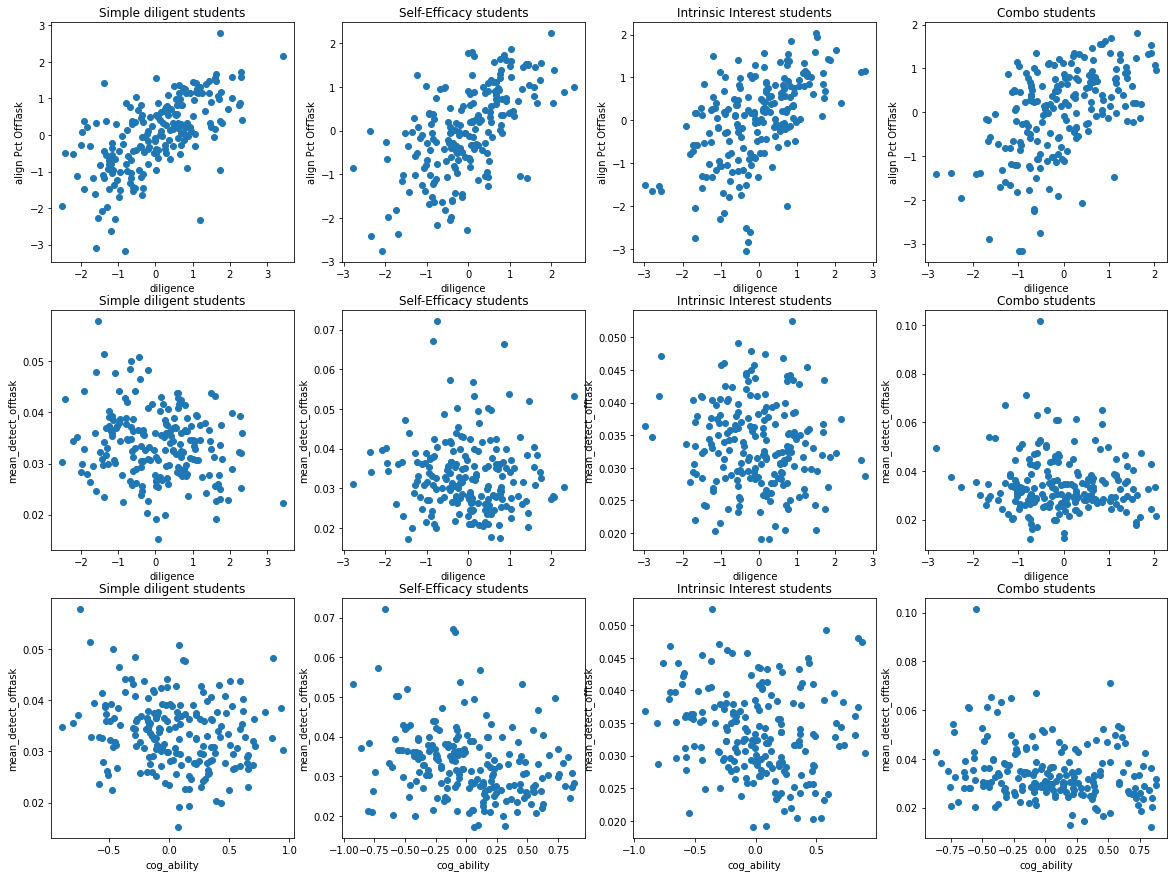

In [51]:
n = len(batch_descs)
plt.figure(figsize=(5*n,15))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]

    xcol = "diligence"
    ycol = "align Pct OffTask"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "diligence"
    ycol = "mean_detect_offtask"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    ycol = "mean_detect_offtask"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,2*n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M2: Total Time

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Correlation with Diligence: R = 0.7222485062884919	 pval = 1.541249777692055e-33
INFO:analytics.session:Correlation with Diligence: R = 0.4171848353496071	 pval = 7.975289014733454e-10
INFO:analytics.session:Correlation with Cog Ability: R = -0.3951220247474961	 pval = 7.030789784897323e-09
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Correlation with Diligence: R = 0.6060018388374114	 pval = 1.9485127241739574e-21
INFO:analytics.session:Correlation with Diligence: R = 0.3029629543582368	 pval = 1.2969978458808702e-05
INFO:analytics.session:Correlation with Cog Ability: R = -0.23967392250209027	 pval = 0.0006303354693084522
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Correlation with Diligence: R = 0.558122047640453	 pval = 8.997703884568577e-18
INFO:analytics.session:Correlation with Diligence:

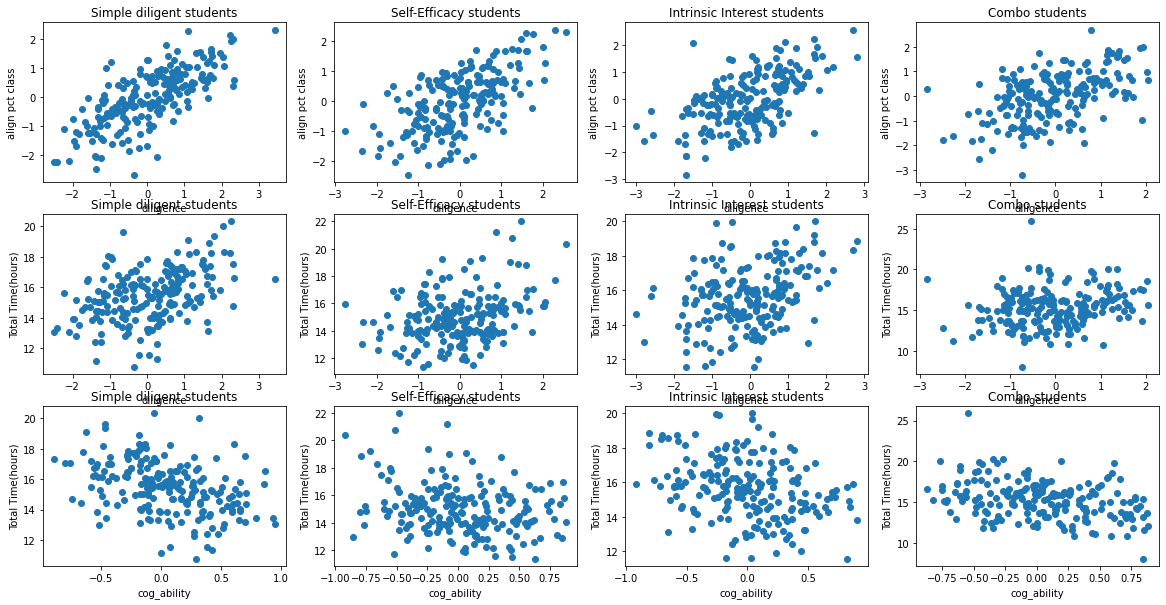

In [52]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    
    xcol = "diligence"
    ycol = "align pct class"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "diligence"
    ycol = "Total Time(hours)"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,2*n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M3: Time-on-task

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = 0.5383875722428042	 pval = 1.9942455123730497e-16
INFO:analytics.session:Correlation with Cog Ability: R = -0.24294383761185137	 pval = 0.0005276994081779385
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.5256909285496039	 pval = 1.3185213755875427e-15
INFO:analytics.session:Correlation with Cog Ability: R = -0.0614890713236973	 pval = 0.38706349410489854
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = 0.40924851901168036	 pval = 1.7771371591922477e-09
INFO:analytics.session:Correlation with Cog Ability: R = -0.10838560210078324	 pval = 0.12658699425424366
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = 0.37498716819573513	 pval = 4.479409387528098e-08
INFO:analytics.session:Correlation with Cog Ability: R = -0.12289243370323936	 pval = 0.082981042

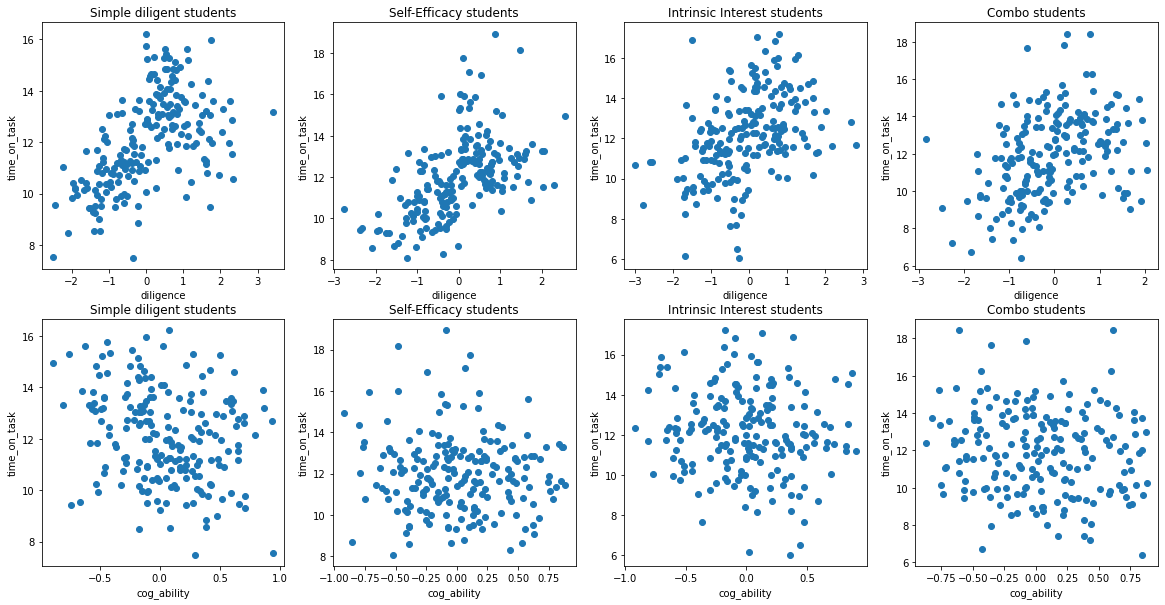

In [53]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "time_on_task"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M4: Start Speed

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = 0.6123218292867311	 pval = 5.740055216940869e-22
INFO:analytics.session:Correlation with Cog Ability: R = -0.05486442146925512	 pval = 0.44034064015069857
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.5629711567666104	 pval = 4.070585749208235e-18
INFO:analytics.session:Correlation with Cog Ability: R = 0.06084808249758617	 pval = 0.392041211293329
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = 0.3183655207767785	 pval = 4.3430024679166975e-06
INFO:analytics.session:Correlation with Cog Ability: R = -0.005768256213039021	 pval = 0.9353904061513629
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = 0.3954273251286763	 pval = 6.829502461670335e-09
INFO:analytics.session:Correlation with Cog Ability: R = 0.007566815088781326	 pval = 0.9153112497348946


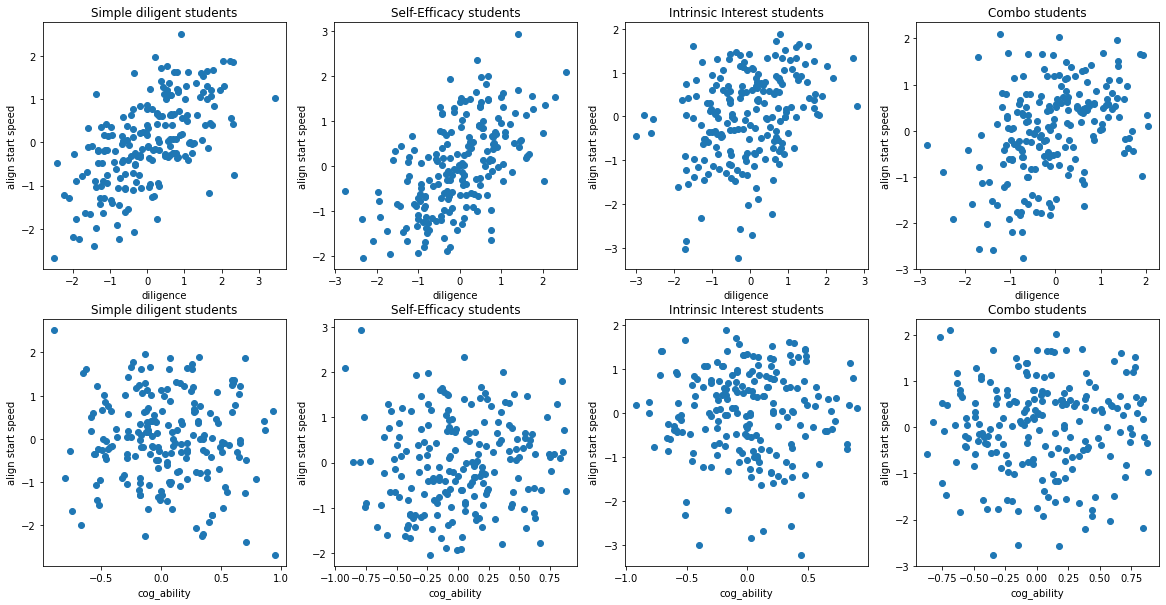

In [54]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "align start speed"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M5: Early Finish

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = 0.6027994862626441	 pval = 3.582377949179541e-21
INFO:analytics.session:Correlation with Cog Ability: R = -0.05247587663367238	 pval = 0.4605278345344031
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.4085913295087172	 pval = 1.89727576217797e-09
INFO:analytics.session:Correlation with Cog Ability: R = 0.10742232442132243	 pval = 0.13001487121047525
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = 0.49094639784791677	 pval = 1.576754012155863e-13
INFO:analytics.session:Correlation with Cog Ability: R = 0.1147912067060521	 pval = 0.1055393465556886
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = 0.4045821939381178	 pval = 2.8191153829664986e-09
INFO:analytics.session:Correlation with Cog Ability: R = 0.03319906035489858	 pval = 0.6407206737888861


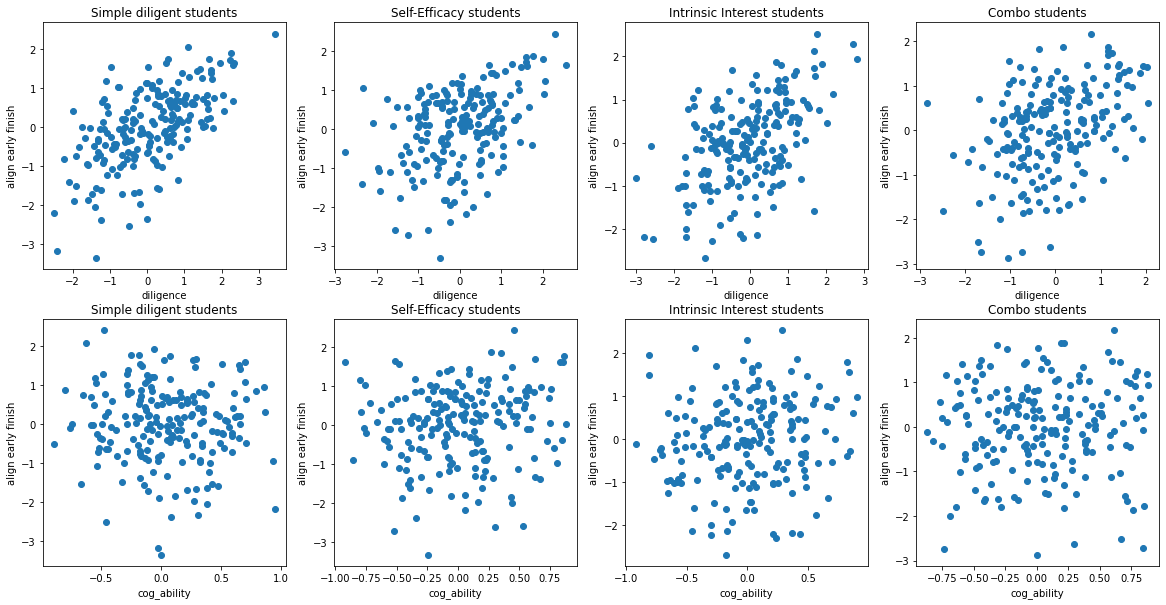

In [55]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "align early finish"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M6: Pct Hint

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = -0.13918207128676713	 pval = 0.049348119833475416
INFO:analytics.session:Correlation with Cog Ability: R = 0.9104530134110395	 pval = 7.566601887370321e-78
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.11871976108241462	 pval = 0.09406107208701565
INFO:analytics.session:Correlation with Cog Ability: R = 0.6371022049095579	 pval = 3.613095122426222e-24
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = -0.04991362483194399	 pval = 0.48274253049199817
INFO:analytics.session:Correlation with Cog Ability: R = 0.9340542720725137	 pval = 1.7468159066680885e-90
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = -0.03581115894798957	 pval = 0.614659619059383
INFO:analytics.session:Correlation with Cog Ability: R = 0.6198630284610603	 pval = 1.2875725077081045e-

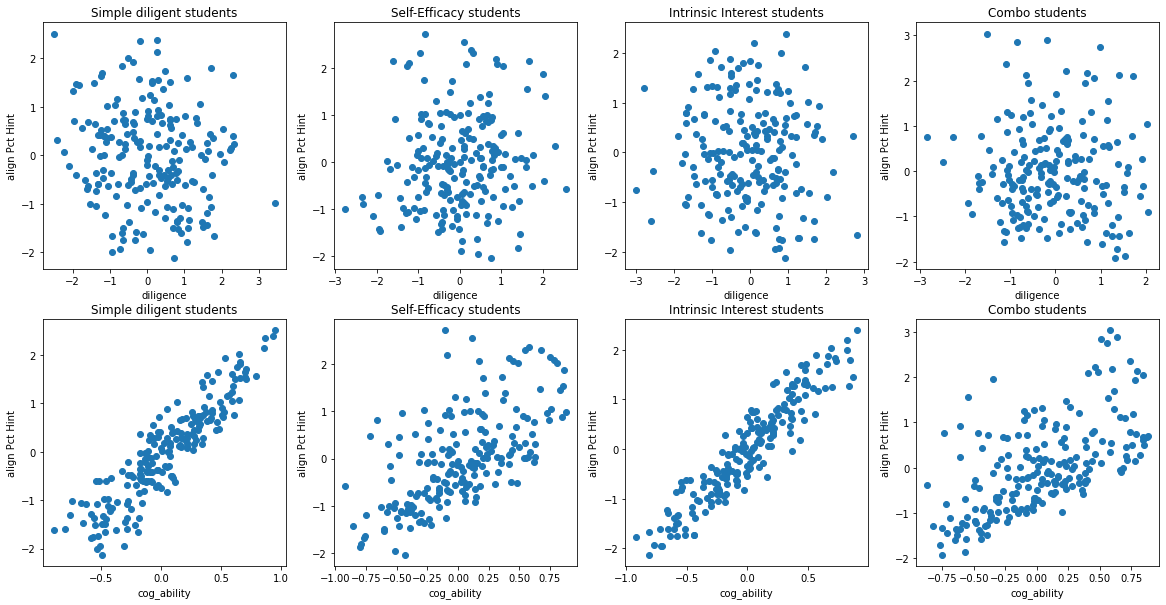

In [113]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "align Pct Hint"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### Multi-Diligence Measures

In [56]:
from itertools import combinations 


#### Measures with noise

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851654
INFO:analytics.session:EigenValues: [1.27588881 0.72411119]
INFO:analytics.session:Factor Loadings: [[0.52525119]
 [0.52525119]]
INFO:analytics.session:Factor Variance: (array([0.55177763]), array([0.27588881]), array([0.27588881]))
INFO:analytics.session:Factor loadings: Total Time(hours)      0.525251
mean_detect_offtask    0.525251
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.4159781418110653	 pval = 9.020737754442817e-10
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy st

Created 6 Combinations of length 2


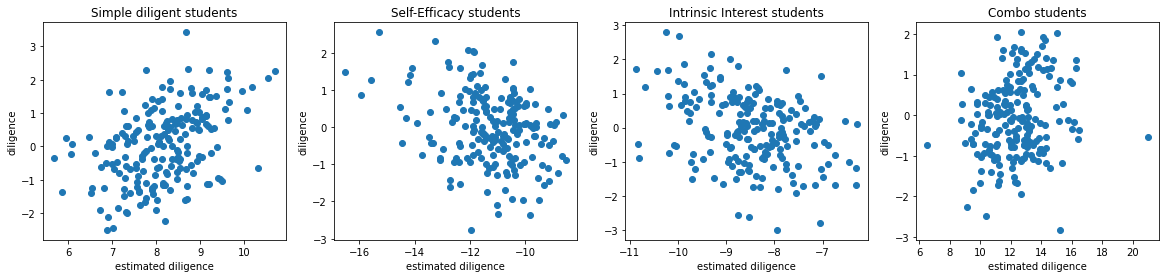

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785167
INFO:analytics.session:EigenValues: [1.41436991 0.58563009]
INFO:analytics.session:Factor Loadings: [[-0.64371571]
 [ 0.64371571]]
INFO:analytics.session:Factor Variance: (array([0.82873982]), array([0.41436991]), array([0.41436991]))
INFO:analytics.session:Factor loadings: Total Time(hours)   -0.643716
start speed          0.643716
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5847924485565823	 pval = 9.71628325604517e-20
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO

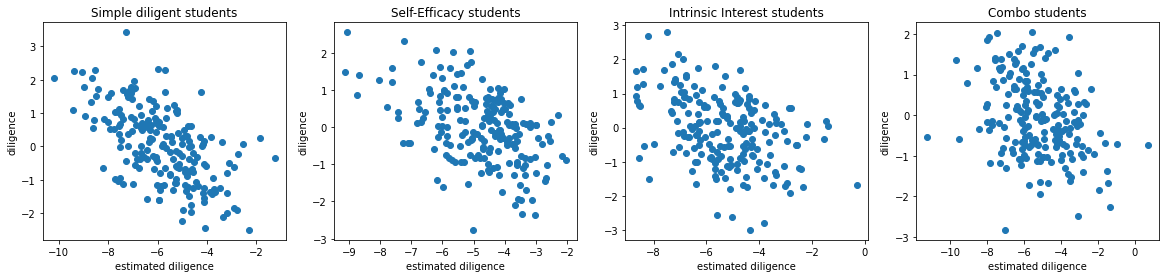

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851676
INFO:analytics.session:EigenValues: [1.60018814 0.39981186]
INFO:analytics.session:Factor Loadings: [[-0.7747181]
 [ 0.7747181]]
INFO:analytics.session:Factor Variance: (array([1.20037628]), array([0.60018814]), array([0.60018814]))
INFO:analytics.session:Factor loadings: Total Time(hours)   -0.774718
early finish         0.774718
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5788105331752385	 pval = 2.781363018084233e-19
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INF

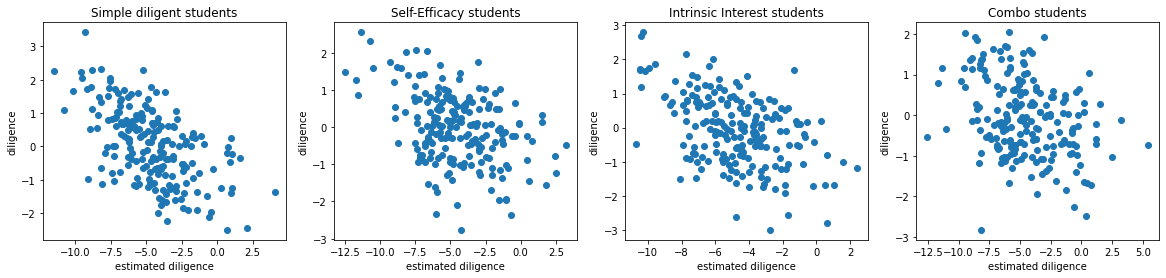

INFO:analytics.session:Comparing models with columns: ('mean_detect_offtask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785181
INFO:analytics.session:EigenValues: [1.06310791 0.93689209]
INFO:analytics.session:Factor Loadings: [[0.25121288]
 [0.25121288]]
INFO:analytics.session:Factor Variance: (array([0.12621583]), array([0.06310791]), array([0.06310791]))
INFO:analytics.session:Factor loadings: mean_detect_offtask    0.251213
start speed            0.251213
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6132034817060114	 pval = 4.829710555680505e-22
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students

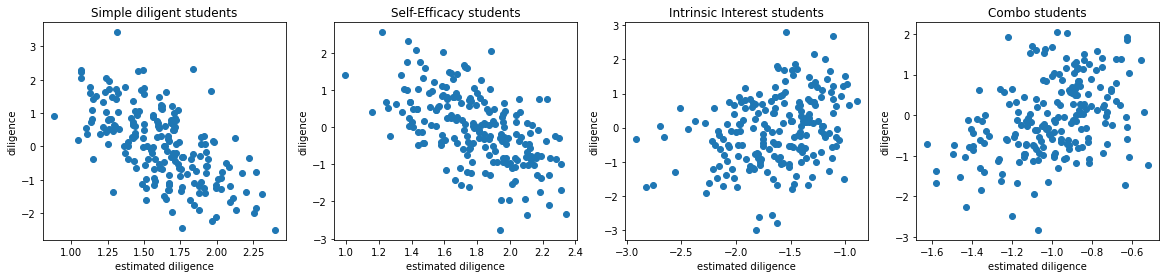

INFO:analytics.session:Comparing models with columns: ('mean_detect_offtask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785119
INFO:analytics.session:EigenValues: [1.07377327 0.92622673]
INFO:analytics.session:Factor Loadings: [[-0.27161236]
 [-0.27161236]]
INFO:analytics.session:Factor Variance: (array([0.14754655]), array([0.07377328]), array([0.07377328]))
INFO:analytics.session:Factor loadings: mean_detect_offtask   -0.271612
early finish          -0.271612
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6032791980237184	 pval = 3.271473415915758e-21
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy studen

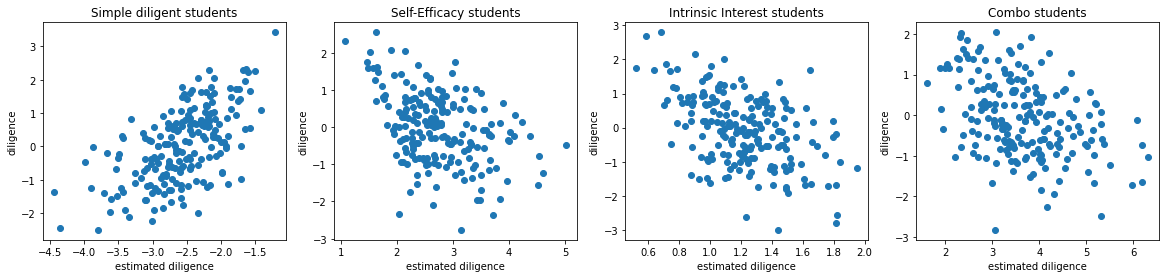

INFO:analytics.session:Comparing models with columns: ('start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851687
INFO:analytics.session:EigenValues: [1.26642324 0.73357676]
INFO:analytics.session:Factor Loadings: [[-0.51616203]
 [-0.51616203]]
INFO:analytics.session:Factor Variance: (array([0.53284648]), array([0.26642324]), array([0.26642324]))
INFO:analytics.session:Factor loadings: start speed    -0.516162
early finish   -0.516162
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7451349715679609	 pval = 1.108891856916664e-36
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.ses

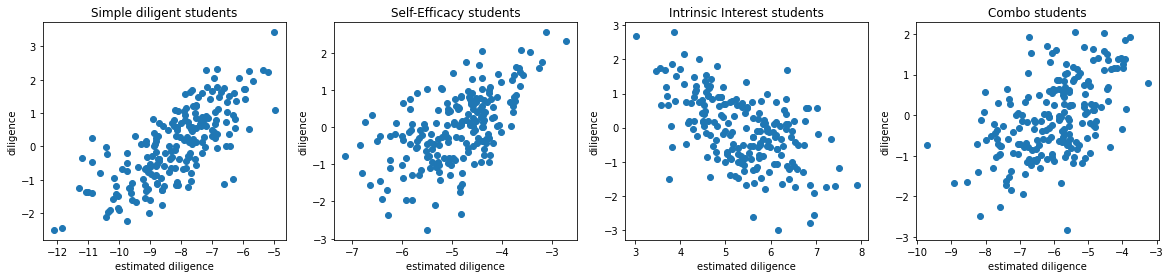

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.41299821840268797
INFO:analytics.session:EigenValues: [1.47022822 1.05808162 0.47169016]
INFO:analytics.session:Factor Loadings: [[-1.00936169]
 [-0.21895547]
 [ 0.37912425]]
INFO:analytics.session:Factor Variance: (array([1.21048772]), array([0.40349591]), array([0.40349591]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -1.009362
mean_detect_offtask   -0.218955
start speed            0.379124
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.506598450832095	 pval = 1.9539832177081865e-14
INFO:analytics.session:**************************************

Created 4 Combinations of length 3


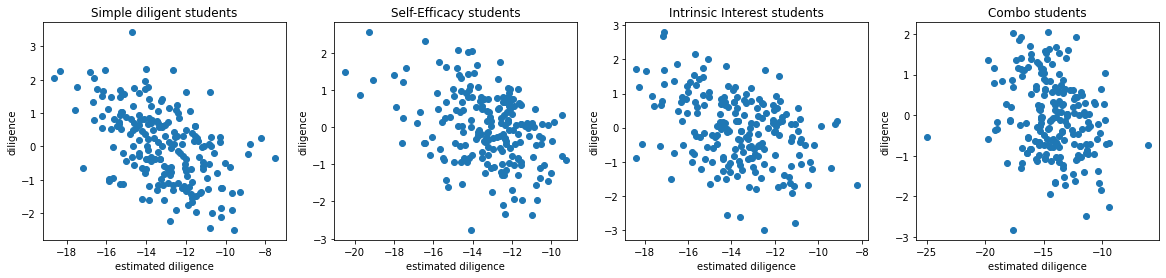

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.39244806093875123
INFO:analytics.session:EigenValues: [1.6350687  1.05569312 0.30923818]
INFO:analytics.session:Factor Loadings: [[-1.01419473]
 [-0.17730363]
 [ 0.56189609]]
INFO:analytics.session:Factor Variance: (array([1.37575474]), array([0.45858491]), array([0.45858491]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -1.014195
mean_detect_offtask   -0.177304
early finish           0.561896
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5461311101751244	 pval = 6.057459619750072e-17
INFO:analytics.session:*************************************

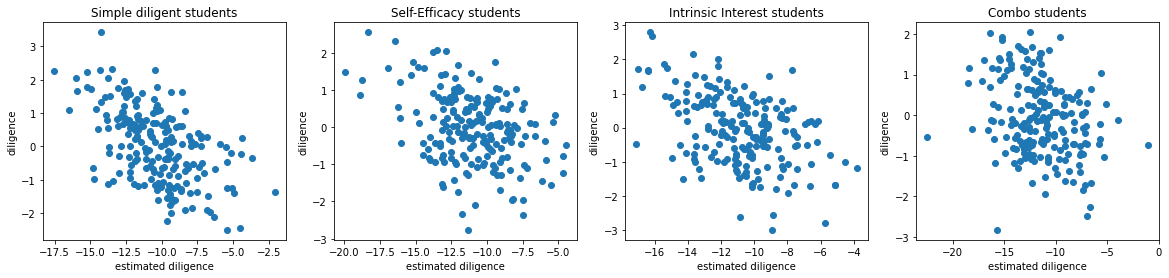

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5862344480452213
INFO:analytics.session:EigenValues: [1.86912771 0.75615146 0.37472083]
INFO:analytics.session:Factor Loadings: [[-0.96616718]
 [ 0.42888037]
 [ 0.62120555]]
INFO:analytics.session:Factor Variance: (array([1.50331373]), array([0.50110458]), array([0.50110458]))
INFO:analytics.session:Factor loadings: Total Time(hours)   -0.966167
start speed          0.428880
early finish         0.621206
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6167686870731148	 pval = 2.389170817639854e-22
INFO:analytics.session:***************************************************


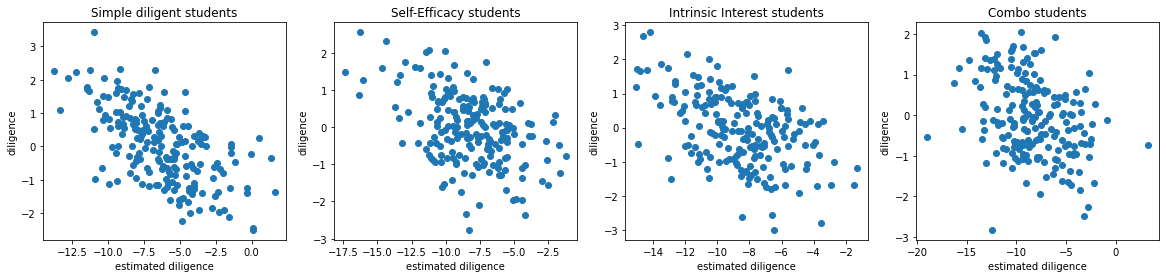

INFO:analytics.session:Comparing models with columns: ('mean_detect_offtask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.515816573995454
INFO:analytics.session:EigenValues: [1.29788322 0.96876836 0.73334842]
INFO:analytics.session:Factor Loadings: [[-0.13219251]
 [-0.47740026]
 [-0.55806898]]
INFO:analytics.session:Factor Variance: (array([0.55682685]), array([0.18560895]), array([0.18560895]))
INFO:analytics.session:Factor loadings: mean_detect_offtask   -0.132193
start speed           -0.477400
early finish          -0.558069
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7358380100469475	 pval = 2.296304264496414e-35
INFO:analytics.session:**********************************************

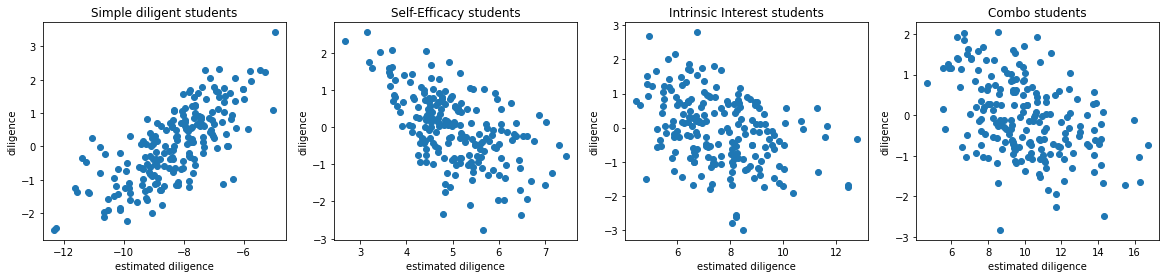

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4425187476323818
INFO:analytics.session:EigenValues: [1.88177116 1.09612875 0.74768624 0.27441385]
INFO:analytics.session:Factor Loadings: [[-1.0097898 ]
 [-0.13707082]
 [ 0.4097519 ]
 [ 0.5845011 ]]
INFO:analytics.session:Factor Variance: (array([1.54800201]), array([0.3870005]), array([0.3870005]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -1.009790
mean_detect_offtask   -0.137071
start speed            0.409752
early finish           0.584501
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6081474127354276	 pval = 1.2907262838

Created 1 Combinations of length 4


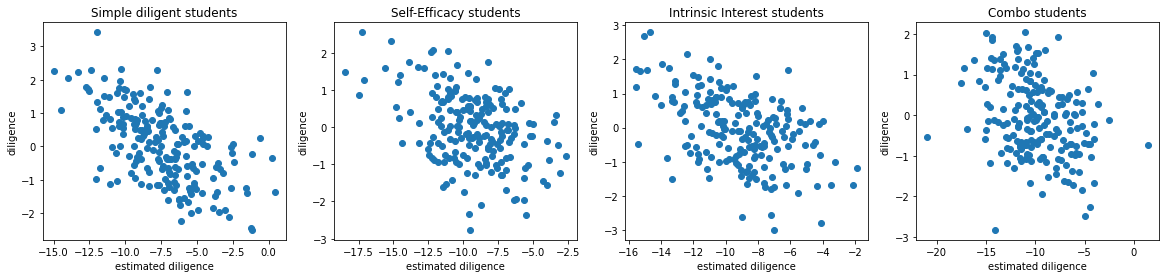

In [57]:
dil_factors = ['Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish']


for r in range(2,len(dil_factors)+1):
    dil_combos = list(combinations(dil_factors, r))
    print(f"Created {len(dil_combos)} Combinations of length {r}")
    for combo in dil_combos:
        n = len(batch_descs)
        plt.figure(figsize=(5*n,4))
        logger.info(f"Comparing models with columns: {combo}")
        for i, desc in enumerate(batch_descs):
            logger.info("***************************************************")
            logger.info(f"Comparing student sim: {desc}")
            ss = stu_stats[desc]
        #    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

            xcols = combo
            ycol = "diligence"
            #Factor analysis
            df = ss.loc[:,xcols]
            kmo_all, kmo_model = calculate_kmo(df)
            logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
            fa = FactorAnalyzer(rotation=None,  n_factors=1)
            fa.fit(df)
            # Check Eigenvalues
            ev, v = fa.get_eigenvalues()
            logger.info(f"EigenValues: {ev}")
            logger.info(f"Factor Loadings: {fa.loadings_}")
            logger.info(f"Factor Variance: {fa.get_factor_variance()}")

            loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
            logger.info(f"Factor loadings: {loadings}")
            X = df.mul(loadings).apply('sum', axis=1)
            logger.info(X.shape)
            Y = ss[ycol]
            corr, pval = pearsonr(X,Y)
            logger.info("******************* Pearson ********************")
            logger.info(f"R = {corr}\t pval = {pval}")

            plt.subplot(1,n,i+1)
            plt.scatter(X, Y)
            plt.title(desc)
            plt.xlabel("estimated diligence")
            plt.ylabel(ycol)
        plt.show()

#### Measures with no noise

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851643
INFO:analytics.session:EigenValues: [1.50765515 0.49234485]
INFO:analytics.session:Factor Loadings: [[-0.71249923]
 [ 0.71249923]]
INFO:analytics.session:Factor Variance: (array([1.01531031]), array([0.50765516]), array([0.50765516]))
INFO:analytics.session:Factor loadings: pct class     -0.712499
Pct OffTask    0.712499
dtype: float64

Created 10 Combinations of length 2


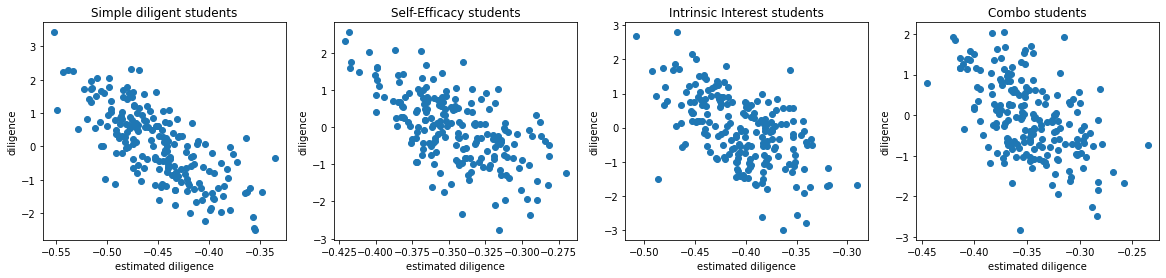

INFO:analytics.session:Comparing models with columns: ('pct class', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785163
INFO:analytics.session:EigenValues: [1.64588517 0.35411483]
INFO:analytics.session:Factor Loadings: [[-0.80366981]
 [ 0.80366981]]
INFO:analytics.session:Factor Variance: (array([1.29177033]), array([0.64588517]), array([0.64588517]))
INFO:analytics.session:Factor loadings: pct class     -0.80367
start speed    0.80367
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6280046945872375	 pval = 2.448730000239927e-23
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Ov

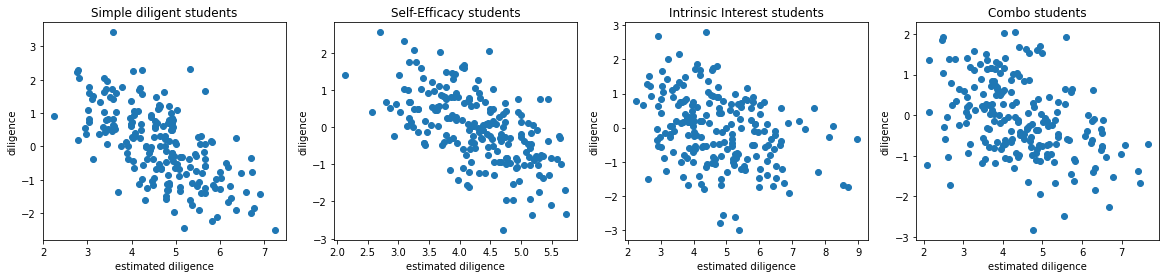

INFO:analytics.session:Comparing models with columns: ('pct class', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785167
INFO:analytics.session:EigenValues: [1.86943924 0.13056076]
INFO:analytics.session:Factor Loadings: [[-0.93243726]
 [ 0.93243726]]
INFO:analytics.session:Factor Variance: (array([1.73887849]), array([0.86943924]), array([0.86943924]))
INFO:analytics.session:Factor loadings: pct class      -0.932437
early finish    0.932437
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6082887483750019	 pval = 1.2560411771871929e-21
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sess

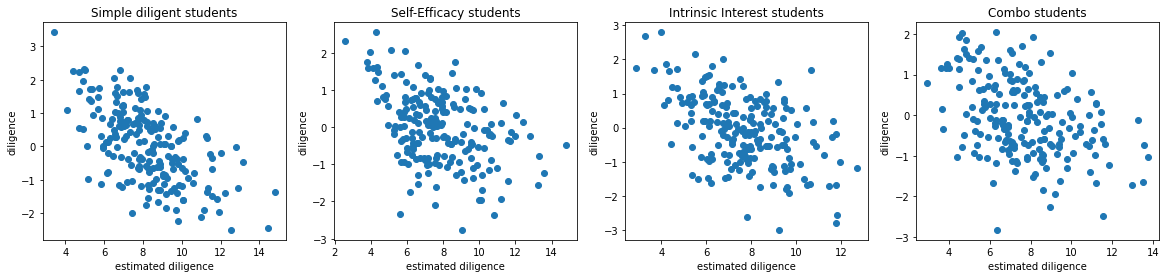

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785161
INFO:analytics.session:EigenValues: [1.0935384 0.9064616]
INFO:analytics.session:Factor Loadings: [[0.30584049]
 [0.30584049]]
INFO:analytics.session:Factor Variance: (array([0.1870768]), array([0.0935384]), array([0.0935384]))
INFO:analytics.session:Factor loadings: pct class    0.30584
Pct Hint     0.30584
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6960638226499618	 pval = 2.620375172777706e-30
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Overall Model Kai

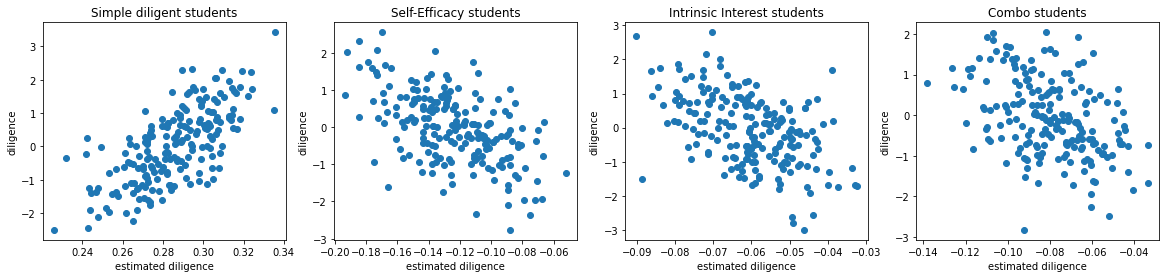

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785169
INFO:analytics.session:EigenValues: [1.50295273 0.49704727]
INFO:analytics.session:Factor Loadings: [[-0.7091916]
 [-0.7091916]]
INFO:analytics.session:Factor Variance: (array([1.00590546]), array([0.50295273]), array([0.50295273]))
INFO:analytics.session:Factor loadings: Pct OffTask   -0.709192
start speed   -0.709192
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.612764073952666	 pval = 5.264138315047139e-22
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Ov

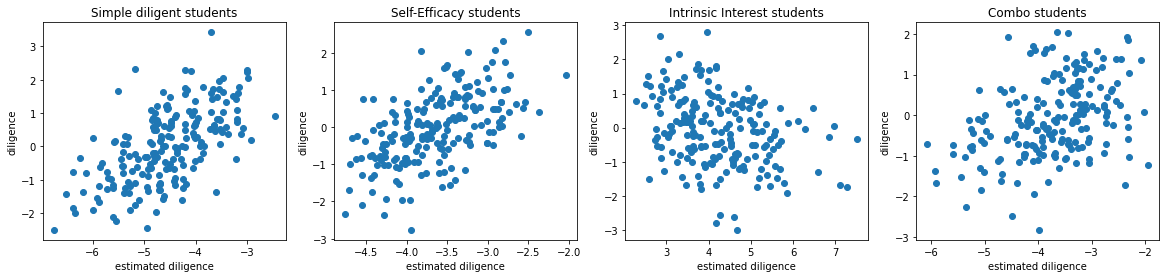

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785168
INFO:analytics.session:EigenValues: [1.37699033 0.62300967]
INFO:analytics.session:Factor Loadings: [[-0.61399538]
 [-0.61399538]]
INFO:analytics.session:Factor Variance: (array([0.75398066]), array([0.37699033]), array([0.37699033]))
INFO:analytics.session:Factor loadings: Pct OffTask    -0.613995
early finish   -0.613995
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.603111021890974	 pval = 3.377330206948799e-21
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sessi

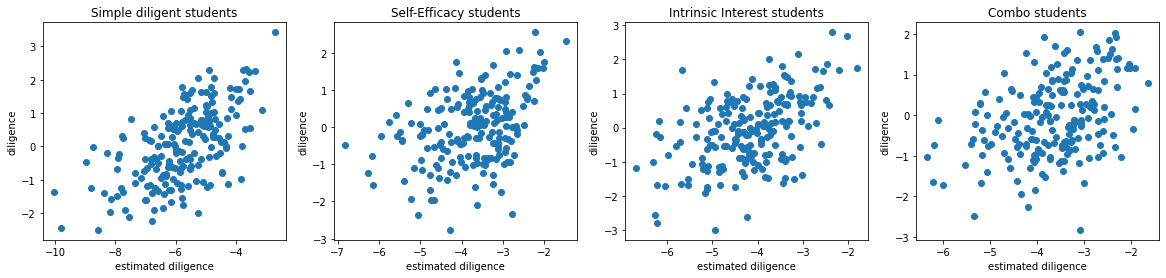

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007853536
INFO:analytics.session:EigenValues: [1.01017369 0.98982631]
INFO:analytics.session:Factor Loadings: [[-0.10086473]
 [ 0.10086473]]
INFO:analytics.session:Factor Variance: (array([0.02034739]), array([0.01017369]), array([0.01017369]))
INFO:analytics.session:Factor loadings: Pct OffTask   -0.100865
Pct Hint       0.100865
dtype: float64


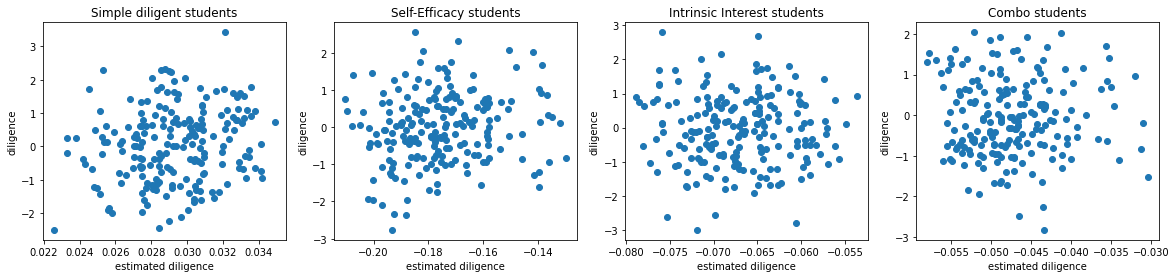

INFO:analytics.session:Comparing models with columns: ('start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851687
INFO:analytics.session:EigenValues: [1.26642324 0.73357676]
INFO:analytics.session:Factor Loadings: [[-0.51616203]
 [-0.51616203]]
INFO:analytics.session:Factor Variance: (array([0.53284648]), array([0.26642324]), array([0.26642324]))
INFO:analytics.session:Factor loadings: start speed    -0.516162
early finish   -0.516162
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7451349715679609	 pval = 1.108891856916664e-36
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.ses

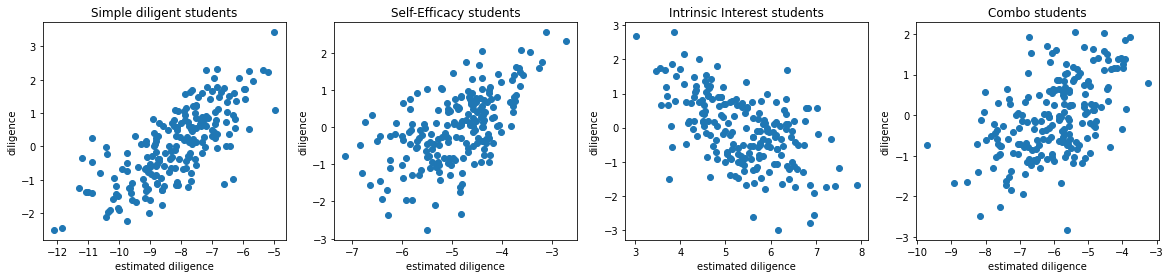

INFO:analytics.session:Comparing models with columns: ('start speed', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.497493750078517
INFO:analytics.session:EigenValues: [1.11283578 0.88716422]
INFO:analytics.session:Factor Loadings: [[-0.33591037]
 [ 0.33591037]]
INFO:analytics.session:Factor Variance: (array([0.22567156]), array([0.11283578]), array([0.11283578]))
INFO:analytics.session:Factor loadings: start speed   -0.33591
Pct Hint       0.33591
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6136958231999665	 pval = 4.384693828600883e-22
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Overa

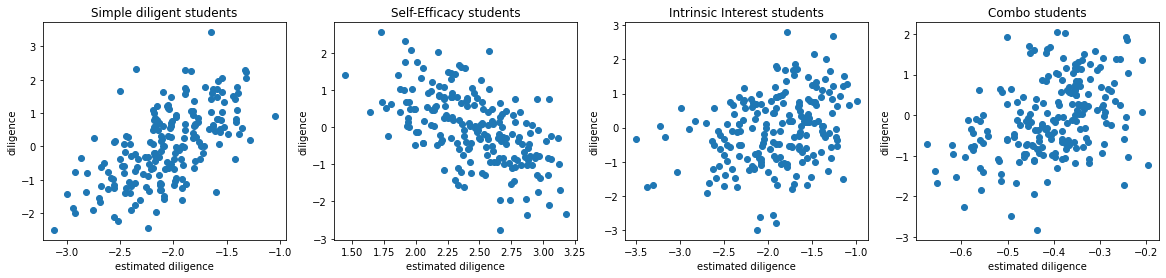

INFO:analytics.session:Comparing models with columns: ('early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785164
INFO:analytics.session:EigenValues: [1.06052037 0.93947963]
INFO:analytics.session:Factor Loadings: [[-0.24600888]
 [ 0.24600888]]
INFO:analytics.session:Factor Variance: (array([0.12104074]), array([0.06052037]), array([0.06052037]))
INFO:analytics.session:Factor loadings: early finish   -0.246009
Pct Hint        0.246009
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6040067783428252	 pval = 2.8498101022829438e-21
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sessio

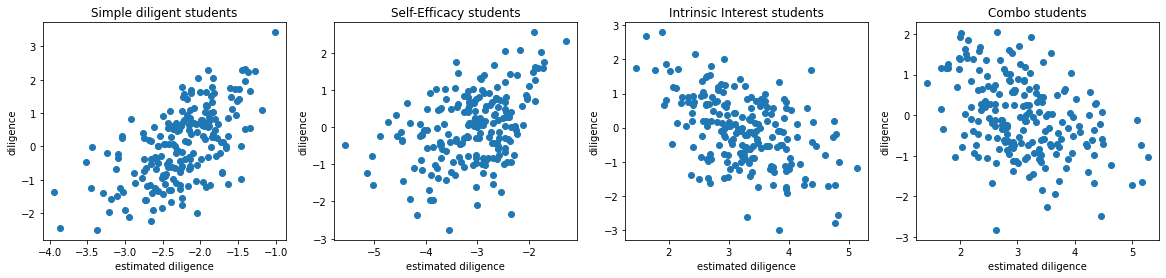

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.6848687605253023
INFO:analytics.session:EigenValues: [2.10713578 0.5387935  0.35407072]
INFO:analytics.session:Factor Loadings: [[-0.80741819]
 [ 0.62873828]
 [ 0.79993826]]
INFO:analytics.session:Factor Variance: (array([1.68713718]), array([0.56237906]), array([0.56237906]))
INFO:analytics.session:Factor loadings: pct class     -0.80741

Created 10 Combinations of length 3


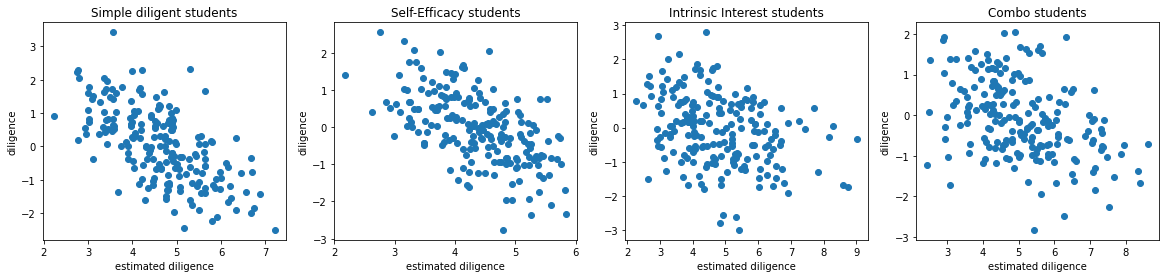

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5598955832872371
INFO:analytics.session:EigenValues: [2.19736923 0.68502342 0.11760735]
INFO:analytics.session:Factor Loadings: [[-1.00905589]
 [ 0.47888066]
 [ 0.84796118]]
INFO:analytics.session:Factor Variance: (array([1.96655863]), array([0.65551954]), array([0.65551954]))
INFO:analytics.session:Factor loadings: pct class      -1.009

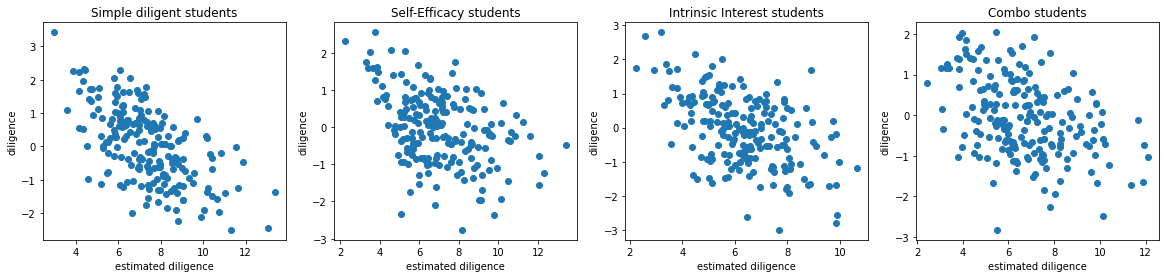

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.492950240071216
INFO:analytics.session:EigenValues: [1.51810382 0.99637521 0.48552097]
INFO:analytics.session:Factor Loadings: [[-0.99868069]
 [ 0.50599055]
 [-0.07863698]]
INFO:analytics.session:Factor Variance: (array([1.25957334]), array([0.41985778]), array([0.41985778]))
INFO:analytics.session:Factor loadings: pct class     -0.998681
Pc

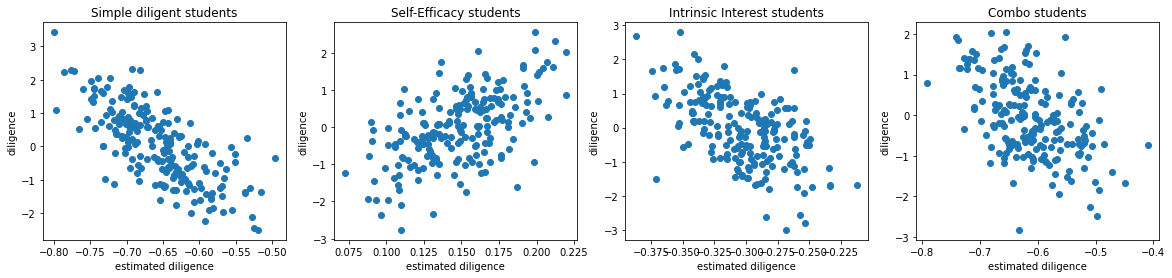

INFO:analytics.session:Comparing models with columns: ('pct class', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.35201463560490404
INFO:analytics.session:EigenValues: [2.22035561 0.74636493 0.03327946]
INFO:analytics.session:Factor Loadings: [[-1.04586131]
 [ 0.52310154]
 [ 0.76688031]]
INFO:analytics.session:Factor Variance: (array([1.95556651]), array([0.6518555]), array([0.6518555]))
INFO:analytics.session:Factor loadings: pct class      -1.045861
start speed     0.523102
early finish    0.766880
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7215462917946232	 pval = 1.90246716588442e-33
INFO:analytics.session:***************************************************
INFO:analytics.session:Co

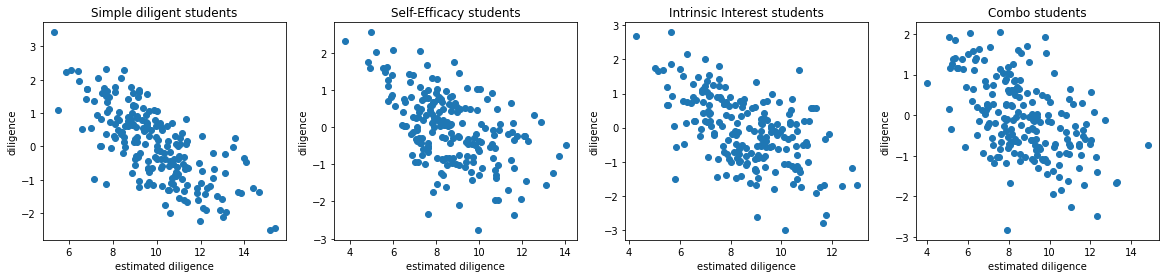

INFO:analytics.session:Comparing models with columns: ('pct class', 'start speed', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.509572520348807
INFO:analytics.session:EigenValues: [1.67733148 0.96884938 0.35381915]
INFO:analytics.session:Factor Loadings: [[-0.73172576]
 [ 0.88268787]
 [-0.12783214]]
INFO:analytics.session:Factor Variance: (array([1.33090152]), array([0.44363384]), array([0.44363384]))
INFO:analytics.session:Factor loadings: pct class     -0.731726
start speed    0.882688
Pct Hint      -0.127832
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6256619570263782	 pval = 3.9676445109514566e-23
INFO:analytics.session:***************************************************
INFO:analytics.session:Compari

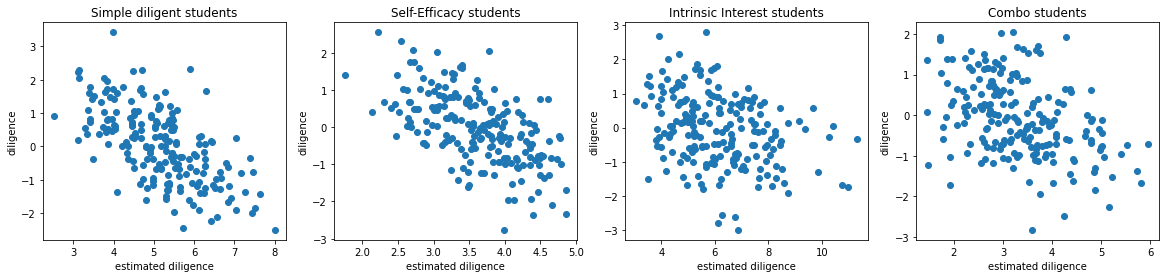

INFO:analytics.session:Comparing models with columns: ('pct class', 'early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4988629178646633
INFO:analytics.session:EigenValues: [1.8828852  0.98718549 0.12992931]
INFO:analytics.session:Factor Loadings: [[-0.97813195]
 [ 0.88693064]
 [-0.08294176]]
INFO:analytics.session:Factor Variance: (array([1.75026741]), array([0.58342247]), array([0.58342247]))
INFO:analytics.session:Factor loadings: pct class      -0.978132
early finish    0.886931
Pct Hint       -0.082942
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6089440012492007	 pval = 1.1068269379639407e-21
INFO:analytics.session:***************************************************
INFO:analytics.session:Co

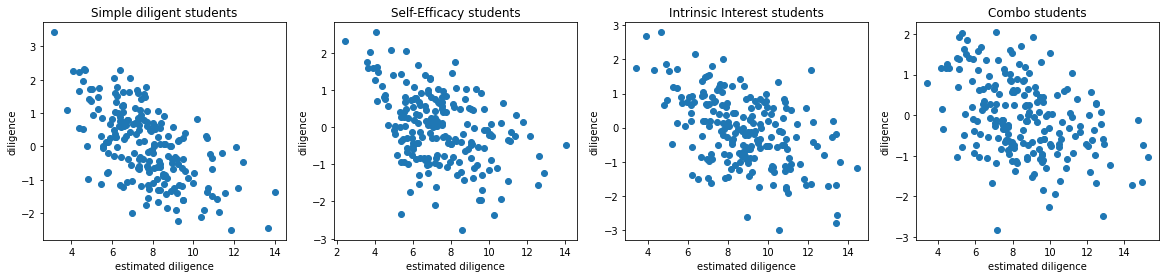

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.6079349620262201
INFO:analytics.session:EigenValues: [1.77255493 0.74949315 0.47795192]
INFO:analytics.session:Factor Loadings: [[-0.84361274]
 [-0.59618963]
 [-0.44687583]]
INFO:analytics.session:Factor Variance: (array([1.26682253]), array([0.42227418]), array([0.42227418]))
INFO:analytics.session:Factor loadings: Pct OffTask    -0.843613
start speed    -0.596190
early finish   -0.446876
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7584565178596484	 pval = 1.1379107218410773e-38
INFO:analytics.session:***************************************************
INFO:analytics.sessio

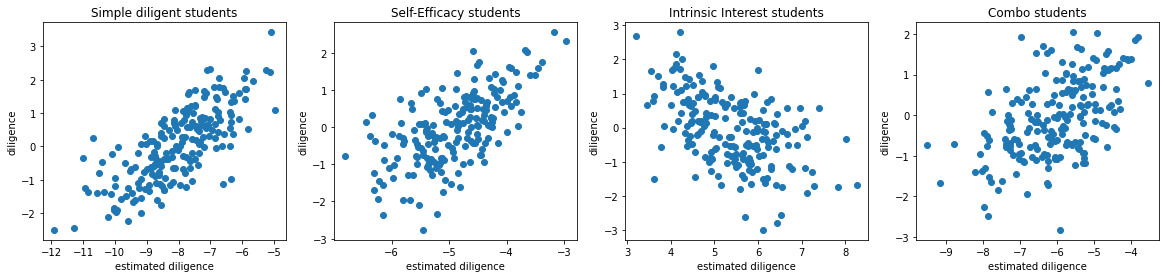

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'start speed', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49030018394731306
INFO:analytics.session:EigenValues: [1.51771355 0.99565526 0.48663119]
INFO:analytics.session:Factor Loadings: [[-0.49983269]
 [-0.99924838]
 [ 0.094395  ]]
INFO:analytics.session:Factor Variance: (array([1.25724046]), array([0.41908015]), array([0.41908015]))
INFO:analytics.session:Factor loadings: Pct OffTask   -0.49983

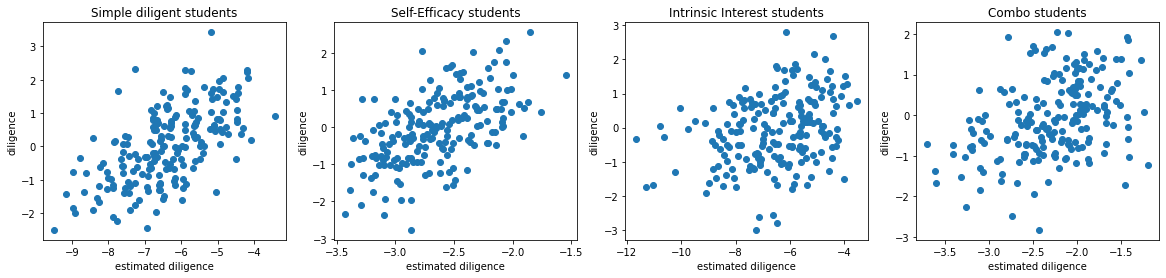

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4970857825576105
INFO:analytics.session:EigenValues: [1.38353402 0.99681763 0.61964835]
INFO:analytics.session:Factor Loadings: [[-0.37721578]
 [-0.99773522]
 [ 0.05644468]]
INFO:analytics.session:Factor Variance: (array([1.14095331]), array([0.38031777]), array([0.38031777]))
INFO:analytics.session:Factor loadings: Pct OffTask    -0.3772

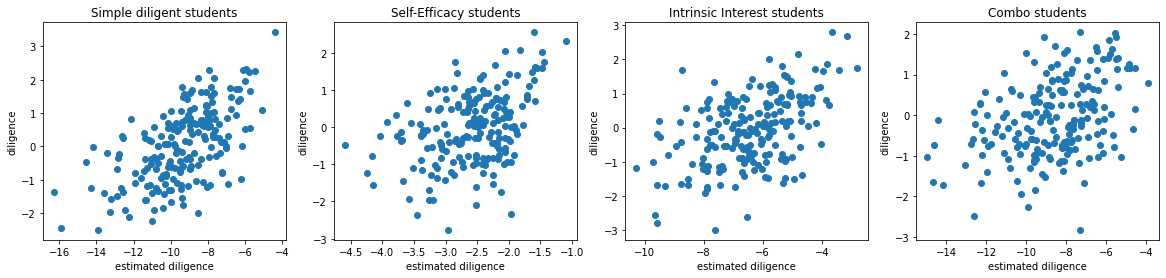

INFO:analytics.session:Comparing models with columns: ('start speed', 'early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5207033838722462
INFO:analytics.session:EigenValues: [1.31455351 0.95747532 0.72797117]
INFO:analytics.session:Factor Loadings: [[-0.70476925]
 [-0.37802726]
 [ 0.16010184]]
INFO:analytics.session:Factor Variance: (array([0.66523691]), array([0.22174564]), array([0.22174564]))
INFO:analytics.session:Factor loadings: start speed    -0.704769
early finish   -0.378027
Pct Hint        0.160102
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7636986384222598	 pval = 1.728895148852248e-39
INFO:analytics.session:***************************************************
INFO:analytics.session:Co

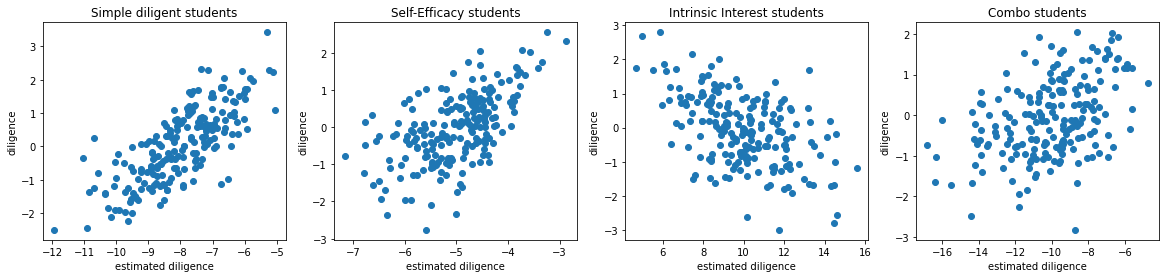

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4521419316956853
INFO:analytics.session:EigenValues: [2.61390738 0.82628941 0.52666586 0.03313735]
INFO:analytics.session:Factor Loadings: [[-1.02830951]
 [ 0.56353588]
 [ 0.59847807]
 [ 0.73042407]]
INFO:analytics.session:Factor Variance: (array([2.26668847]), array([0.56667212]), array([0.56667212]))
INFO:analytics.sessi

Created 5 Combinations of length 4


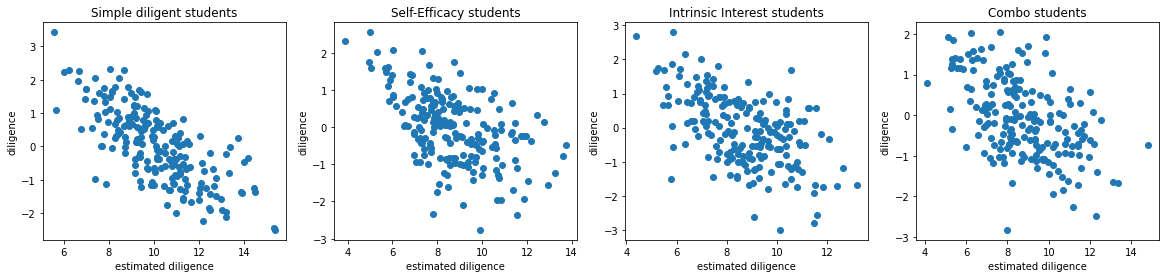

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'start speed', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.6847941945456018
INFO:analytics.session:EigenValues: [2.12180842 0.99642557 0.52796013 0.35380587]
INFO:analytics.session:Factor Loadings: [[-0.80812772]
 [ 0.62201802]
 [ 0.80570394]
 [-0.10231945]]
INFO:analytics.session:Factor Variance: (array([1.69960494]), array([0.42490124]), array([0.42490124]))
INFO:analytics.session:F

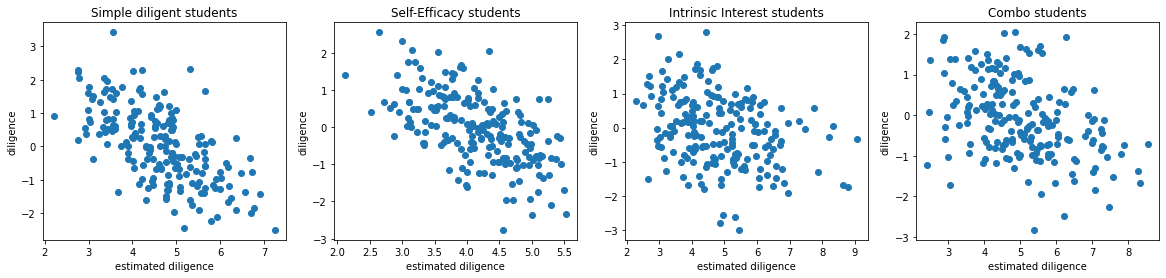

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5580632874812438
INFO:analytics.session:EigenValues: [2.20594972 0.99686098 0.68041911 0.11677019]
INFO:analytics.session:Factor Loadings: [[-1.00974419]
 [ 0.47760807]
 [ 0.84766648]
 [-0.07659825]]
INFO:analytics.session:Factor Variance: (array([1.97209855]), array([0.49302464]), array([0.49302464]))
INFO:analytics.session:

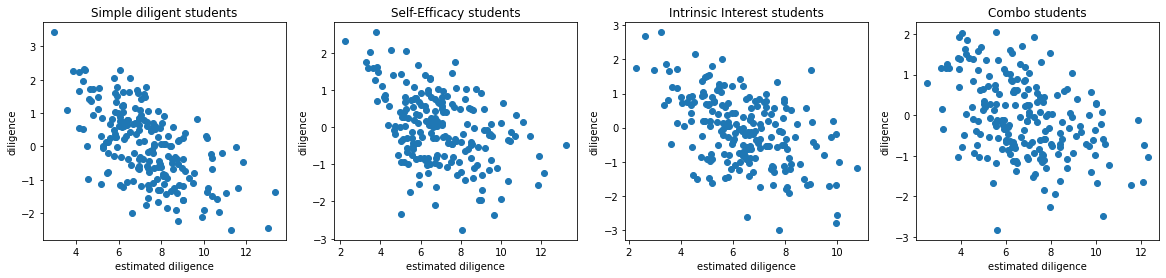

INFO:analytics.session:Comparing models with columns: ('pct class', 'start speed', 'early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.3564436089059963
INFO:analytics.session:EigenValues: [2.23872822 0.99132943 0.73667532 0.03326703]
INFO:analytics.session:Factor Loadings: [[-1.04538412]
 [ 0.52779137]
 [ 0.76384658]
 [-0.10413344]]
INFO:analytics.session:Factor Variance: (array([1.96569706]), array([0.49142426]), array([0.49142426]))
INFO:analytics.session:Factor loadings: pct class      -1.045384
start speed     0.527791
early finish    0.763847
Pct Hint       -0.104133
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7225006183308258	 pval = 1.4288075567794933e-33
INFO:analytics.session:***********

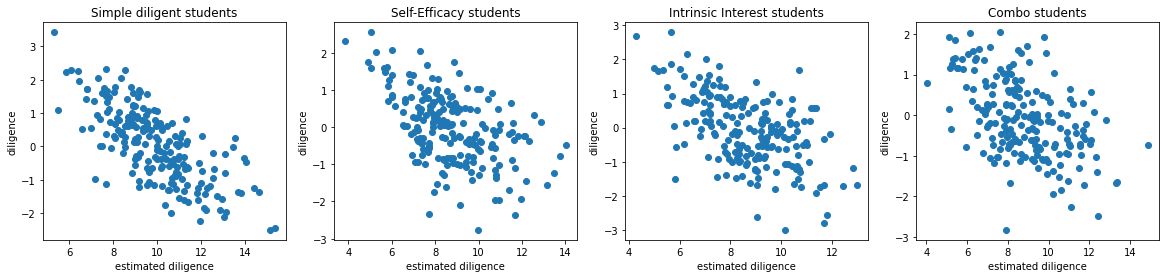

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'start speed', 'early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5972040376354408
INFO:analytics.session:EigenValues: [1.78622171 0.99770039 0.748944   0.46713391]
INFO:analytics.session:Factor Loadings: [[-0.81105167]
 [-0.61803701]
 [-0.45422012]
 [ 0.08464686]]
INFO:analytics.session:Factor Variance: (array([1.25325557]), array([0.31331389]), array([0.31331389]))
INFO:analytics.sessio

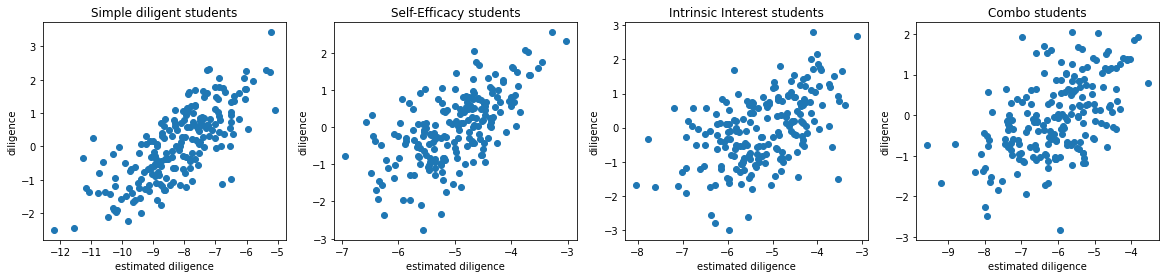

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'start speed', 'early finish', 'Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4544678716455966
INFO:analytics.session:EigenValues: [2.62619582 0.99902685 0.82599988 0.51565916 0.03311829]
INFO:analytics.session:Factor Loadings: [[-1.02823382]
 [ 0.56143512]
 [ 0.60180278]
 [ 0.7293671 ]
 [-0.09438625]]
INFO:analytics.session:Factor Variance: (array([2.27552589]), array([0.45510518]), arr

Created 1 Combinations of length 5


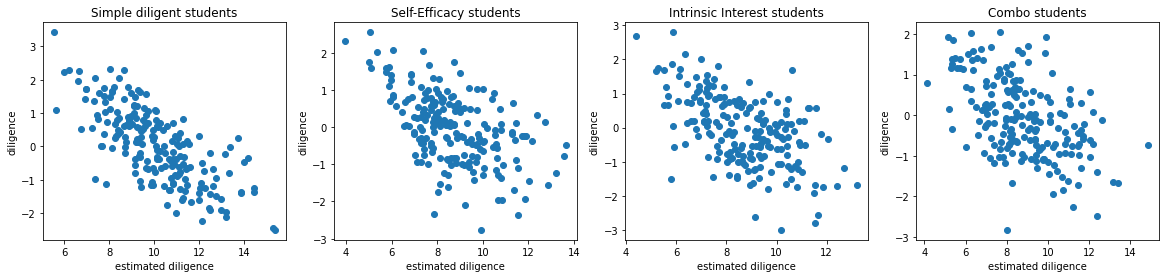

In [117]:
# dil_factors = ['Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish']
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish', 'Pct Hint']

for r in range(2,len(dil_factors)+1):
    dil_combos = list(combinations(dil_factors, r))
    print(f"Created {len(dil_combos)} Combinations of length {r}")
    for combo in dil_combos:
        n = len(batch_descs)
        plt.figure(figsize=(5*n,4))
        logger.info(f"Comparing models with columns: {combo}")
        for i, desc in enumerate(batch_descs):
            logger.info("***************************************************")
            logger.info(f"Comparing student sim: {desc}")
            ss = stu_stats[desc]
        #    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

            xcols = combo
            ycol = "diligence"
            #Factor analysis
            df = ss.loc[:,xcols]
            kmo_all, kmo_model = calculate_kmo(df)
            logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
            fa = FactorAnalyzer(rotation=None,  n_factors=1)
            fa.fit(df)
            # Check Eigenvalues
            ev, v = fa.get_eigenvalues()
            logger.info(f"EigenValues: {ev}")
            logger.info(f"Factor Loadings: {fa.loadings_}")
            logger.info(f"Factor Variance: {fa.get_factor_variance()}")

            loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
            logger.info(f"Factor loadings: {loadings}")
            X = df.mul(loadings).apply('sum', axis=1)
            logger.info(X.shape)
            Y = ss[ycol]
            corr, pval = pearsonr(X,Y)
            logger.info("******************* Pearson ********************")
            logger.info(f"R = {corr}\t pval = {pval}")

            plt.subplot(1,n,i+1)
            plt.scatter(X, Y)
            plt.title(desc)
            plt.xlabel("estimated diligence")
            plt.ylabel(ycol)
        plt.show()

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785167
INFO:analytics.session:EigenValues: [1.50765515 0.49234485]
INFO:analytics.session:Factor Loadings: [[0.71249923]
 [0.71249923]]
INFO:analytics.session:Factor Variance: (array([1.01531031]), array([0.50765516]), array([0.50765516]))
INFO:analytics.session:Factor loadings: align pct class      0.712499
align Pct OffTask    0.712499
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7788084216459962	 pval = 5.6899659947478114e-42
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
I

Created 10 Combinations of length 2


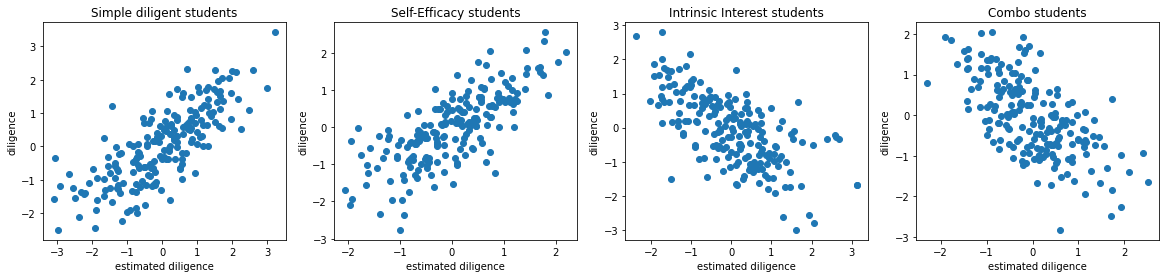

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785165
INFO:analytics.session:EigenValues: [1.64588517 0.35411483]
INFO:analytics.session:Factor Loadings: [[-0.80366981]
 [-0.80366981]]
INFO:analytics.session:Factor Variance: (array([1.29177033]), array([0.64588517]), array([0.64588517]))
INFO:analytics.session:Factor loadings: align pct class     -0.80367
align start speed   -0.80367
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7355745656039037	 pval = 2.4975451712169937e-35
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students


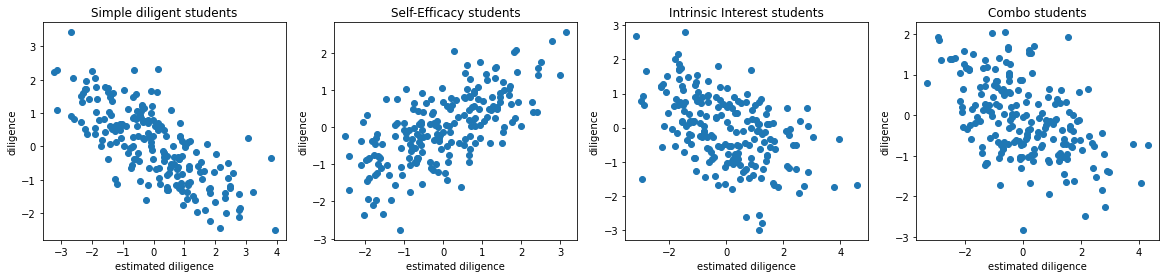

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785167
INFO:analytics.session:EigenValues: [1.86943924 0.13056076]
INFO:analytics.session:Factor Loadings: [[-0.93243726]
 [-0.93243726]]
INFO:analytics.session:Factor Variance: (array([1.73887849]), array([0.86943924]), array([0.86943924]))
INFO:analytics.session:Factor loadings: align pct class      -0.932437
align early finish   -0.932437
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6852687590221996	 pval = 4.477877588383129e-29
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy stude

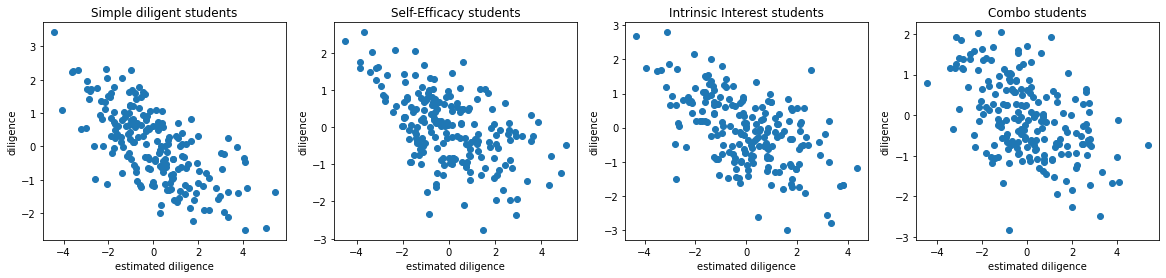

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785165
INFO:analytics.session:EigenValues: [1.0935384 0.9064616]
INFO:analytics.session:Factor Loadings: [[-0.30584049]
 [ 0.30584049]]
INFO:analytics.session:Factor Variance: (array([0.18707681]), array([0.0935384]), array([0.0935384]))
INFO:analytics.session:Factor loadings: align pct class   -0.30584
align Pct Hint     0.30584
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5824897220881047	 pval = 1.4602876665073748e-19
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analyt

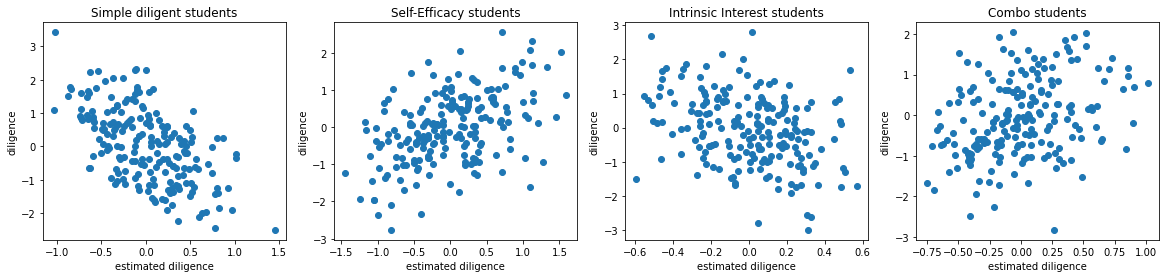

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785168
INFO:analytics.session:EigenValues: [1.50295273 0.49704727]
INFO:analytics.session:Factor Loadings: [[-0.7091916]
 [-0.7091916]]
INFO:analytics.session:Factor Variance: (array([1.00590546]), array([0.50295273]), array([0.50295273]))
INFO:analytics.session:Factor loadings: align Pct OffTask   -0.709192
align start speed   -0.709192
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7166220126183648	 pval = 8.180383939466989e-33
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students

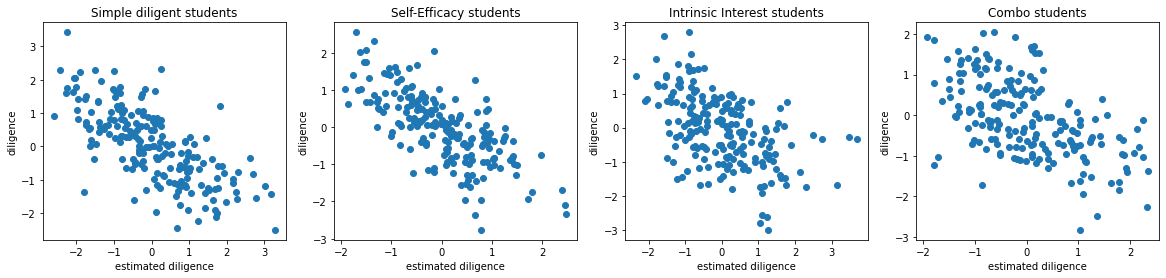

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851665
INFO:analytics.session:EigenValues: [1.37699033 0.62300967]
INFO:analytics.session:Factor Loadings: [[-0.61399538]
 [-0.61399538]]
INFO:analytics.session:Factor Variance: (array([0.75398066]), array([0.37699033]), array([0.37699033]))
INFO:analytics.session:Factor loadings: align Pct OffTask    -0.613995
align early finish   -0.613995
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7429439074786098	 pval = 2.2918053770216867e-36
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy s

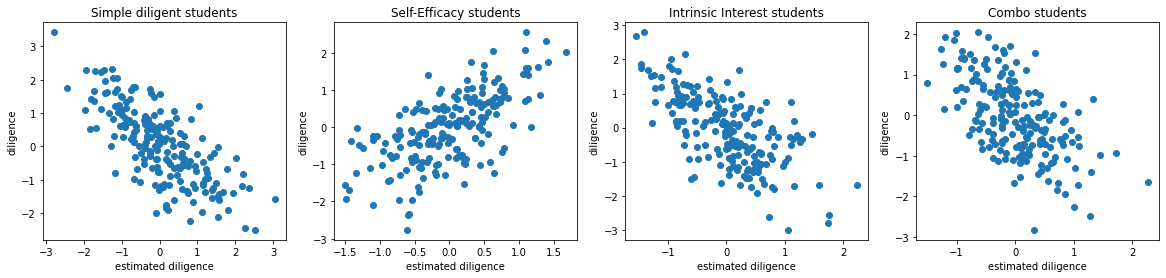

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785167
INFO:analytics.session:EigenValues: [1.01017369 0.98982631]
INFO:analytics.session:Factor Loadings: [[-0.10086473]
 [ 0.10086473]]
INFO:analytics.session:Factor Variance: (array([0.02034739]), array([0.01017369]), array([0.01017369]))
INFO:analytics.session:Factor loadings: align Pct OffTask   -0.100865
align Pct Hint       0.100865
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5412360106198336	 pval = 1.2911221689303423e-16
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students

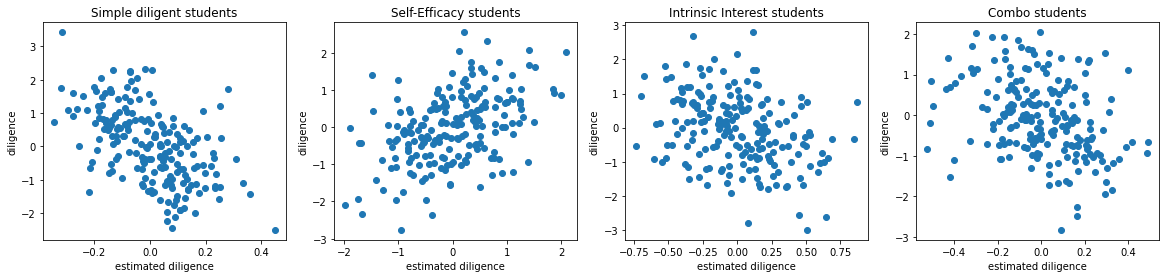

INFO:analytics.session:Comparing models with columns: ('align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4974937500785167
INFO:analytics.session:EigenValues: [1.26642324 0.73357676]
INFO:analytics.session:Factor Loadings: [[0.51616203]
 [0.51616203]]
INFO:analytics.session:Factor Variance: (array([0.53284648]), array([0.26642324]), array([0.26642324]))
INFO:analytics.session:Factor loadings: align start speed     0.516162
align early finish    0.516162
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7635108373578924	 pval = 1.851194994494125e-39
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy studen

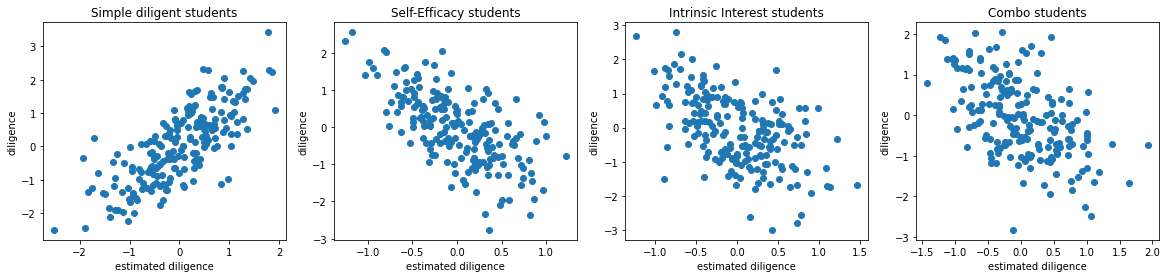

INFO:analytics.session:Comparing models with columns: ('align start speed', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851654
INFO:analytics.session:EigenValues: [1.11283578 0.88716422]
INFO:analytics.session:Factor Loadings: [[-0.33591037]
 [ 0.33591037]]
INFO:analytics.session:Factor Variance: (array([0.22567156]), array([0.11283578]), array([0.11283578]))
INFO:analytics.session:Factor loadings: align start speed   -0.33591
align Pct Hint       0.33591
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5037333463647548	 pval = 2.8866611544858887e-14
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students


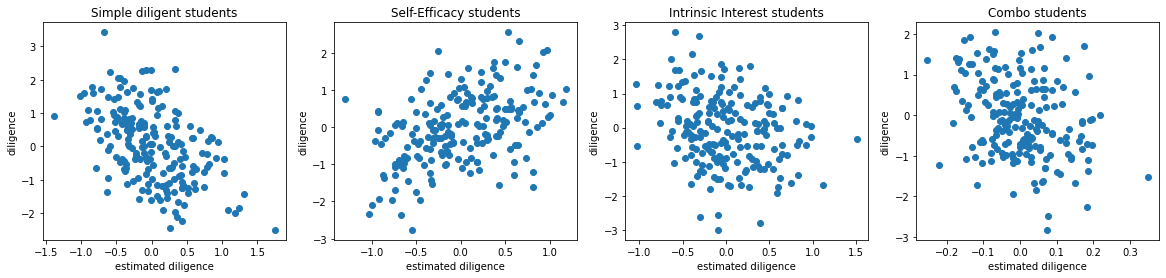

INFO:analytics.session:Comparing models with columns: ('align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49749375007851687
INFO:analytics.session:EigenValues: [1.06052037 0.93947963]
INFO:analytics.session:Factor Loadings: [[-0.24600888]
 [ 0.24600888]]
INFO:analytics.session:Factor Variance: (array([0.12104074]), array([0.06052037]), array([0.06052037]))
INFO:analytics.session:Factor loadings: align early finish   -0.246009
align Pct Hint        0.246009
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5094699883318082	 pval = 1.3166402240590674e-14
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy stud

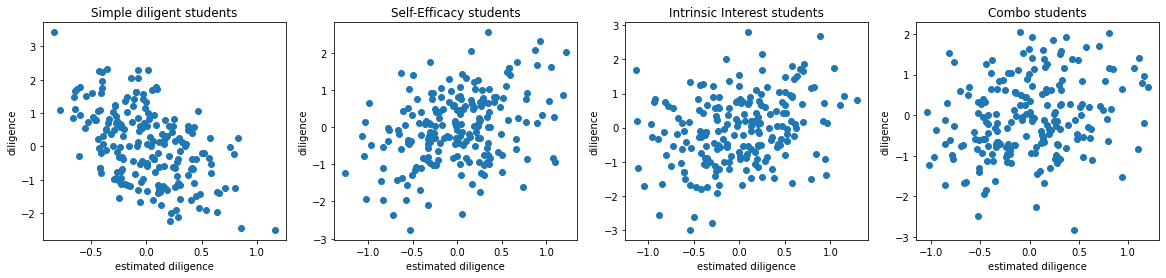

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.6848687605253043
INFO:analytics.session:EigenValues: [2.10713578 0.5387935  0.35407072]
INFO:analytics.session:Factor Loadings: [[-0.80741819]
 [-0.62873828]
 [-0.79993826]]
INFO:analytics.session:Factor Variance: (array([1.68713718]), array([0.56237906]), array([0.56237906]))
INFO:analytics.session:Factor loadings: align pct class     -0.807418
align Pct OffTask   -0.628738
align start speed   -0.799938
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7805387625540934	 pval = 2.872758639880633e-42
INFO:analytics.session:*******************************************

Created 10 Combinations of length 3


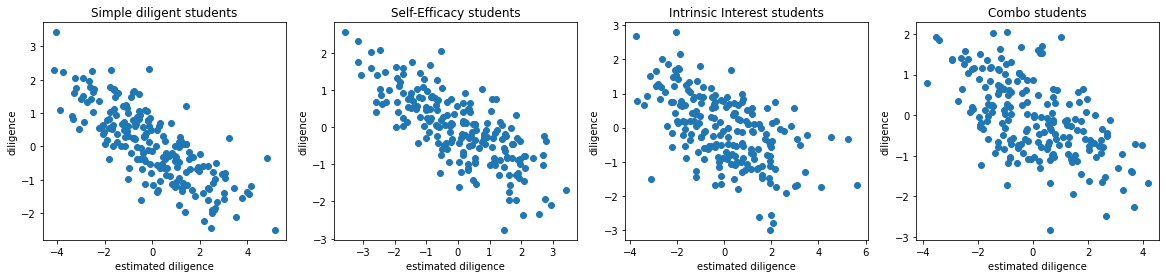

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5598955832872496
INFO:analytics.session:EigenValues: [2.19736923 0.68502342 0.11760735]
INFO:analytics.session:Factor Loadings: [[-1.00905589]
 [-0.47888066]
 [-0.84796118]]
INFO:analytics.session:Factor Variance: (array([1.96655863]), array([0.65551954]), array([0.65551954]))
INFO:analytics.session:Factor loadings: align pct class      -1.009056
align Pct OffTask    -0.478881
align early finish   -0.847961
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7477261182002717	 pval = 4.65416161339233e-37
INFO:analytics.session:****************************************

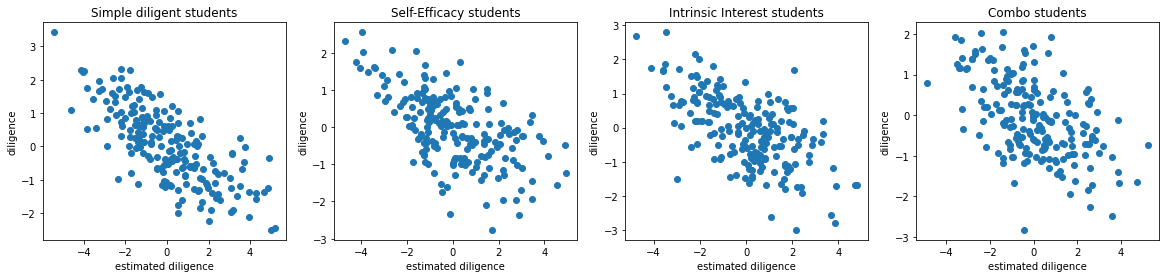

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4929502400712157
INFO:analytics.session:EigenValues: [1.51810382 0.99637521 0.48552097]
INFO:analytics.session:Factor Loadings: [[-0.99868069]
 [-0.50599055]
 [ 0.07863698]]
INFO:analytics.session:Factor Variance: (array([1.25957334]), array([0.41985778]), array([0.41985778]))
INFO:analytics.session:Factor loadings: align pct class     -0.998681
align Pct OffTask   -0.505991
align Pct Hint       0.078637
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7860221459183396	 pval = 3.1593833542547227e-43
INFO:analytics.session:*********************************************

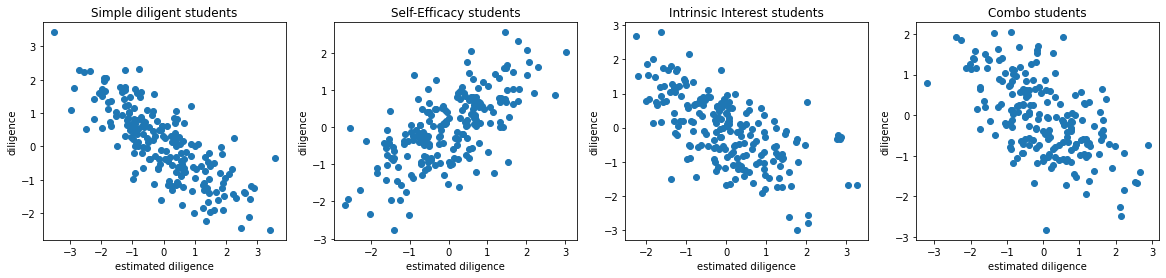

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.352014635604904
INFO:analytics.session:EigenValues: [2.22035561 0.74636493 0.03327946]
INFO:analytics.session:Factor Loadings: [[-1.04586132]
 [-0.52310154]
 [-0.7668803 ]]
INFO:analytics.session:Factor Variance: (array([1.95556651]), array([0.6518555]), array([0.6518555]))
INFO:analytics.session:Factor loadings: align pct class      -1.045861
align start speed    -0.523102
align early finish   -0.766880
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7442062322004411	 pval = 1.5098198494649843e-36
INFO:analytics.session:*****************************************

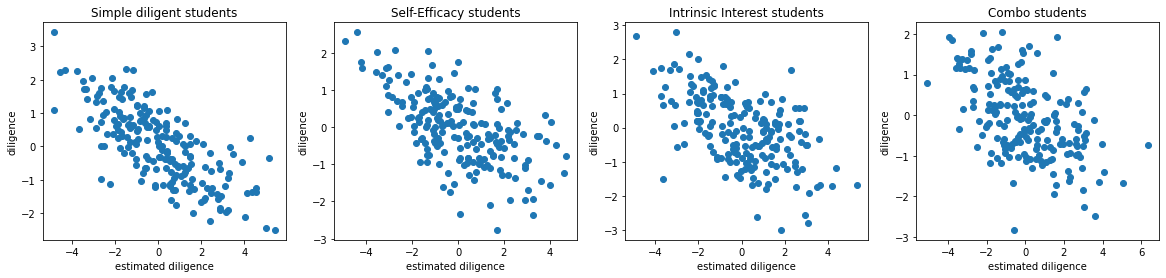

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align start speed', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5095725203488071
INFO:analytics.session:EigenValues: [1.67733148 0.96884938 0.35381915]
INFO:analytics.session:Factor Loadings: [[-0.73172576]
 [-0.88268787]
 [ 0.12783214]]
INFO:analytics.session:Factor Variance: (array([1.33090152]), array([0.44363384]), array([0.44363384]))
INFO:analytics.session:Factor loadings: align pct class     -0.731726
align start speed   -0.882688
align Pct Hint       0.127832
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7313377430147455	 pval = 9.513266171894239e-35
INFO:analytics.session:**********************************************

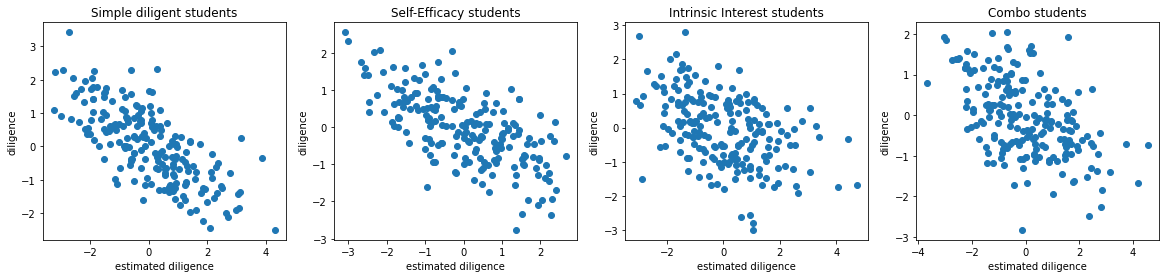

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4988629178646633
INFO:analytics.session:EigenValues: [1.8828852  0.98718549 0.12992931]
INFO:analytics.session:Factor Loadings: [[-0.97813207]
 [-0.88693054]
 [ 0.08294176]]
INFO:analytics.session:Factor Variance: (array([1.75026747]), array([0.58342249]), array([0.58342249]))
INFO:analytics.session:Factor loadings: align pct class      -0.978132
align early finish   -0.886931
align Pct Hint        0.082942
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6913503682212585	 pval = 9.188732686184135e-30
INFO:analytics.session:******************************************

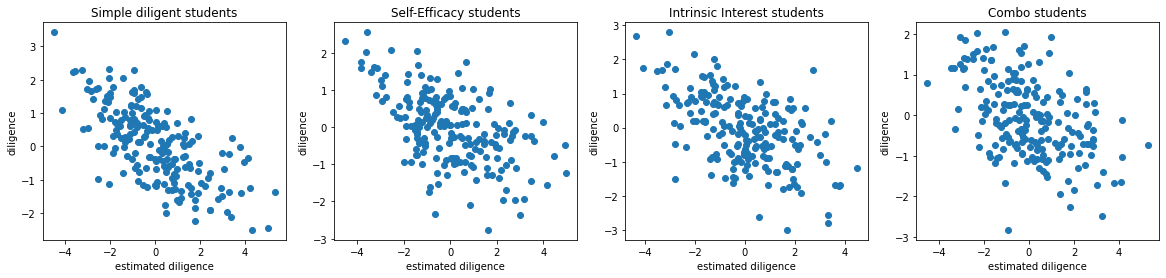

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.60793496202622
INFO:analytics.session:EigenValues: [1.77255493 0.74949315 0.47795192]
INFO:analytics.session:Factor Loadings: [[-0.84361274]
 [-0.59618963]
 [-0.44687583]]
INFO:analytics.session:Factor Variance: (array([1.26682253]), array([0.42227418]), array([0.42227418]))
INFO:analytics.session:Factor loadings: align Pct OffTask    -0.843613
align start speed    -0.596190
align early finish   -0.446876
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7863164952334628	 pval = 2.801189648810749e-43
INFO:analytics.session:***************************************

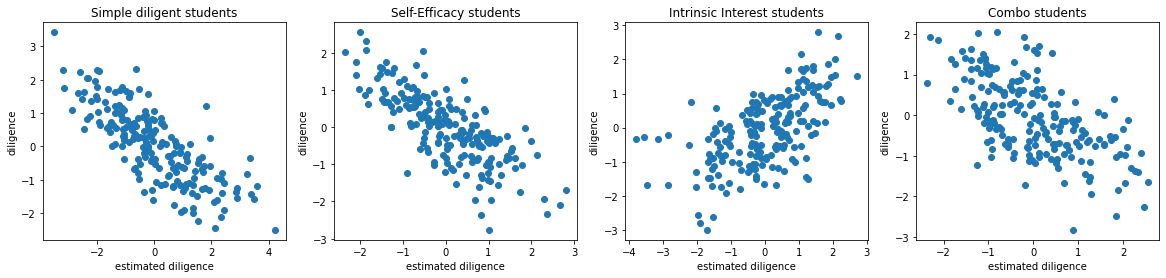

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align start speed', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4903001839473444
INFO:analytics.session:EigenValues: [1.51771355 0.99565526 0.48663119]
INFO:analytics.session:Factor Loadings: [[-0.49983269]
 [-0.99924838]
 [ 0.094395  ]]
INFO:analytics.session:Factor Variance: (array([1.25724046]), array([0.41908015]), array([0.41908015]))
INFO:analytics.session:Factor loadings: align Pct OffTask   -0.499833
align start speed   -0.999248
align Pct Hint       0.094395
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7041529888812672	 pval = 2.8721827946264213e-31
INFO:analytics.session:*******************************************

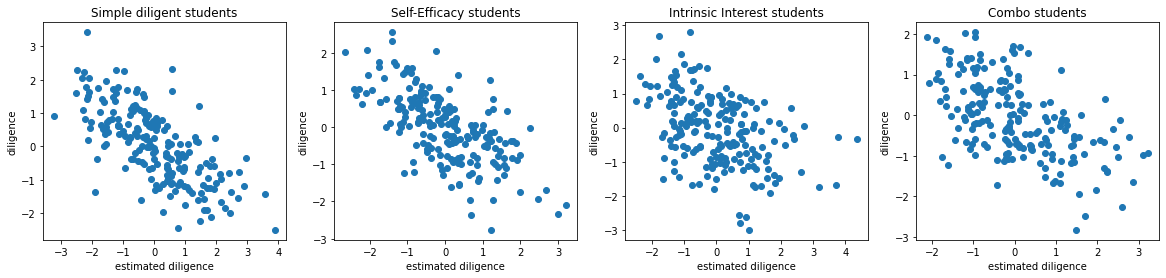

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49708578255747915
INFO:analytics.session:EigenValues: [1.38353402 0.99681763 0.61964835]
INFO:analytics.session:Factor Loadings: [[-0.37721578]
 [-0.99773522]
 [ 0.05644468]]
INFO:analytics.session:Factor Variance: (array([1.14095331]), array([0.38031777]), array([0.38031777]))
INFO:analytics.session:Factor loadings: align Pct OffTask    -0.377216
align early finish   -0.997735
align Pct Hint        0.056445
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7077951663740084	 pval = 1.0356401727401481e-31
INFO:analytics.session:**************************************

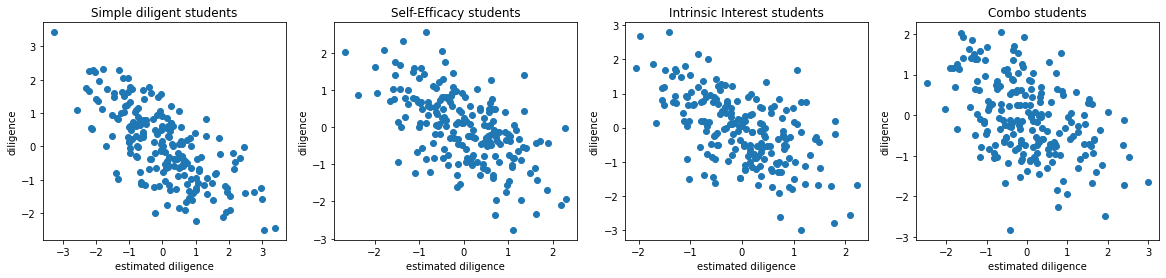

INFO:analytics.session:Comparing models with columns: ('align start speed', 'align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5207033838722459
INFO:analytics.session:EigenValues: [1.31455351 0.95747532 0.72797117]
INFO:analytics.session:Factor Loadings: [[-0.70476925]
 [-0.37802726]
 [ 0.16010184]]
INFO:analytics.session:Factor Variance: (array([0.66523691]), array([0.22174564]), array([0.22174564]))
INFO:analytics.session:Factor loadings: align start speed    -0.704769
align early finish   -0.378027
align Pct Hint        0.160102
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7438047342336229	 pval = 1.7246069814756815e-36
INFO:analytics.session:***************************************

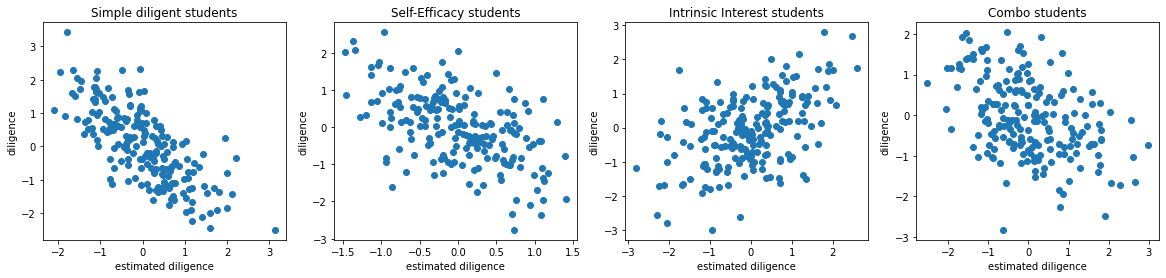

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.45214193169562
INFO:analytics.session:EigenValues: [2.61390738 0.82628941 0.52666586 0.03313735]
INFO:analytics.session:Factor Loadings: [[-1.02830951]
 [-0.56353588]
 [-0.59847807]
 [-0.73042407]]
INFO:analytics.session:Factor Variance: (array([2.26668847]), array([0.56667212]), array([0.56667212]))
INFO:analytics.session:Factor loadings: align pct class      -1.028310
align Pct OffTask    -0.563536
align start speed    -0.598478
align early finish   -0.730424
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7882011837820082	 pval = 1.290502

Created 5 Combinations of length 4


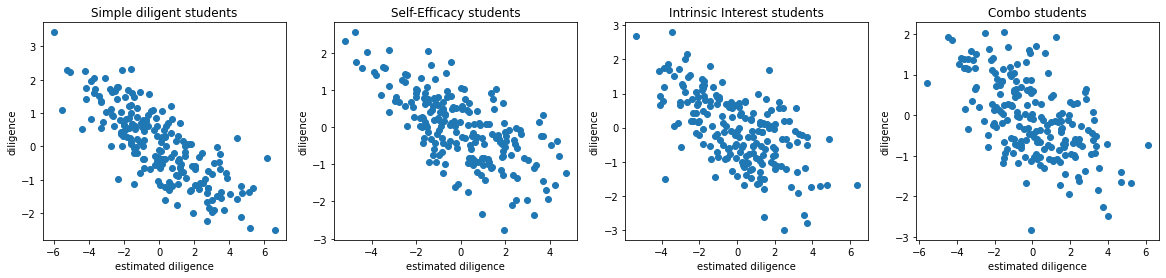

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align start speed', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.6847941945455984
INFO:analytics.session:EigenValues: [2.12180842 0.99642557 0.52796013 0.35380587]
INFO:analytics.session:Factor Loadings: [[-0.80812772]
 [-0.62201802]
 [-0.80570394]
 [ 0.10231945]]
INFO:analytics.session:Factor Variance: (array([1.69960494]), array([0.42490124]), array([0.42490124]))
INFO:analytics.session:Factor loadings: align pct class     -0.808128
align Pct OffTask   -0.622018
align start speed   -0.805704
align Pct Hint       0.102319
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7827482025926285	 pval = 1.189488083894

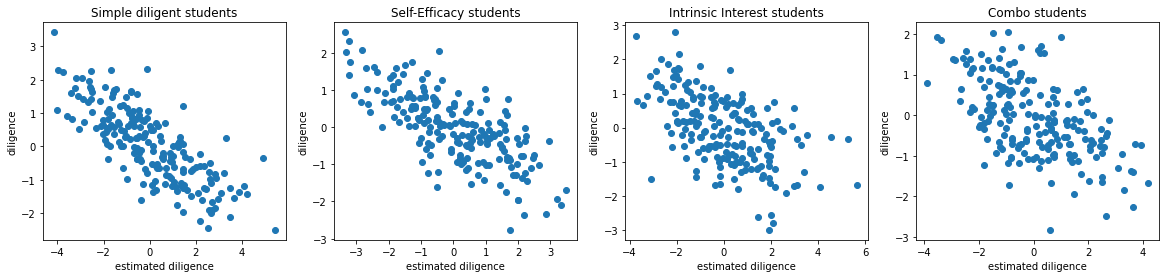

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5580632874812552
INFO:analytics.session:EigenValues: [2.20594972 0.99686098 0.68041911 0.11677019]
INFO:analytics.session:Factor Loadings: [[-1.00974419]
 [-0.47760807]
 [-0.84766648]
 [ 0.07659825]]
INFO:analytics.session:Factor Variance: (array([1.97209855]), array([0.49302464]), array([0.49302464]))
INFO:analytics.session:Factor loadings: align pct class      -1.009744
align Pct OffTask    -0.477608
align early finish   -0.847666
align Pct Hint        0.076598
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7502646631279901	 pval = 1.9677180

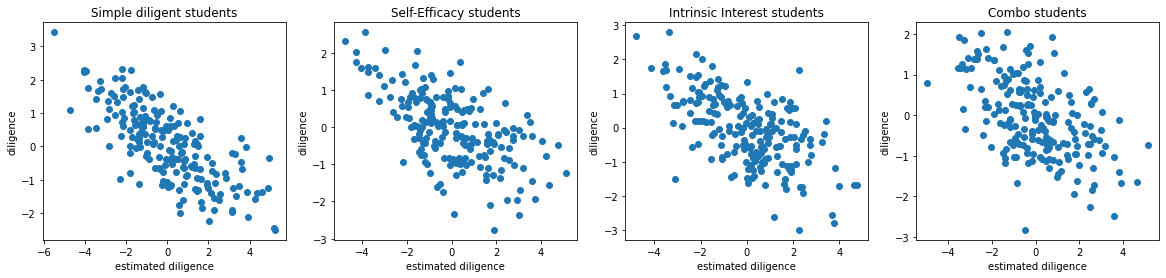

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align start speed', 'align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.3564436089059961
INFO:analytics.session:EigenValues: [2.23872822 0.99132943 0.73667532 0.03326703]
INFO:analytics.session:Factor Loadings: [[-1.04538412]
 [-0.52779137]
 [-0.76384658]
 [ 0.10413344]]
INFO:analytics.session:Factor Variance: (array([1.96569706]), array([0.49142426]), array([0.49142426]))
INFO:analytics.session:Factor loadings: align pct class      -1.045384
align start speed    -0.527791
align early finish   -0.763847
align Pct Hint        0.104133
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7468981450620281	 pval = 6.1492404

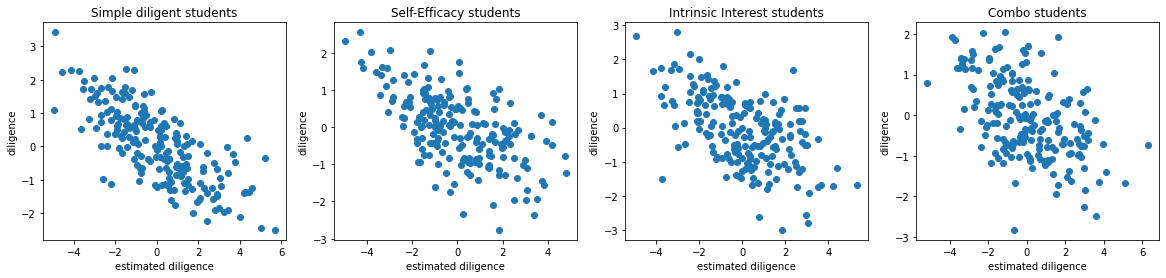

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align start speed', 'align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5972040376354283
INFO:analytics.session:EigenValues: [1.78622171 0.99770039 0.748944   0.46713391]
INFO:analytics.session:Factor Loadings: [[-0.81105167]
 [-0.61803701]
 [-0.45422012]
 [ 0.08464686]]
INFO:analytics.session:Factor Variance: (array([1.25325557]), array([0.31331389]), array([0.31331389]))
INFO:analytics.session:Factor loadings: align Pct OffTask    -0.811052
align start speed    -0.618037
align early finish   -0.454220
align Pct Hint        0.084647
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7917611773656691	 pval = 2.92093

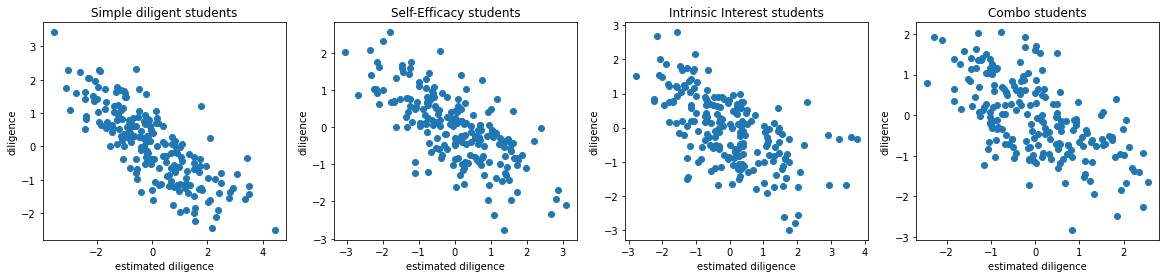

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align start speed', 'align early finish', 'align Pct Hint')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4544678716455902
INFO:analytics.session:EigenValues: [2.62619582 0.99902685 0.82599988 0.51565916 0.03311829]
INFO:analytics.session:Factor Loadings: [[-1.02823382]
 [-0.56143512]
 [-0.60180278]
 [-0.7293671 ]
 [ 0.09438625]]
INFO:analytics.session:Factor Variance: (array([2.27552589]), array([0.45510518]), array([0.45510518]))
INFO:analytics.session:Factor loadings: align pct class      -1.028234
align Pct OffTask    -0.561435
align start speed    -0.601803
align early finish   -0.729367
align Pct Hint        0.094386
dtype: float64
INFO:analytics.session:(200,)
INFO:analytics.session:******************* Pearson *******

Created 1 Combinations of length 5


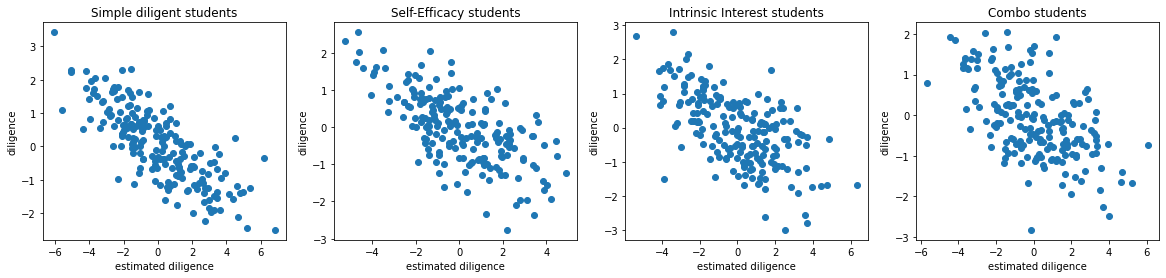

In [118]:
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish', "Pct Hint"]
dil_factors = [f"align {f}" for f in dil_factors]

for r in range(2,len(dil_factors)+1):
    dil_combos = list(combinations(dil_factors, r))
    print(f"Created {len(dil_combos)} Combinations of length {r}")
    for combo in dil_combos:
        n = len(batch_descs)
        plt.figure(figsize=(5*n,4))
        logger.info(f"Comparing models with columns: {combo}")
        for i, desc in enumerate(batch_descs):
            logger.info("***************************************************")
            logger.info(f"Comparing student sim: {desc}")
            ss = stu_stats[desc]
        #    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

            xcols = combo
            ycol = "diligence"
            #Factor analysis
            df = ss.loc[:,xcols]
            kmo_all, kmo_model = calculate_kmo(df)
            logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
            fa = FactorAnalyzer(rotation=None,  n_factors=1)
            fa.fit(df)
            # Check Eigenvalues
            ev, v = fa.get_eigenvalues()
            logger.info(f"EigenValues: {ev}")
            logger.info(f"Factor Loadings: {fa.loadings_}")
            logger.info(f"Factor Variance: {fa.get_factor_variance()}")

            loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
            logger.info(f"Factor loadings: {loadings}")
            X = df.mul(loadings).apply('sum', axis=1)
            logger.info(X.shape)
            Y = ss[ycol]
            corr, pval = pearsonr(X,Y)
            logger.info("******************* Pearson ********************")
            logger.info(f"R = {corr}\t pval = {pval}")

            plt.subplot(1,n,i+1)
            plt.scatter(X, Y)
            plt.title(desc)
            plt.xlabel("estimated diligence")
            plt.ylabel(ycol)
        plt.show()

#### Cronbach's Alpha

In [119]:
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish', "Pct Hint"]
dil_factors = [f"align {f}" for f in dil_factors]

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    for r in range(2,len(dil_factors)+1):
        dil_combos = list(combinations(dil_factors, r))
        print(f"Created {len(dil_combos)} Combinations of length {r}")
        for combo in dil_combos:
            logger.info(f"Calculating alpha for factors: {combo}")

#             alpha = cronbach_alpha(ss.loc[:,combo])
            alpha = CronbachAlpha(ss.loc[:,combo])
            
            logger.info(f"Alpha: {alpha}")

INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Calculating alpha for factors: ('align pct class', 'align Pct OffTask')
INFO:analytics.session:Alpha: 0.6734366983344087
INFO:analytics.session:Calculating alpha for factors: ('align pct class', 'align start speed')
INFO:analytics.session:Alpha: 0.7848483952804803
INFO:analytics.session:Calculating alpha for factors: ('align pct class', 'align early finish')
INFO:analytics.session:Alpha: 0.930160470954924
INFO:analytics.session:Calculating alpha for factors: ('align pct class', 'align Pct Hint')
INFO:analytics.session:Alpha: -0.20638138471888867
INFO:analytics.session:Calculating alpha for factors: ('align Pct OffTask', 'align start speed')
INFO:analytics.session:Alpha: 0.6692861570617916
INFO:analytics.session:Calculating alpha for factors: ('align Pct OffTask', 'align early finish')
INFO:analytics.session:Alpha: 0.547

Created 10 Combinations of length 2
Created 10 Combinations of length 3
Created 5 Combinations of length 4
Created 1 Combinations of length 5
Created 10 Combinations of length 2
Created 10 Combinations of length 3
Created 5 Combinations of length 4
Created 1 Combinations of length 5
Created 10 Combinations of length 2
Created 10 Combinations of length 3
Created 5 Combinations of length 4
Created 1 Combinations of length 5
Created 10 Combinations of length 2
Created 10 Combinations of length 3
Created 5 Combinations of length 4
Created 1 Combinations of length 5


### M5: Multiple Dil & Cog Measures

#### EDA of cog factors with cog ability


INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.723491164706243	 pval = 1.060132136048724e-33


KeyError: 'Intercept (logit)'

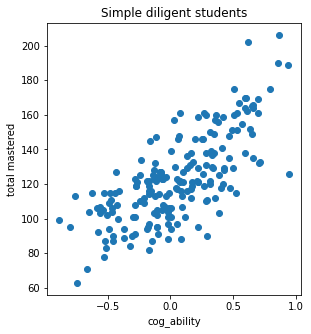

In [61]:
for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    cog_cols = ['total mastered', 'Intercept (logit)']
    n = len(cog_cols)
    plt.figure(figsize=(5*n, 5))
    for i, ycol in enumerate(cog_cols):
        xcol = "cog_ability"
        X = ss[xcol]
        Y = ss[ycol]
        corr, pval = pearsonr(X,Y)
        logger.info("******************* Pearson ********************")
        logger.info(f"R = {corr}\t pval = {pval}")

        plt.subplot(1,n,i+1)
        plt.scatter(X, Y)
        plt.title(desc)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
    plt.show()
        
    ycol = "estimated cog ability"
    xcol = "cog_ability"
    #Factor analysis
    df = ss.loc[:,cog_cols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=1)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
    logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")
    
    loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
    logger.info(f"Factor loadings: {loadings}")
    X = ss[xcol]
    Y = df.mul(loadings).apply('sum', axis=1)
    corr, pval = pearsonr(X,Y)
    logger.info("******************* Pearson ********************")
    logger.info(f"R = {corr}\t pval = {pval}")
    plt.figure(figsize=(5, 5))

    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()

#### Measure analysis

In [ ]:
'''
Cognitive Factors
    AFM Student Intercept
    Total Skills mastered
    
Diligence Factors
    
1. Frequency of Off-task
2. Total Time 
3. Start Speed (procrastination)
4. Early Finish (persistence)

'''
n = len(batch_descs)
plt.figure(figsize=(5*n,4))

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    cog_cols = ['total mastered', 'Intercept (logit)']
    dil_cols = ['Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish']
    dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
    dil_cols = [f"align {f}" for f in dil_factors]

    xcols= dil_cols+cog_cols
    ycol = "diligence"
    #Factor analysis
    df = ss.loc[:,xcols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=2)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
#     logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")

    loadings = pd.DataFrame(fa.loadings_, index=xcols)
    dil_factor = loadings.loc[cog_cols,:].apply(lambda x: np.sum(np.absolute(x)), axis=0).argmin()
    cog_factor = loadings.loc[cog_cols,:].apply(lambda x: np.sum(np.absolute(x)), axis=0).argmax()

    logger.info(f"Diligence factor loadings:\n{loadings[dil_factor]}")
    logger.info(f"Cognitive factor loadings:\n{loadings[cog_factor]}")

    X = df.mul(loadings[dil_factor]).apply('sum', axis=1)
    logger.info(X.shape)
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info("******************* Pearson ********************")
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(1,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel("estimated diligence")
    plt.ylabel(ycol)
plt.show()



# Reliability Analysis

## Setup

In [72]:
def get_split_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


def get_action_counts(tx):
    action_dist = tx.groupby('student_id')['action_type'].value_counts().reset_index(name="count")
    action_dist = action_dist.pivot_table(index='student_id', columns='action_type', values='count', fill_value=0)
    action_dist['total actions'] = action_dist.sum(axis=1)
    for col in action_dist.columns:
        if col != 'total actions':
            action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total actions'], axis=1)
            action_dist.head()

    return action_dist

def total_tx_stats(tx):

    # Total Transaction counts
    stu_stats = tx.groupby('stu_id').agg({'_id': 'count',
                                          'duration': np.sum,
                                         })
    stu_stats.rename(columns={'_id': "Total Tx",
                              'duration': 'Total Time'},
                              inplace = True)
    stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
    logger.debug("Number of students: %i" % stu_stats.shape[0])
    logger.debug(stu_stats["Total Tx"].describe())

    # Total of each outcome
    d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot_table(
            index='stu_id', columns='outcome', values='_id', fill_value=0)

    # Prorporation of each outcome
    stu_stats = pd.concat([stu_stats, d], axis=1)
    stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
    stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
    stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']

    return stu_stats

def calc_stu_session_stats(tx):
    session_stats = calc_session_stats(tx)
    stu_session_stats = session_stats.groupby('stu_id')[['start speed', 'early finish', 'session length', 'pct class']].agg('mean', 'std')
    stu_session_stats['total opportunity'] = session_stats.groupby('stu_id')['session length'].sum()
    return stu_session_stats


def get_student_sessions(tx):
    ses_ids = tx['session_id'].unique().tolist()
    sids = tx['stu_id'].unique().tolist()
    # Get login-logout transactions for students
    d = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 
                                         "type": {"$in": ["SessionStart", "SessionEnd"]}, 
                                         'session_id': {"$in": ses_ids}}))
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    d = pd.merge(d, sessions, on="session_id", how='inner')
    return d


def calc_session_stats(tx):
    d = get_student_sessions(tx)

    # Calc student-session stats
    session_stats = d.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(d.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']

    return session_stats




In [73]:
def calc_expected_work_rate(steps):
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    d = pd.merge(steps, d, on="kc", how="outer")
    d['expected_duration'] = d['Attempts'] * d['m_time']
    exp_work_rate = d.groupby('stu_id')['duration'].sum() / d.groupby('stu_id')['expected_duration'].sum()
    return exp_work_rate


In [74]:
def rand_split(x):
    k = int(len(x)/2)
    s1 = random.sample(x.tolist(), k)
    return x.apply(lambda d: 0 if d in s1 else 1)
    

In [75]:
def calc_split_half_stats(ids):
    
    # Get all tx
    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)

    # Split tx by random half sessions
    idx = tx.loc[:, ['stu_id', 'session_id']].drop_duplicates()
    idx['split_half'] = idx.groupby('stu_id')['session_id'].apply(rand_split)
    # Index tx by split half
    tx = pd.merge(tx, idx, on=['stu_id', 'session_id'], how='inner')
    
    # Get step rollup
    steps = tx.groupby('split_half').apply(step_calc.rollup_tx).reset_index()
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)

    # Calculate student non-diligent stats
    detect_offtask = tx.groupby('split_half').apply(calc.calc_detected_offtask).unstack().rename('detect_offtask')
    detect_guess = tx.groupby('split_half').apply(calc.calc_detected_guess).unstack().rename('detect_guess')
    time_on_task = tx.groupby('split_half').apply(calc.calc_time_on_task)
    time_on_task.index = time_on_task.index.swaplevel()

    # Count opportunities at each knowledge level
    kc_prac = steps.groupby('split_half').apply(step_calc.count_practice_challenge)
    kc_prac.index = kc_prac.index.swaplevel()
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1).rename("over_practice")
    kc_prac.columns = [f"{col}_practice" for col in kc_prac.columns.tolist()]

    # Calculate accuracy
    step_accuracy = steps.groupby('split_half').apply(calc_step_accuracy).unstack().rename('accuracy')

    # Calculate work rate:
    work_rate = steps.groupby('split_half').apply(calc.calc_avg_work_rate).unstack().rename('work rate')
    exp_work_rate = steps.groupby('split_half').apply(calc_expected_work_rate).unstack().rename('exp_work_rate')

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'split_half', 'knowledge_level'])['Hint'].mean().unstack(level=2)
    stu_level_hints.columns = [f"{col}_mean_num_hints" for col in stu_level_hints.columns.tolist()]
    
    # Action stats
    action_dist = tx.groupby('split_half').apply(get_action_counts)
    action_dist.index = action_dist.index.swaplevel()
    
    # Total Tx Stats
    tx_stats = tx.groupby('split_half').apply(total_tx_stats)
    tx_stats.index = tx_stats.index.swaplevel()
    
    # Session stats
    ses_stats = tx.groupby('split_half').apply(calc_stu_session_stats)
    ses_stats.index = ses_stats.index.swaplevel()
    
    
    
    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       stu_level_hints, action_dist, tx_stats, ses_stats], axis=1)

    return stats#, action_dist, tx_stats, ses_stats
    

In [76]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

## Calculate Split-half Reliability

In [77]:
ses_calc = SessionCalculator(db)

In [ ]:
# Dataframe to store reliability results

In [78]:
split_stu_stats = {desc: {} for desc in batch_descs}
batch_size=2
for desc in batch_descs:
    ids = sids[desc][0]
    logger.info(f"Calculating split-half reliability of {len(ids)} students for batch, {desc}")
    
    
    def calc_split_stats(sids):
        d = calc_split_half_stats(sids)
        d.index.rename("stu_id", level=0, inplace=True)
        d.index.rename("split_half", level=1, inplace=True)

        args = [get_stu_parameters, sids, batch_size, [mastery_thres]]
        sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#         logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
        sim_students.index.rename("stu_id", inplace=True)

        result = pd.merge(sim_students, d, left_index=True, right_index=True)

#         logger.info("Completed calculated and merging reliability stats: {split_stu_stats.shape}")
        return result
    
    args = [calc_split_stats, ids, batch_size]
    split_stu_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student split half stats: {split_stu_stats[desc].shape}\tRuntime: {runtime} seconds")
    
    


INFO:analytics.session:Calculating split-half reliability of 200 students for batch, Simple diligent students
INFO:analytics.session:Calculated student split half stats: (400, 63)	Runtime: 864.522105 seconds
INFO:analytics.session:Calculating split-half reliability of 200 students for batch, Self-Efficacy students
INFO:analytics.session:Calculated student split half stats: (400, 63)	Runtime: 882.591468 seconds
INFO:analytics.session:Calculating split-half reliability of 200 students for batch, Intrinsic Interest students
INFO:analytics.session:Calculated student split half stats: (400, 64)	Runtime: 865.234945 seconds
INFO:analytics.session:Calculating split-half reliability of 200 students for batch, Combo students
INFO:analytics.session:Calculated student split half stats: (400, 64)	Runtime: 878.14795 seconds


## Compare Reliability of estimators

### Align direction of measures and scale

In [121]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish', "Pct Hint"]
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1, "Pct Hint": -1}
for i, desc in enumerate(batch_descs):
    logger.info(f"Aligning columns for student sim: {desc}")
    ss = split_stu_stats[desc]
    for m in measures:
        d = ss[m]
        split_stu_stats[desc][scaled_measures[m]] = align_measures[m] * (d - d.mean())/d.std() 

logger.info(f"Added new columns: {scaled_measures.values()}")

INFO:analytics.session:Aligning columns for student sim: Simple diligent students
INFO:analytics.session:Aligning columns for student sim: Self-Efficacy students
INFO:analytics.session:Aligning columns for student sim: Intrinsic Interest students
INFO:analytics.session:Aligning columns for student sim: Combo students
INFO:analytics.session:Added new columns: dict_values(['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish', 'align Pct Hint'])


In [132]:
measures = ['Pct OffTask', 'pct class', 'start speed', 'early finish', 'Pct Hint']
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1, "Pct Hint": -1}
for desc in batch_descs:
    ss = split_stu_stats[desc].unstack(level=1)
    # Calculate reliability of each measu
    logger.info(f"##### Calculating Reliability for {desc} #####")
    for m in measures:
#         logger.info(f"Calculating alpha for factors: {m}")
        alpha = CronbachAlpha(ss[m])    
        logger.info(f"{m} Alpha: {alpha}")
        corr, pval = pearsonr(ss[m][0],ss[m][1])
#         logger.info(f"Reliability: {abs(corr)}")

INFO:analytics.session:##### Calculating Reliability for Simple diligent students #####
INFO:analytics.session:Pct OffTask Alpha: 0.3244547824827617
INFO:analytics.session:pct class Alpha: 0.35661764445693533
INFO:analytics.session:start speed Alpha: 0.38781782868834647
INFO:analytics.session:early finish Alpha: 0.15559214617157302
INFO:analytics.session:Pct Hint Alpha: 0.7489917096642358
INFO:analytics.session:##### Calculating Reliability for Self-Efficacy students #####
INFO:analytics.session:Pct OffTask Alpha: 0.3095088537706494
INFO:analytics.session:pct class Alpha: 0.3689823174798801
INFO:analytics.session:start speed Alpha: 0.20767737571753364
INFO:analytics.session:early finish Alpha: 0.35058079095305006
INFO:analytics.session:Pct Hint Alpha: 0.8780479217935855
INFO:analytics.session:##### Calculating Reliability for Intrinsic Interest students #####
INFO:analytics.session:Pct OffTask Alpha: 0.41286245520574383
INFO:analytics.session:pct class Alpha: 0.5191768295963157
INFO:an

In [133]:
# 4 Factor Estimator
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
dil_factors = [f"align {f}" for f in dil_factors]

n = len(batch_descs)
# plt.figure(figsize=(5*n,4))
logger.info(f"Calculating Cronbachs for factor with measures: {dil_factors}")
for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = split_stu_stats[desc]
#    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

    xcols = dil_factors
    ycol = "diligence"
    vals = []
    #Factor analysis
    for i in range(2):
#         logger.info(f"Calculating factor for split_half: {i}")
        df = ss.loc[(slice(None),i),xcols]
        kmo_all, kmo_model = calculate_kmo(df)
#         logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
        fa = FactorAnalyzer(rotation=None,  n_factors=1)
        fa.fit(df)
        # Check Eigenvalues
        ev, v = fa.get_eigenvalues()
#         logger.info(f"EigenValues: {ev}")
#         logger.info(f"Factor Loadings: {fa.loadings_}")
#         logger.info(f"Factor Variance: {fa.get_factor_variance()}")

        loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
#         logger.info(f"Factor loadings: {loadings}")
        X = df.mul(loadings).apply('sum', axis=1).reset_index(name=i)
        vals.append(X.drop(columns=[col for col in X.columns if col == 'split_half']))
#         logger.info(X.shape)
        Y = ss.loc[(slice(None), i),ycol]
#         corr, pval = pearsonr(X,Y)
#         logger.info("******************* Pearson ********************")
#         logger.info(f"R = {corr}\t pval = {pval}")
    X = pd.merge(vals[0], vals[1], on=['stu_id'], how='outer')
    X.index = X['stu_id']
    X.drop(columns=[col for col in X.columns if type(col) != int], inplace=True)
    corr, pval = pearsonr(X[0],X[1])
    logger.info(f"Pearson: {abs(corr)}")
    alpha = CronbachAlpha(X)    
    logger.info(f"Alpha: {alpha}")
    
#     plt.subplot(1,n,i+1)
#     plt.scatter(X, Y)
#     plt.title(desc)
#     plt.xlabel("estimated diligence")
#     plt.ylabel(ycol)
# plt.show()

INFO:analytics.session:Calculating Cronbachs for factor with measures: ['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish']
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Pearson: 0.31216057692919585
INFO:analytics.session:Alpha: 0.47578421129002435
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Pearson: 0.2744383336357615
INFO:analytics.session:Alpha: 0.42995977207316316
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Pearson: 0.4243587192244083
INFO:analytics.session:Alpha: 0.5912589985084937
INFO:analytics.session:***************************************************
INFO:analytics.session:Compa

In [134]:
# 5 Factor Estimator
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish', "Pct Hint"]
dil_factors = [f"align {f}" for f in dil_factors]

n = len(batch_descs)
# plt.figure(figsize=(5*n,4))
logger.info(f"Calculating Cronbachs for factor with measures: {dil_factors}")
for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = split_stu_stats[desc]
#    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

    xcols = dil_factors
    ycol = "diligence"
    vals = []
    #Factor analysis
    for i in range(2):
#         logger.info(f"Calculating factor for split_half: {i}")
        df = ss.loc[(slice(None),i),xcols]
        kmo_all, kmo_model = calculate_kmo(df)
#         logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
        fa = FactorAnalyzer(rotation=None,  n_factors=1)
        fa.fit(df)
        # Check Eigenvalues
        ev, v = fa.get_eigenvalues()
#         logger.info(f"EigenValues: {ev}")
#         logger.info(f"Factor Loadings: {fa.loadings_}")
#         logger.info(f"Factor Variance: {fa.get_factor_variance()}")

        loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
#         logger.info(f"Factor loadings: {loadings}")
        X = df.mul(loadings).apply('sum', axis=1).reset_index(name=i)
        vals.append(X.drop(columns=[col for col in X.columns if col == 'split_half']))
#         logger.info(X.shape)
        Y = ss.loc[(slice(None), i),ycol]
#         corr, pval = pearsonr(X,Y)
#         logger.info("******************* Pearson ********************")
#         logger.info(f"R = {corr}\t pval = {pval}")
    X = pd.merge(vals[0], vals[1], on=['stu_id'], how='outer')
    X.index = X['stu_id']
    X.drop(columns=[col for col in X.columns if type(col) != int], inplace=True)
    corr, pval = pearsonr(X[0],X[1])
    logger.info(f"Pearson: {abs(corr)}")
    alpha = CronbachAlpha(X)    
    logger.info(f"Alpha: {alpha}")
    
#     plt.subplot(1,n,i+1)
#     plt.scatter(X, Y)
#     plt.title(desc)
#     plt.xlabel("estimated diligence")
#     plt.ylabel(ycol)
# plt.show()

INFO:analytics.session:Calculating Cronbachs for factor with measures: ['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish', 'align Pct Hint']
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Pearson: 0.3107937975482859
INFO:analytics.session:Alpha: 0.4741893934850847
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Pearson: 0.29527561436278443
INFO:analytics.session:Alpha: 0.4553323075152411
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Pearson: 0.4229617335285302
INFO:analytics.session:Alpha: 0.5898944482402186
INFO:analytics.session:***************************************************
INFO:analyti